# Preparación de datos para entrenar en UNET

In [ ]:
pip install geopandas rasterio shapely tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 55.2 MB/s eta 0:00:00


In [ ]:
import os
import shutil

# Definimos las rutas
orig_images_path = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset/images'
output_base = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet'
images_output_path = os.path.join(output_base, 'images')
masks_output_path = os.path.join(output_base, 'masks')

# Crear carpetas si no existen
os.makedirs(images_output_path, exist_ok=True)
os.makedirs(masks_output_path, exist_ok=True)

# Copiar imágenes .tif a la nueva carpeta
for filename in os.listdir(orig_images_path):
    if filename.endswith('.tif'):
        shutil.copy(os.path.join(orig_images_path, filename), os.path.join(images_output_path, filename))

print("✅ Imágenes copiadas a:", images_output_path)


✅ Imágenes copiadas a: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/images


In [ ]:
import os
import shutil

# Rutas originales y de destino
orig_images_path = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset/images'
output_base = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet'
images_output_path = os.path.join(output_base, 'images')
masks_output_path = os.path.join(output_base, 'masks')

# Crear carpetas destino si no existen
os.makedirs(images_output_path, exist_ok=True)
os.makedirs(masks_output_path, exist_ok=True)

# Copiar imágenes .tif a la nueva carpeta de imágenes
for filename in os.listdir(orig_images_path):
    if filename.endswith('.tif'):
        shutil.copy(
            os.path.join(orig_images_path, filename),
            os.path.join(images_output_path, filename)
        )

print("✅ Imágenes copiadas a:", images_output_path)
print("🗂️  Carpeta de máscaras preparada en:", masks_output_path)


✅ Imágenes copiadas a: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/images
🗂️  Carpeta de máscaras preparada en: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/masks


In [ ]:
import rasterio
import os

example_image = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset/images'
example_file = next(f for f in os.listdir(example_image) if f.endswith('.tif'))
with rasterio.open(os.path.join(example_image, example_file)) as src:
    print("Formato:", src.dtypes)
    print("Número de bandas:", src.count)
    print("Tamaño:", src.width, "x", src.height)


Formato: ('float64', 'float64', 'float64', 'float64')
Número de bandas: 4
Tamaño: 120 x 120


In [ ]:
import os
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from shapely.geometry import box
import numpy as np
from tqdm import tqdm

# Paths
geojson_path = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset/labels'
image_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/images'
mask_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/masks'

# Listar los geojson
geojson_files = [f for f in os.listdir(geojson_path) if f.endswith('.geojson')]

# Iterar sobre cada geojson y generar su máscara
for gj_file in tqdm(geojson_files, desc='Rasterizando máscaras'):
    gdf = gpd.read_file(os.path.join(geojson_path, gj_file))

    # Filtrar solo clase 0 (urbano)
    gdf = gdf[gdf['class'] == 0]
    if gdf.empty:
        continue

    # Usar la imagen correspondiente para la referencia espacial
    base_name = gj_file.replace('.geojson', '.tif')
    image_path = os.path.join(image_dir, base_name)

    with rasterio.open(image_path) as src:
        meta = src.meta.copy()
        out_shape = (src.height, src.width)
        transform = src.transform

    # Rasterizar geometría
    mask = rasterize(
        [(geom, 1) for geom in gdf.geometry],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    # Guardar la máscara
    mask_path = os.path.join(mask_dir, base_name)
    with rasterio.open(mask_path, 'w', driver='GTiff',
                       height=out_shape[0], width=out_shape[1],
                       count=1, dtype='uint8',
                       crs=meta['crs'], transform=transform) as dst:
        dst.write(mask, 1)

print("✅ Máscaras generadas y guardadas en:", mask_dir)


Rasterizando máscaras: 100%|██████████| 10/10 [00:00<00:00, 14.99it/s]

✅ Máscaras generadas y guardadas en: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/masks


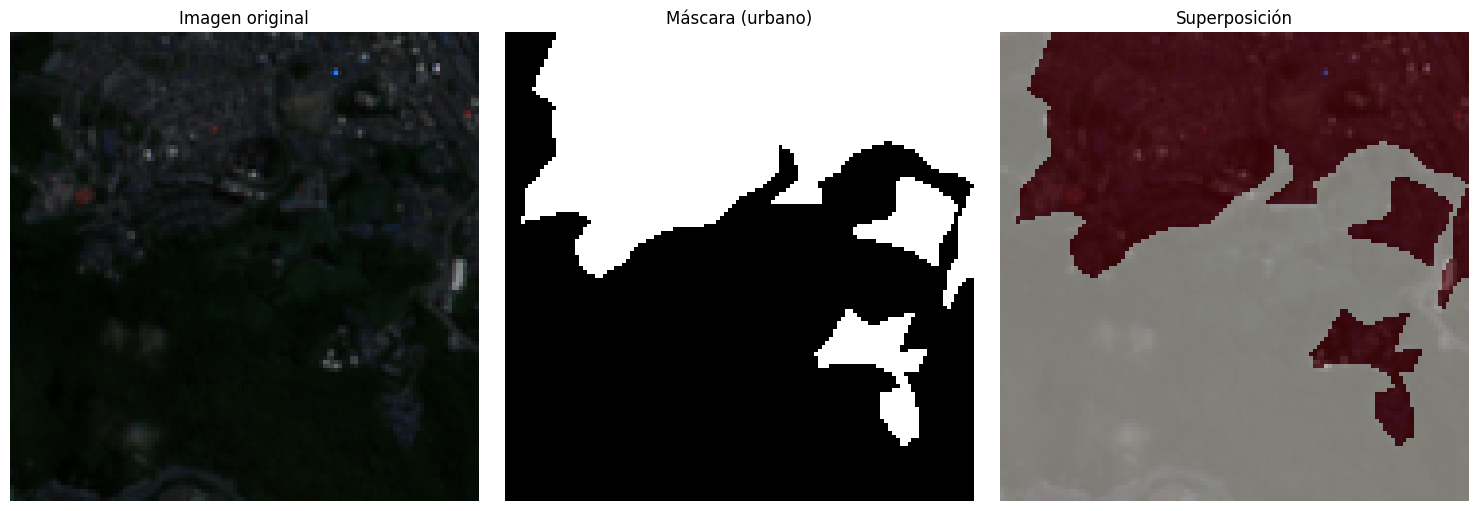

In [ ]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import os

# Cambia este nombre por el archivo que quieras visualizar
filename = '18.tif'  # <-- pon un archivo real aquí

# Rutas
image_path = os.path.join('/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/images', filename)
mask_path = os.path.join('/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/masks', filename)

# Leer imagen
with rasterio.open(image_path) as src:
    img = src.read([1, 2, 3])  # Tomamos las 3 primeras bandas
    img = np.transpose(img, (1, 2, 0))  # [C, H, W] -> [H, W, C]

# Normalizar para visualización
img = (img - np.min(img)) / (np.max(img) - np.min(img))

# Leer máscara
with rasterio.open(mask_path) as msk:
    mask = msk.read(1)  # 1 canal

# Mostrar en subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img)
axs[0].set_title("Imagen original")
axs[0].axis("off")

axs[1].imshow(mask, cmap='gray')
axs[1].set_title("Máscara (urbano)")
axs[1].axis("off")

axs[2].imshow(img)
axs[2].imshow(mask, cmap='Reds', alpha=0.5)
axs[2].set_title("Superposición")
axs[2].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import os
import torch
from torch.utils.data import Dataset
import rasterio
import numpy as np
import torch.nn.functional as F

class UnetUrbanDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.filenames = [
            f for f in os.listdir(image_dir)
            if f.endswith('.tif') and os.path.exists(os.path.join(mask_dir, f))
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)

        # Leer imagen (bandas 1-3)
        with rasterio.open(image_path) as src:
            image = src.read([1, 2, 3]).astype(np.float32)
        image = image / 255.0 if image.max() > 1 else image
        image = torch.from_numpy(image)  # shape: [3, H, W]

        # Leer máscara y expandir dims a [1, H, W]
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        # Padding a 128x128
        image = F.pad(image, (0, 8, 0, 8), mode='reflect')     # [3, 128, 128]
        mask = F.pad(mask, (0, 8, 0, 8), mode='reflect')       # [1, 128, 128]

        mask = mask.squeeze(0).long()  # Volver a [128, 128] para CrossEntropy

        return image, mask


In [ ]:
# Rutas
image_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/images'
mask_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/masks'

# Crear dataset y probar un ejemplo
dataset = UnetUrbanDataset(image_dir, mask_dir)

img, msk = dataset[0]
print("Imagen:", img.shape, img.dtype)
print("Máscara:", msk.shape, msk.dtype)


Imagen: torch.Size([3, 128, 128]) torch.float32
Máscara: torch.Size([128, 128]) torch.int64


# Segmentación de la clase "Tejido urbano"

## Urbano - versión 1

In [ ]:
pip install segmentation-models-pytorch --quiet


In [ ]:
import segmentation_models_pytorch as smp

# Modelo UNet con encoder ligero
model = smp.Unet(
    encoder_name='resnet18',       # backbone
    encoder_weights= 'imagenet',
    in_channels=3,                 # 3 bandas (R, G, B)
    classes=1,                     # Salida binaria (urbano sí/no)
)

print("✅ Modelo UNet creado")


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 264MB/s]


✅ Modelo UNet creado


In [ ]:
from torch.utils.data import DataLoader, random_split

# Porcentaje de validación
val_pct = 0.2
val_size = int(len(dataset) * val_pct)
train_size = len(dataset) - val_size

# Dividir dataset
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

print(f"✅ Dataset dividido: {train_size} train / {val_size} val")


✅ Dataset dividido: 8 train / 1 val


In [ ]:
import torch
import torch.nn as nn

# Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss y optimizador
loss_fn = nn.BCEWithLogitsLoss()  # ya incluye sigmoid internamente
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("✅ Modelo listo para entrenar en:", device)


✅ Modelo listo para entrenar en: cuda


In [ ]:
from sklearn.metrics import jaccard_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Almacenar métricas
history = {
    'train_loss': [],
    'val_loss': [],
    'val_iou': [],
    'val_dice': []
}

def compute_metrics(preds, targets):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    preds_np = preds.cpu().numpy().astype(np.uint8).flatten()
    targets_np = targets.cpu().numpy().astype(np.uint8).flatten()

    iou = jaccard_score(targets_np, preds_np, zero_division=0)
    dice = f1_score(targets_np, preds_np, zero_division=0)
    return iou, dice

best_iou = 0
n_epochs = 100

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for imgs, masks in tqdm(train_loader, desc=f"🟢 Entrenando Epoch {epoch+1}/{n_epochs}"):
        imgs = imgs.to(device)
        masks = masks.to(device).unsqueeze(1).float()  # [B, 1, H, W]

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    history['train_loss'].append(train_loss)

    # Validación
    model.eval()
    val_loss = 0
    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device).unsqueeze(1).float()

            outputs = model(imgs)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

            iou, dice = compute_metrics(outputs, masks)
            iou_scores.append(iou)
            dice_scores.append(dice)

    val_loss /= len(val_loader)
    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)

    history['val_loss'].append(val_loss)
    history['val_iou'].append(mean_iou)
    history['val_dice'].append(mean_dice)

    print(f"📊 Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {mean_iou:.4f} | Dice: {mean_dice:.4f}")

    # Guardar mejor modelo
    if mean_iou > best_iou:
        best_iou = mean_iou
        torch.save(model.state_dict(), '/content/best_unet_model.pth')
        print("💾 Modelo guardado (nuevo mejor IoU)")

print("✅ Entrenamiento finalizado")


🟢 Entrenando Epoch 1/100: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]


📊 Epoch 1/100 | Train Loss: 0.1571 | Val Loss: 0.1960 | IoU: 0.0608 | Dice: 0.1146
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 2/100: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


📊 Epoch 2/100 | Train Loss: 0.1513 | Val Loss: 0.1912 | IoU: 0.0526 | Dice: 0.1000


🟢 Entrenando Epoch 3/100: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


📊 Epoch 3/100 | Train Loss: 0.1458 | Val Loss: 0.1869 | IoU: 0.0462 | Dice: 0.0883


🟢 Entrenando Epoch 4/100: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


📊 Epoch 4/100 | Train Loss: 0.1405 | Val Loss: 0.1822 | IoU: 0.0461 | Dice: 0.0882


🟢 Entrenando Epoch 5/100: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


📊 Epoch 5/100 | Train Loss: 0.1354 | Val Loss: 0.1773 | IoU: 0.0394 | Dice: 0.0758


🟢 Entrenando Epoch 6/100: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


📊 Epoch 6/100 | Train Loss: 0.1308 | Val Loss: 0.1730 | IoU: 0.0282 | Dice: 0.0549


🟢 Entrenando Epoch 7/100: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


📊 Epoch 7/100 | Train Loss: 0.1264 | Val Loss: 0.1689 | IoU: 0.0208 | Dice: 0.0407


🟢 Entrenando Epoch 8/100: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


📊 Epoch 8/100 | Train Loss: 0.1223 | Val Loss: 0.1658 | IoU: 0.0150 | Dice: 0.0296


🟢 Entrenando Epoch 9/100: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


📊 Epoch 9/100 | Train Loss: 0.1183 | Val Loss: 0.1615 | IoU: 0.0169 | Dice: 0.0333


🟢 Entrenando Epoch 10/100: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


📊 Epoch 10/100 | Train Loss: 0.1145 | Val Loss: 0.1580 | IoU: 0.0207 | Dice: 0.0405


🟢 Entrenando Epoch 11/100: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


📊 Epoch 11/100 | Train Loss: 0.1109 | Val Loss: 0.1554 | IoU: 0.0150 | Dice: 0.0296


🟢 Entrenando Epoch 12/100: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


📊 Epoch 12/100 | Train Loss: 0.1075 | Val Loss: 0.1529 | IoU: 0.0150 | Dice: 0.0296


🟢 Entrenando Epoch 13/100: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


📊 Epoch 13/100 | Train Loss: 0.1042 | Val Loss: 0.1506 | IoU: 0.0132 | Dice: 0.0261


🟢 Entrenando Epoch 14/100: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


📊 Epoch 14/100 | Train Loss: 0.1011 | Val Loss: 0.1487 | IoU: 0.0076 | Dice: 0.0150


🟢 Entrenando Epoch 15/100: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


📊 Epoch 15/100 | Train Loss: 0.0984 | Val Loss: 0.1468 | IoU: 0.0076 | Dice: 0.0152


🟢 Entrenando Epoch 16/100: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


📊 Epoch 16/100 | Train Loss: 0.0959 | Val Loss: 0.1456 | IoU: 0.0114 | Dice: 0.0225


🟢 Entrenando Epoch 17/100: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


📊 Epoch 17/100 | Train Loss: 0.0934 | Val Loss: 0.1441 | IoU: 0.0151 | Dice: 0.0297


🟢 Entrenando Epoch 18/100: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


📊 Epoch 18/100 | Train Loss: 0.0904 | Val Loss: 0.1431 | IoU: 0.0148 | Dice: 0.0293


🟢 Entrenando Epoch 19/100: 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


📊 Epoch 19/100 | Train Loss: 0.0879 | Val Loss: 0.1425 | IoU: 0.0146 | Dice: 0.0288


🟢 Entrenando Epoch 20/100: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


📊 Epoch 20/100 | Train Loss: 0.0859 | Val Loss: 0.1405 | IoU: 0.0185 | Dice: 0.0363


🟢 Entrenando Epoch 21/100: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


📊 Epoch 21/100 | Train Loss: 0.0844 | Val Loss: 0.1421 | IoU: 0.0053 | Dice: 0.0105


🟢 Entrenando Epoch 22/100: 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


📊 Epoch 22/100 | Train Loss: 0.0830 | Val Loss: 0.1399 | IoU: 0.0179 | Dice: 0.0351


🟢 Entrenando Epoch 23/100: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


📊 Epoch 23/100 | Train Loss: 0.0827 | Val Loss: 0.1421 | IoU: 0.0169 | Dice: 0.0332


🟢 Entrenando Epoch 24/100: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


📊 Epoch 24/100 | Train Loss: 0.0791 | Val Loss: 0.1428 | IoU: 0.0100 | Dice: 0.0199


🟢 Entrenando Epoch 25/100: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


📊 Epoch 25/100 | Train Loss: 0.0767 | Val Loss: 0.1412 | IoU: 0.0151 | Dice: 0.0298


🟢 Entrenando Epoch 26/100: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


📊 Epoch 26/100 | Train Loss: 0.0750 | Val Loss: 0.1430 | IoU: 0.0082 | Dice: 0.0163


🟢 Entrenando Epoch 27/100: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


📊 Epoch 27/100 | Train Loss: 0.0728 | Val Loss: 0.1452 | IoU: 0.0048 | Dice: 0.0096


🟢 Entrenando Epoch 28/100: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


📊 Epoch 28/100 | Train Loss: 0.0714 | Val Loss: 0.1430 | IoU: 0.0098 | Dice: 0.0194


🟢 Entrenando Epoch 29/100: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


📊 Epoch 29/100 | Train Loss: 0.0695 | Val Loss: 0.1421 | IoU: 0.0050 | Dice: 0.0099


🟢 Entrenando Epoch 30/100: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


📊 Epoch 30/100 | Train Loss: 0.0679 | Val Loss: 0.1450 | IoU: 0.0048 | Dice: 0.0096


🟢 Entrenando Epoch 31/100: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


📊 Epoch 31/100 | Train Loss: 0.0664 | Val Loss: 0.1461 | IoU: 0.0047 | Dice: 0.0094


🟢 Entrenando Epoch 32/100: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


📊 Epoch 32/100 | Train Loss: 0.0650 | Val Loss: 0.1451 | IoU: 0.0048 | Dice: 0.0096


🟢 Entrenando Epoch 33/100: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


📊 Epoch 33/100 | Train Loss: 0.0635 | Val Loss: 0.1450 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 34/100: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


📊 Epoch 34/100 | Train Loss: 0.0621 | Val Loss: 0.1466 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 35/100: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


📊 Epoch 35/100 | Train Loss: 0.0610 | Val Loss: 0.1477 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 36/100: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


📊 Epoch 36/100 | Train Loss: 0.0594 | Val Loss: 0.1475 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 37/100: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


📊 Epoch 37/100 | Train Loss: 0.0585 | Val Loss: 0.1479 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 38/100: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


📊 Epoch 38/100 | Train Loss: 0.0571 | Val Loss: 0.1496 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 39/100: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


📊 Epoch 39/100 | Train Loss: 0.0561 | Val Loss: 0.1509 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 40/100: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


📊 Epoch 40/100 | Train Loss: 0.0550 | Val Loss: 0.1509 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 41/100: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


📊 Epoch 41/100 | Train Loss: 0.0539 | Val Loss: 0.1503 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 42/100: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


📊 Epoch 42/100 | Train Loss: 0.0529 | Val Loss: 0.1513 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 43/100: 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


📊 Epoch 43/100 | Train Loss: 0.0519 | Val Loss: 0.1524 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 44/100: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


📊 Epoch 44/100 | Train Loss: 0.0508 | Val Loss: 0.1533 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 45/100: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


📊 Epoch 45/100 | Train Loss: 0.0500 | Val Loss: 0.1526 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 46/100: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


📊 Epoch 46/100 | Train Loss: 0.0490 | Val Loss: 0.1538 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 47/100: 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


📊 Epoch 47/100 | Train Loss: 0.0482 | Val Loss: 0.1546 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 48/100: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


📊 Epoch 48/100 | Train Loss: 0.0474 | Val Loss: 0.1539 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 49/100: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


📊 Epoch 49/100 | Train Loss: 0.0468 | Val Loss: 0.1542 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 50/100: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


📊 Epoch 50/100 | Train Loss: 0.0465 | Val Loss: 0.1589 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 51/100: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


📊 Epoch 51/100 | Train Loss: 0.0483 | Val Loss: 0.1567 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 52/100: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]


📊 Epoch 52/100 | Train Loss: 0.0519 | Val Loss: 0.1636 | IoU: 0.0000 | Dice: 0.0000


🟢 Entrenando Epoch 53/100: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


📊 Epoch 53/100 | Train Loss: 0.0538 | Val Loss: 0.1729 | IoU: 0.0026 | Dice: 0.0052


🟢 Entrenando Epoch 54/100: 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


📊 Epoch 54/100 | Train Loss: 0.0445 | Val Loss: 0.1672 | IoU: 0.0013 | Dice: 0.0027


🟢 Entrenando Epoch 55/100: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


📊 Epoch 55/100 | Train Loss: 0.0486 | Val Loss: 0.1694 | IoU: 0.0026 | Dice: 0.0052


🟢 Entrenando Epoch 56/100: 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


📊 Epoch 56/100 | Train Loss: 0.0440 | Val Loss: 0.1756 | IoU: 0.0101 | Dice: 0.0199


🟢 Entrenando Epoch 57/100: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


📊 Epoch 57/100 | Train Loss: 0.0454 | Val Loss: 0.1723 | IoU: 0.0076 | Dice: 0.0150


🟢 Entrenando Epoch 58/100: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


📊 Epoch 58/100 | Train Loss: 0.0424 | Val Loss: 0.1653 | IoU: 0.0027 | Dice: 0.0053


🟢 Entrenando Epoch 59/100: 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


📊 Epoch 59/100 | Train Loss: 0.0432 | Val Loss: 0.1685 | IoU: 0.0026 | Dice: 0.0053


🟢 Entrenando Epoch 60/100: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


📊 Epoch 60/100 | Train Loss: 0.0411 | Val Loss: 0.1762 | IoU: 0.0088 | Dice: 0.0174


🟢 Entrenando Epoch 61/100: 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


📊 Epoch 61/100 | Train Loss: 0.0411 | Val Loss: 0.1776 | IoU: 0.0135 | Dice: 0.0266


🟢 Entrenando Epoch 62/100: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


📊 Epoch 62/100 | Train Loss: 0.0400 | Val Loss: 0.1710 | IoU: 0.0064 | Dice: 0.0128


🟢 Entrenando Epoch 63/100: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


📊 Epoch 63/100 | Train Loss: 0.0392 | Val Loss: 0.1702 | IoU: 0.0026 | Dice: 0.0053


🟢 Entrenando Epoch 64/100: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


📊 Epoch 64/100 | Train Loss: 0.0389 | Val Loss: 0.1746 | IoU: 0.0039 | Dice: 0.0078


🟢 Entrenando Epoch 65/100: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


📊 Epoch 65/100 | Train Loss: 0.0378 | Val Loss: 0.1782 | IoU: 0.0075 | Dice: 0.0148


🟢 Entrenando Epoch 66/100: 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


📊 Epoch 66/100 | Train Loss: 0.0374 | Val Loss: 0.1785 | IoU: 0.0100 | Dice: 0.0198


🟢 Entrenando Epoch 67/100: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


📊 Epoch 67/100 | Train Loss: 0.0368 | Val Loss: 0.1777 | IoU: 0.0038 | Dice: 0.0076


🟢 Entrenando Epoch 68/100: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


📊 Epoch 68/100 | Train Loss: 0.0359 | Val Loss: 0.1774 | IoU: 0.0026 | Dice: 0.0052


🟢 Entrenando Epoch 69/100: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


📊 Epoch 69/100 | Train Loss: 0.0358 | Val Loss: 0.1777 | IoU: 0.0039 | Dice: 0.0078


🟢 Entrenando Epoch 70/100: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


📊 Epoch 70/100 | Train Loss: 0.0349 | Val Loss: 0.1790 | IoU: 0.0051 | Dice: 0.0102


🟢 Entrenando Epoch 71/100: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


📊 Epoch 71/100 | Train Loss: 0.0345 | Val Loss: 0.1814 | IoU: 0.0050 | Dice: 0.0100


🟢 Entrenando Epoch 72/100: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


📊 Epoch 72/100 | Train Loss: 0.0340 | Val Loss: 0.1832 | IoU: 0.0038 | Dice: 0.0076


🟢 Entrenando Epoch 73/100: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


📊 Epoch 73/100 | Train Loss: 0.0334 | Val Loss: 0.1843 | IoU: 0.0026 | Dice: 0.0051


🟢 Entrenando Epoch 74/100: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


📊 Epoch 74/100 | Train Loss: 0.0331 | Val Loss: 0.1848 | IoU: 0.0025 | Dice: 0.0051


🟢 Entrenando Epoch 75/100: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


📊 Epoch 75/100 | Train Loss: 0.0324 | Val Loss: 0.1847 | IoU: 0.0038 | Dice: 0.0075


🟢 Entrenando Epoch 76/100: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


📊 Epoch 76/100 | Train Loss: 0.0321 | Val Loss: 0.1850 | IoU: 0.0025 | Dice: 0.0051


🟢 Entrenando Epoch 77/100: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


📊 Epoch 77/100 | Train Loss: 0.0316 | Val Loss: 0.1875 | IoU: 0.0025 | Dice: 0.0051


🟢 Entrenando Epoch 78/100: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


📊 Epoch 78/100 | Train Loss: 0.0312 | Val Loss: 0.1909 | IoU: 0.0050 | Dice: 0.0099


🟢 Entrenando Epoch 79/100: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


📊 Epoch 79/100 | Train Loss: 0.0308 | Val Loss: 0.1929 | IoU: 0.0073 | Dice: 0.0146


🟢 Entrenando Epoch 80/100: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


📊 Epoch 80/100 | Train Loss: 0.0303 | Val Loss: 0.1924 | IoU: 0.0074 | Dice: 0.0147


🟢 Entrenando Epoch 81/100: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


📊 Epoch 81/100 | Train Loss: 0.0300 | Val Loss: 0.1914 | IoU: 0.0062 | Dice: 0.0124


🟢 Entrenando Epoch 82/100: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


📊 Epoch 82/100 | Train Loss: 0.0295 | Val Loss: 0.1920 | IoU: 0.0050 | Dice: 0.0100


🟢 Entrenando Epoch 83/100: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


📊 Epoch 83/100 | Train Loss: 0.0292 | Val Loss: 0.1945 | IoU: 0.0074 | Dice: 0.0147


🟢 Entrenando Epoch 84/100: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


📊 Epoch 84/100 | Train Loss: 0.0288 | Val Loss: 0.1979 | IoU: 0.0121 | Dice: 0.0239


🟢 Entrenando Epoch 85/100: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


📊 Epoch 85/100 | Train Loss: 0.0284 | Val Loss: 0.1991 | IoU: 0.0121 | Dice: 0.0240


🟢 Entrenando Epoch 86/100: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


📊 Epoch 86/100 | Train Loss: 0.0281 | Val Loss: 0.1976 | IoU: 0.0099 | Dice: 0.0195


🟢 Entrenando Epoch 87/100: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


📊 Epoch 87/100 | Train Loss: 0.0277 | Val Loss: 0.1973 | IoU: 0.0099 | Dice: 0.0196


🟢 Entrenando Epoch 88/100: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


📊 Epoch 88/100 | Train Loss: 0.0274 | Val Loss: 0.1993 | IoU: 0.0110 | Dice: 0.0218


🟢 Entrenando Epoch 89/100: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


📊 Epoch 89/100 | Train Loss: 0.0270 | Val Loss: 0.2002 | IoU: 0.0110 | Dice: 0.0218


🟢 Entrenando Epoch 90/100: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


📊 Epoch 90/100 | Train Loss: 0.0267 | Val Loss: 0.1993 | IoU: 0.0099 | Dice: 0.0197


🟢 Entrenando Epoch 91/100: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


📊 Epoch 91/100 | Train Loss: 0.0264 | Val Loss: 0.1999 | IoU: 0.0087 | Dice: 0.0172


🟢 Entrenando Epoch 92/100: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


📊 Epoch 92/100 | Train Loss: 0.0261 | Val Loss: 0.2016 | IoU: 0.0111 | Dice: 0.0220


🟢 Entrenando Epoch 93/100: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


📊 Epoch 93/100 | Train Loss: 0.0258 | Val Loss: 0.2014 | IoU: 0.0087 | Dice: 0.0172


🟢 Entrenando Epoch 94/100: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


📊 Epoch 94/100 | Train Loss: 0.0254 | Val Loss: 0.2007 | IoU: 0.0062 | Dice: 0.0124


🟢 Entrenando Epoch 95/100: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


📊 Epoch 95/100 | Train Loss: 0.0252 | Val Loss: 0.2018 | IoU: 0.0062 | Dice: 0.0124


🟢 Entrenando Epoch 96/100: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


📊 Epoch 96/100 | Train Loss: 0.0249 | Val Loss: 0.2028 | IoU: 0.0099 | Dice: 0.0196


🟢 Entrenando Epoch 97/100: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


📊 Epoch 97/100 | Train Loss: 0.0246 | Val Loss: 0.2032 | IoU: 0.0087 | Dice: 0.0173


🟢 Entrenando Epoch 98/100: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


📊 Epoch 98/100 | Train Loss: 0.0243 | Val Loss: 0.2039 | IoU: 0.0088 | Dice: 0.0173


🟢 Entrenando Epoch 99/100: 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


📊 Epoch 99/100 | Train Loss: 0.0240 | Val Loss: 0.2041 | IoU: 0.0075 | Dice: 0.0149


🟢 Entrenando Epoch 100/100: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


📊 Epoch 100/100 | Train Loss: 0.0238 | Val Loss: 0.2036 | IoU: 0.0063 | Dice: 0.0126
✅ Entrenamiento finalizado


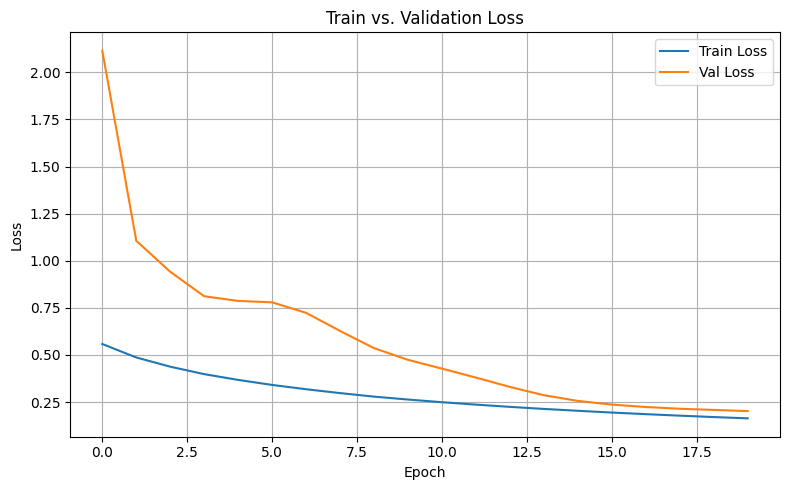

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 500x500 with 0 Axes>

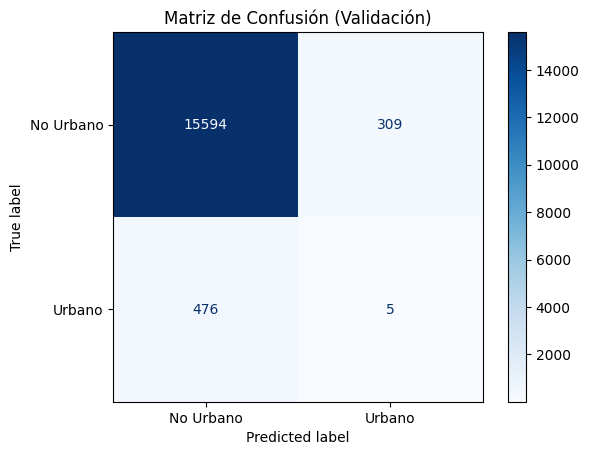

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener una predicción del val_loader
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1).float()
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        break  # solo un batch

# Tomamos la primera imagen y máscara del batch
true = masks[0].cpu().numpy().flatten().astype(np.uint8)
pred = preds[0].cpu().numpy().flatten().astype(np.uint8)

# Matriz de confusión
cm = confusion_matrix(true, pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Urbano', 'Urbano'])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión (Validación)")
plt.grid(False)
plt.show()

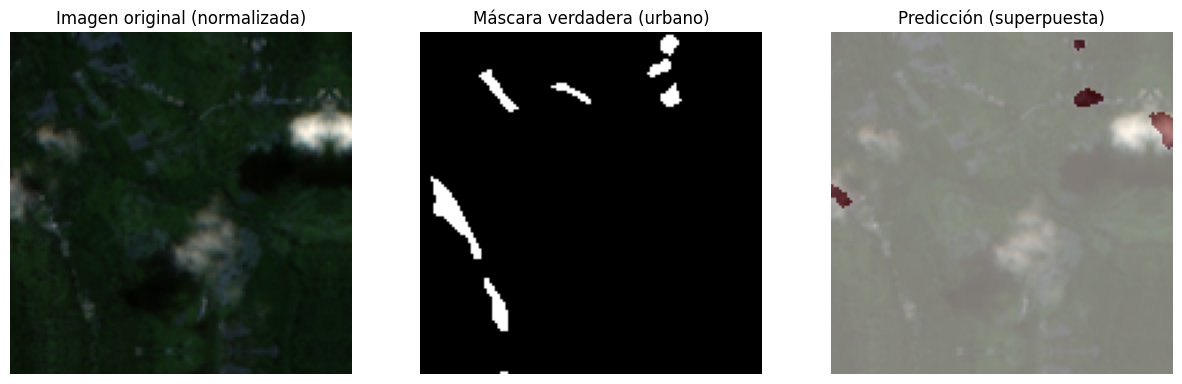

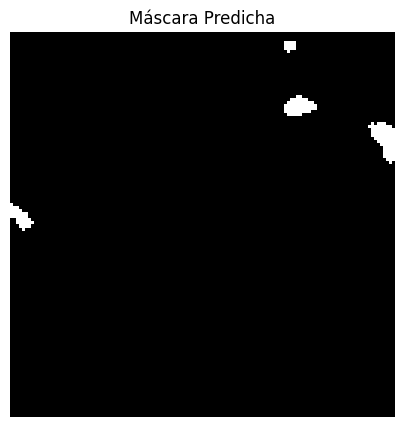

<Figure size 640x480 with 0 Axes>

In [ ]:
def normalize_for_display(image):
    image = image - np.min(image)
    image = image / np.max(image)
    return image

img = images[0].cpu().numpy().transpose(1, 2, 0)
img_vis = normalize_for_display(img)

mask_true = masks[0][0].cpu().numpy()
mask_pred = preds[0][0].cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img_vis)
axs[0].set_title("Imagen original (normalizada)")
axs[0].axis("off")

axs[1].imshow(mask_true, cmap='gray')
axs[1].set_title("Máscara verdadera (urbano)")
axs[1].axis("off")

axs[2].imshow(img_vis)
axs[2].imshow(mask_pred, cmap='Reds', alpha=0.5)
axs[2].set_title("Predicción (superpuesta)")
axs[2].axis("off")

plt.figure(figsize=(5,5))
plt.imshow(mask_pred, cmap='gray')
plt.title("Máscara Predicha")
plt.axis('off')
plt.show()


plt.tight_layout()
plt.show()


## Urbano - versión 2 (100 epocas)

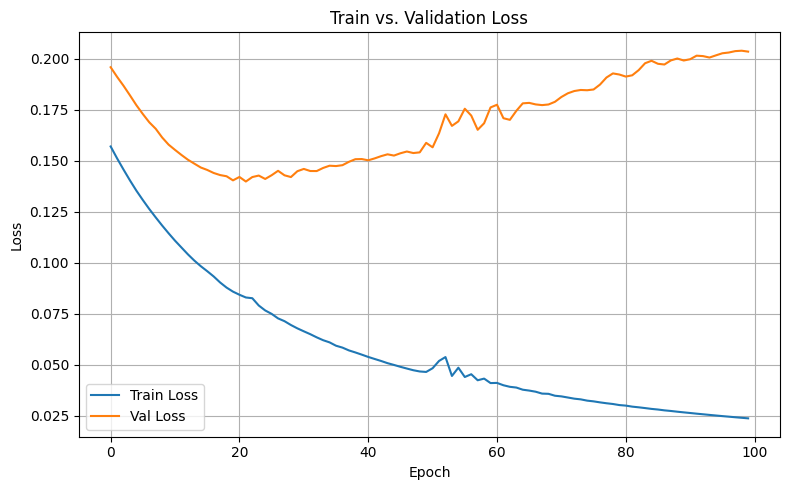

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 500x500 with 0 Axes>

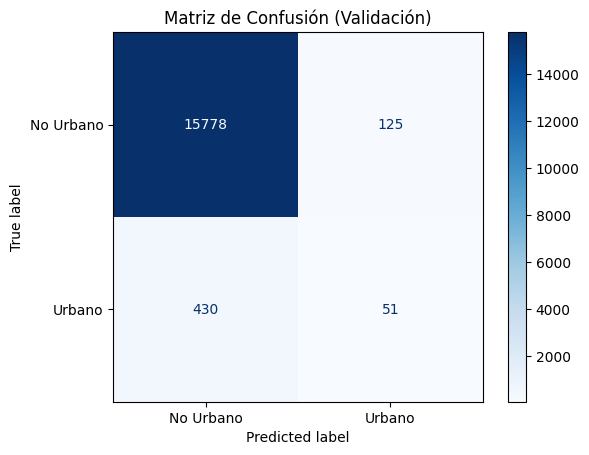

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener una predicción del val_loader
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1).float()
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        break  # solo un batch

# Tomamos la primera imagen y máscara del batch
true = masks[0].cpu().numpy().flatten().astype(np.uint8)
pred = preds[0].cpu().numpy().flatten().astype(np.uint8)

# Matriz de confusión
cm = confusion_matrix(true, pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Urbano', 'Urbano'])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión (Validación)")
plt.grid(False)
plt.show()


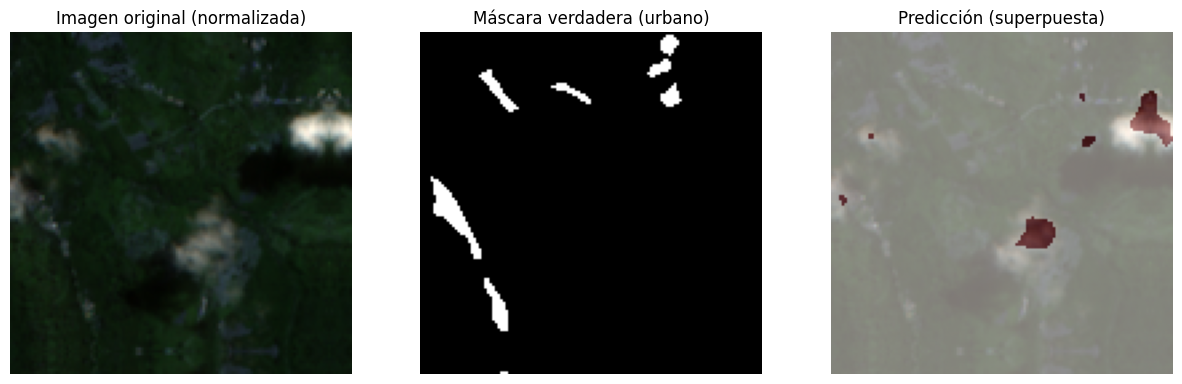

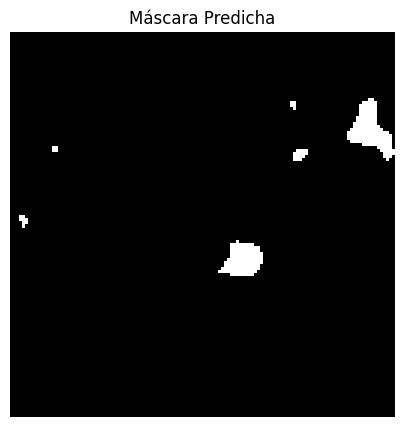

<Figure size 640x480 with 0 Axes>

In [ ]:
def normalize_for_display(image):
    image = image - np.min(image)
    image = image / np.max(image)
    return image

img = images[0].cpu().numpy().transpose(1, 2, 0)
img_vis = normalize_for_display(img)

mask_true = masks[0][0].cpu().numpy()
mask_pred = preds[0][0].cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img_vis)
axs[0].set_title("Imagen original (normalizada)")
axs[0].axis("off")

axs[1].imshow(mask_true, cmap='gray')
axs[1].set_title("Máscara verdadera (urbano)")
axs[1].axis("off")

axs[2].imshow(img_vis)
axs[2].imshow(mask_pred, cmap='Reds', alpha=0.5)
axs[2].set_title("Predicción (superpuesta)")
axs[2].axis("off")

plt.figure(figsize=(5,5))
plt.imshow(mask_pred, cmap='gray')
plt.title("Máscara Predicha")
plt.axis('off')
plt.show()


plt.tight_layout()
plt.show()


## Urbano - versión 3 (augmentación de datos)

In [ ]:
pip install albumentations --quiet


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Transformaciones para entrenamiento
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),  # ya está normalizado, no tocamos
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-115-03e55fa35872>:11: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [ ]:
class UnetUrbanDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.filenames = [
            f for f in os.listdir(image_dir)
            if f.endswith('.tif') and os.path.exists(os.path.join(mask_dir, f))
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)

        with rasterio.open(image_path) as src:
            image = src.read([1, 2, 3]).astype(np.float32).transpose(1, 2, 0)  # [H, W, C]

        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)  # [H, W]

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = torch.from_numpy(image.transpose(2, 0, 1))  # [C, H, W]
            mask = torch.from_numpy(mask)

        # Padding reflejado a 128x128
        image = F.pad(image, (0, 8, 0, 8), mode='reflect')
        mask = F.pad(mask.unsqueeze(0).float(), (0, 8, 0, 8), mode='reflect').squeeze(0).long()

        return image, mask


In [ ]:
# Rutas
image_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/images'
mask_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/masks'

# Dataset y división
full_dataset = UnetUrbanDataset(image_dir, mask_dir)
val_pct = 0.2
val_size = int(len(full_dataset) * val_pct)
train_size = len(full_dataset) - val_size

train_dataset = UnetUrbanDataset(image_dir, mask_dir, transform=train_transform)
val_dataset = UnetUrbanDataset(image_dir, mask_dir, transform=None)

# DataLoaders
train_ds, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size])
_, val_ds = torch.utils.data.random_split(val_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)


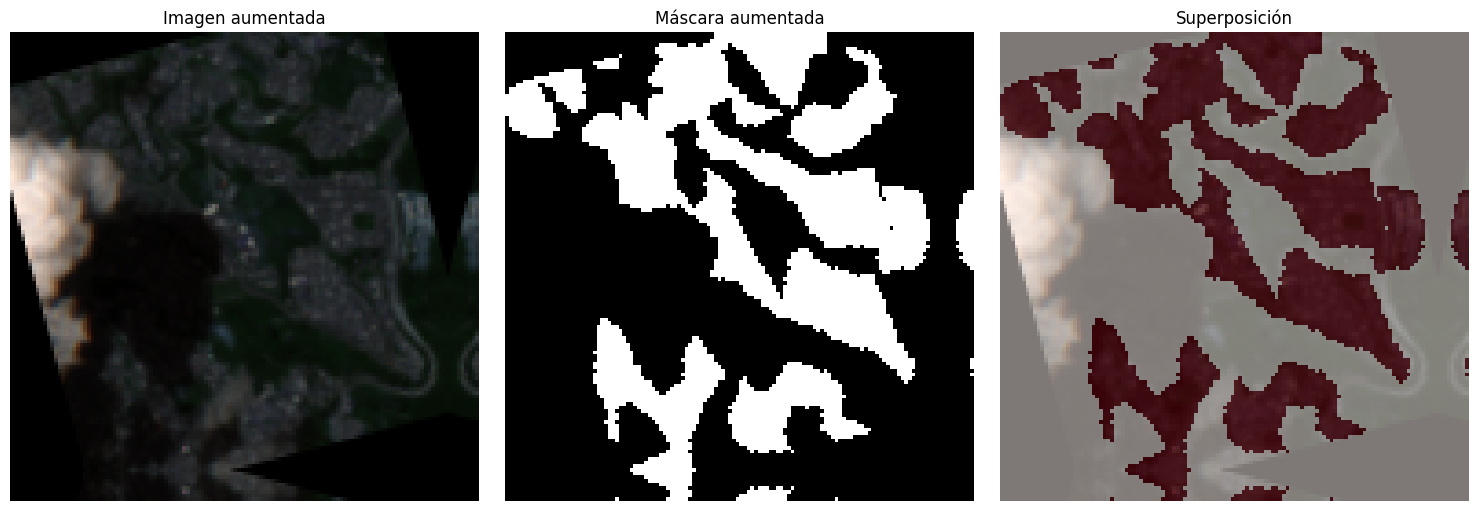

In [ ]:
# Tomamos un sample del dataset con augmentación (train_dataset ya tiene transform)
sample_img, sample_mask = train_dataset[0]

# Convertir para visualización
img_np = sample_img.numpy().transpose(1, 2, 0)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
mask_np = sample_mask.numpy()

# Visualizar
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img_np)
axs[0].set_title("Imagen aumentada")
axs[0].axis("off")

axs[1].imshow(mask_np, cmap='gray')
axs[1].set_title("Máscara aumentada")
axs[1].axis("off")

axs[2].imshow(img_np)
axs[2].imshow(mask_np, cmap='Reds', alpha=0.5)
axs[2].set_title("Superposición")
axs[2].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name='resnet18',
    encoder_weights='imagenet',  # ✅ activado
    in_channels=3,
    classes=1,
)
model = model.to(device)


In [ ]:
import torch.nn as nn

# Peso para la clase urbana (ajustable)
pos_weight = torch.tensor([5.0]).to(device)  # puedes subirlo a 10 si sigue débil

# Función de pérdida con peso
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("✅ Pérdida ponderada y optimizador definidos.")


✅ Pérdida ponderada y optimizador definidos.


In [ ]:
from sklearn.metrics import jaccard_score, f1_score
from tqdm import tqdm
import numpy as np

# Historial
history = {
    'train_loss': [],
    'val_loss': [],
    'val_iou': [],
    'val_dice': []
}

def compute_metrics(preds, targets):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds_np = preds.cpu().numpy().astype(np.uint8).flatten()
    targets_np = targets.cpu().numpy().astype(np.uint8).flatten()

    iou = jaccard_score(targets_np, preds_np, zero_division=0)
    dice = f1_score(targets_np, preds_np, zero_division=0)
    return iou, dice

best_iou = 0
n_epochs = 20  # Ajustable

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for imgs, masks in tqdm(train_loader, desc=f"🟢 Entrenando Epoch {epoch+1}/{n_epochs}"):
        imgs = imgs.to(device)
        masks = masks.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    history['train_loss'].append(train_loss)

    # Validación
    model.eval()
    val_loss = 0
    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device).unsqueeze(1).float()

            outputs = model(imgs)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

            iou, dice = compute_metrics(outputs, masks)
            iou_scores.append(iou)
            dice_scores.append(dice)

    val_loss /= len(val_loader)
    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)

    history['val_loss'].append(val_loss)
    history['val_iou'].append(mean_iou)
    history['val_dice'].append(mean_dice)


🟢 Entrenando Epoch 20/20: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


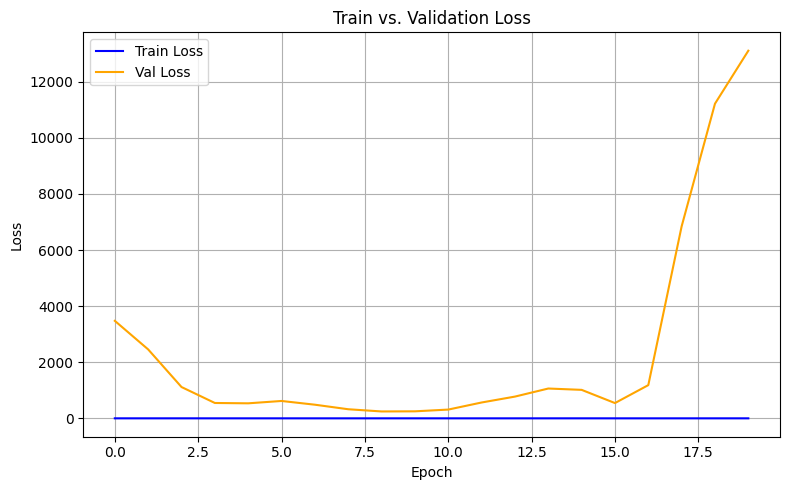

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Val Loss', color='orange')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 500x500 with 0 Axes>

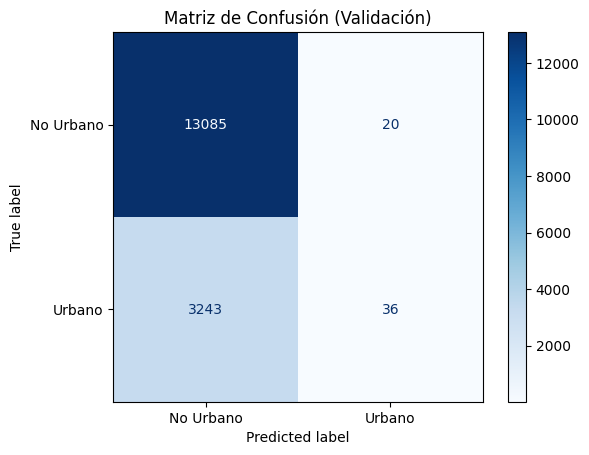

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1).float()
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        break  # solo el primer batch

# Tomamos la primera muestra
true = masks[0].cpu().numpy().flatten().astype(np.uint8)
pred = preds[0].cpu().numpy().flatten().astype(np.uint8)

cm = confusion_matrix(true, pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Urbano', 'Urbano'])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión (Validación)")
plt.grid(False)
plt.show()


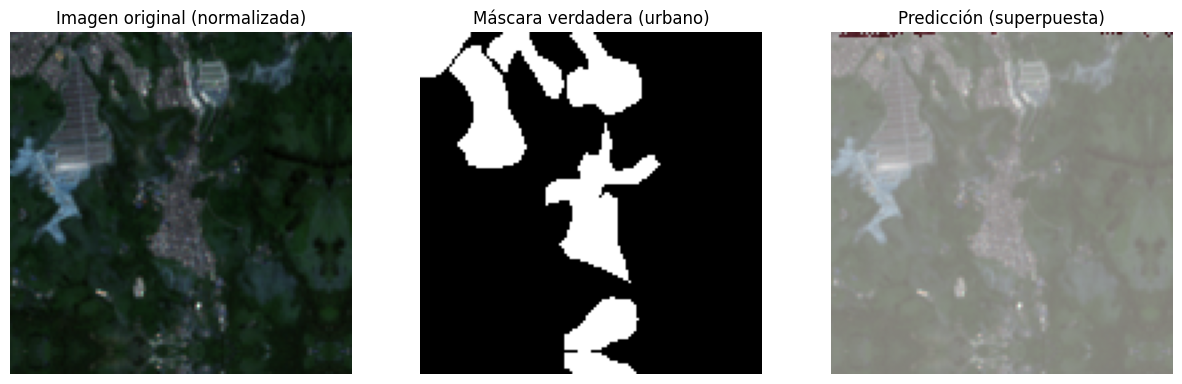

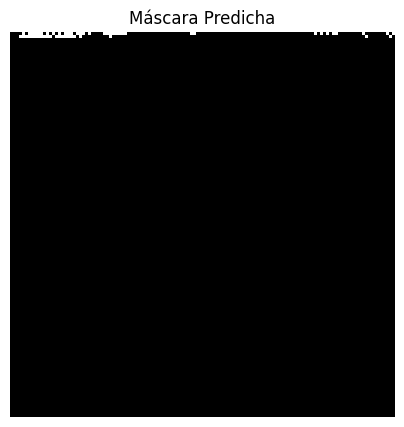

<Figure size 640x480 with 0 Axes>

In [ ]:
def normalize_for_display(image):
    image = image - np.min(image)
    image = image / np.max(image)
    return image

img = images[0].cpu().numpy().transpose(1, 2, 0)
img_vis = normalize_for_display(img)

mask_true = masks[0][0].cpu().numpy()
mask_pred = preds[0][0].cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img_vis)
axs[0].set_title("Imagen original (normalizada)")
axs[0].axis("off")

axs[1].imshow(mask_true, cmap='gray')
axs[1].set_title("Máscara verdadera (urbano)")
axs[1].axis("off")

axs[2].imshow(img_vis)
axs[2].imshow(mask_pred, cmap='Reds', alpha=0.5)
axs[2].set_title("Predicción (superpuesta)")
axs[2].axis("off")

plt.figure(figsize=(5,5))
plt.imshow(mask_pred, cmap='gray')
plt.title("Máscara Predicha")
plt.axis('off')
plt.show()



plt.tight_layout()
plt.show()


## Urbano - versión 4 (augmentación de datos con diferentes técnicas y diferenciando para train y val)

In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import rasterio


In [ ]:
# Augmentación fuerte para entrenamiento
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2()
])

# Transformaciones mínimas para validación
val_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2()
])


<ipython-input-163-fb031d24f4fc>:8: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [ ]:
class UnetUrbanDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.filenames = [
            f for f in os.listdir(image_dir)
            if f.endswith('.tif') and os.path.exists(os.path.join(mask_dir, f))
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)

        with rasterio.open(image_path) as src:
            image = src.read([1, 2, 3]).astype(np.float32).transpose(1, 2, 0)

        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = torch.from_numpy(image.transpose(2, 0, 1))
            mask = torch.from_numpy(mask)

        # Padding reflejado a 128x128
        image = F.pad(image, (0, 8, 0, 8), mode='reflect')
        mask = F.pad(mask.unsqueeze(0).float(), (0, 8, 0, 8), mode='reflect').squeeze(0).long()

        return image, mask


In [ ]:
# Rutas de tus imágenes originales
image_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/images'
mask_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/masks'

# Crear 5 copias con augmentación diferente
augmented_datasets = [
    UnetUrbanDataset(image_dir, mask_dir, transform=train_transform) for _ in range(6)
]

# Concatenar todas las copias
full_augmented_dataset = ConcatDataset(augmented_datasets)
print(f"🧪 Dataset aumentado total: {len(full_augmented_dataset)} muestras")


🧪 Dataset aumentado total: 54 muestras


In [ ]:
val_pct = 0.3
total_len = len(full_augmented_dataset)
val_size = int(total_len * val_pct)
train_size = total_len - val_size

indices = torch.randperm(total_len).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = Subset(full_augmented_dataset, train_indices)
val_dataset = Subset(full_augmented_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"🟩 Train: {len(train_dataset)}")
print(f"🟦 Val: {len(val_dataset)}")


🟩 Train: 38
🟦 Val: 16


In [ ]:
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1,
).to(device)


In [ ]:
import torch.optim as optim

# Pérdida binaria para segmentación 1 clase (urbano)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Métricas para guardar
train_losses = []
val_losses = []
ious = []
dices = []


In [ ]:
def calculate_iou(pred, target):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def calculate_dice(pred, target):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)


In [ ]:
from tqdm import tqdm

n_epochs = 10  # puedes ajustar

best_iou = 0

for epoch in range(n_epochs):
    model.train()
    train_loss = 0

    for imgs, masks in tqdm(train_loader, desc=f"🟢 Entrenando Epoch {epoch+1}/{n_epochs}"):
        imgs, masks = imgs.to(device), masks.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validación
    model.eval()
    val_loss = 0
    iou_total = 0
    dice_total = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device).unsqueeze(1).float()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            iou_total += calculate_iou(preds, masks)
            dice_total += calculate_dice(preds, masks)

    val_loss /= len(val_loader)
    iou_avg = iou_total / len(val_loader)
    dice_avg = dice_total / len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    ious.append(iou_avg.item())
    dices.append(dice_avg.item())

    print(f"📊 Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {iou_avg:.4f} | Dice: {dice_avg:.4f}")

    # Guardar mejor modelo
    if iou_avg > best_iou:
        best_iou = iou_avg
        torch.save(model.state_dict(), "best_model.pth")
        print("💾 Modelo guardado (nuevo mejor IoU)")


🟢 Entrenando Epoch 1/10: 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]


📊 Epoch 1/10 | Train Loss: 0.6110 | Val Loss: 0.6871 | IoU: 0.2023 | Dice: 0.3363
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 2/10: 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


📊 Epoch 2/10 | Train Loss: 0.5811 | Val Loss: 0.6455 | IoU: 0.2584 | Dice: 0.4076
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 3/10: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


📊 Epoch 3/10 | Train Loss: 0.5521 | Val Loss: 0.6423 | IoU: 0.2374 | Dice: 0.3833


🟢 Entrenando Epoch 4/10: 100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


📊 Epoch 4/10 | Train Loss: 0.5311 | Val Loss: 0.6087 | IoU: 0.1513 | Dice: 0.2604


🟢 Entrenando Epoch 5/10: 100%|██████████| 5/5 [00:00<00:00,  6.56it/s]


📊 Epoch 5/10 | Train Loss: 0.5285 | Val Loss: 0.6284 | IoU: 0.2123 | Dice: 0.3450


🟢 Entrenando Epoch 6/10: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


📊 Epoch 6/10 | Train Loss: 0.5383 | Val Loss: 0.5964 | IoU: 0.2420 | Dice: 0.3623


🟢 Entrenando Epoch 7/10: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


📊 Epoch 7/10 | Train Loss: 0.5295 | Val Loss: 0.5738 | IoU: 0.1527 | Dice: 0.2636


🟢 Entrenando Epoch 8/10: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s]


📊 Epoch 8/10 | Train Loss: 0.5024 | Val Loss: 0.5589 | IoU: 0.1874 | Dice: 0.3111


🟢 Entrenando Epoch 9/10: 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]


📊 Epoch 9/10 | Train Loss: 0.5079 | Val Loss: 0.5692 | IoU: 0.1507 | Dice: 0.2617


🟢 Entrenando Epoch 10/10: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


📊 Epoch 10/10 | Train Loss: 0.4791 | Val Loss: 0.5675 | IoU: 0.2024 | Dice: 0.3339


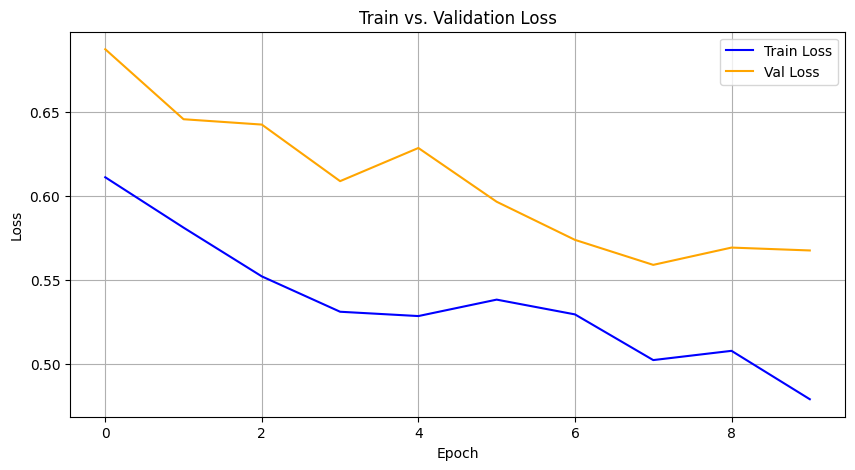

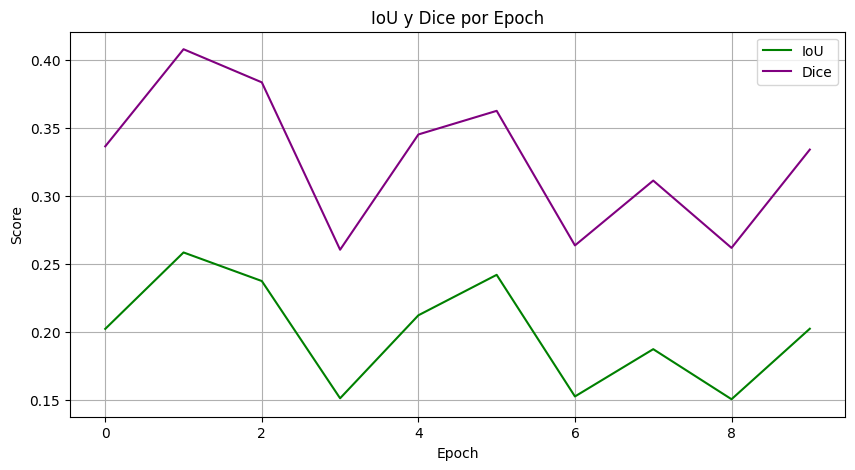

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange')
plt.title("Train vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# IoU + Dice
plt.figure(figsize=(10, 5))
plt.plot(ious, label='IoU', color='green')
plt.plot(dices, label='Dice', color='purple')
plt.title("IoU y Dice por Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 600x600 with 0 Axes>

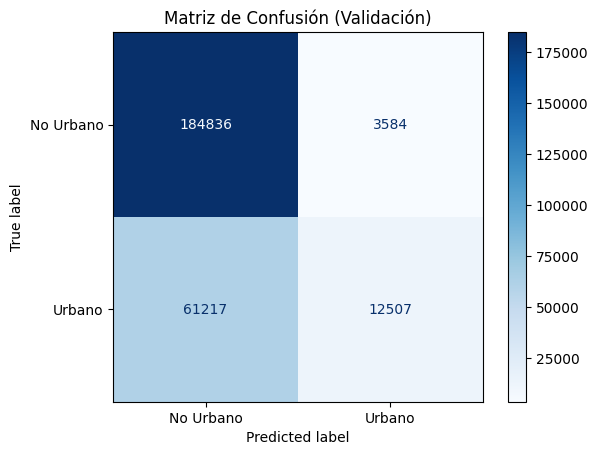

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.numpy().flatten()  # [B, H, W] -> flat

        outputs = model(imgs)
        preds = torch.sigmoid(outputs).cpu().numpy()
        preds = (preds > 0.5).astype(np.uint8).flatten()

        y_true.extend(masks)
        y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=["No Urbano", "Urbano"])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión (Validación)")
plt.show()


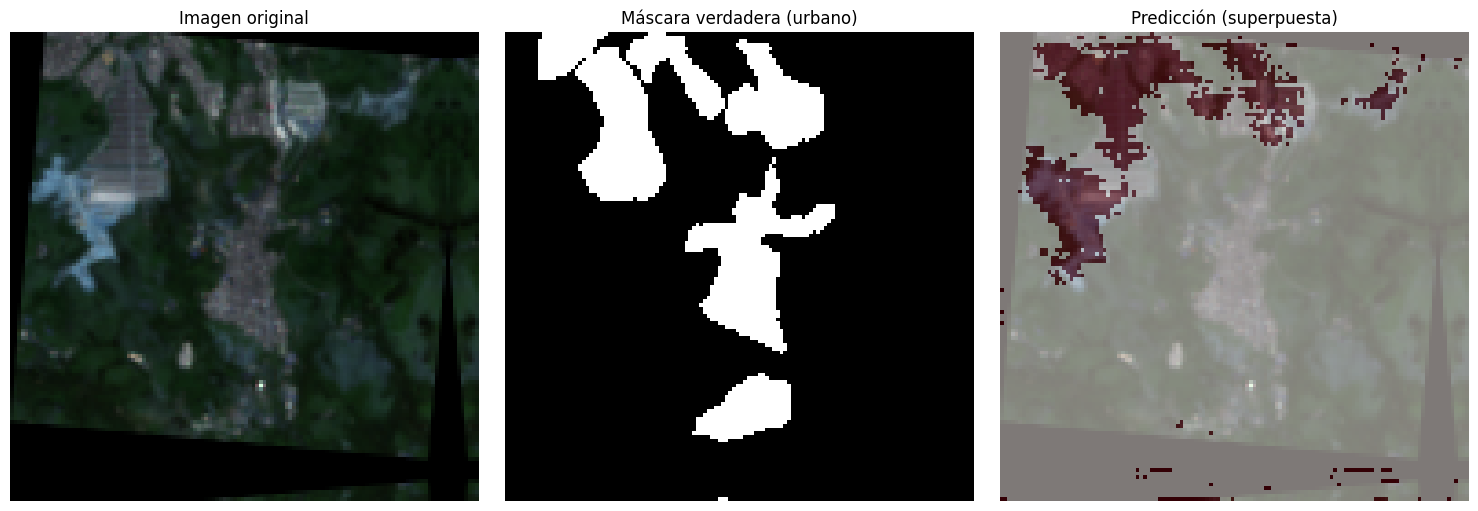

In [ ]:
model.eval()

# Seleccionamos 1 imagen del val_dataset
img, mask = val_dataset[0]
img_input = img.unsqueeze(0).to(device)  # [1, C, H, W]
true_mask = mask.numpy()

with torch.no_grad():
    pred = model(img_input)
    pred_mask = torch.sigmoid(pred).squeeze().cpu().numpy()
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

# Convertimos imagen para visualizar
img_np = img.numpy().transpose(1, 2, 0)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Mostrar
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img_np)
axs[0].set_title("Imagen original")
axs[1].imshow(true_mask, cmap='gray')
axs[1].set_title("Máscara verdadera (urbano)")
axs[2].imshow(img_np)
axs[2].imshow(pred_mask, cmap='Reds', alpha=0.5)
axs[2].set_title("Predicción (superpuesta)")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()


## Urbano - versión 5 (augmentación de datos con diferentes técnicas y diferenciando para train y val y 300 epocas)

In [ ]:
# Augmentación fuerte para entrenamiento
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2()
])

# Transformaciones mínimas para validación
val_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-214-fb031d24f4fc>:8: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [ ]:
class UnetUrbanDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.filenames = [
            f for f in os.listdir(image_dir)
            if f.endswith('.tif') and os.path.exists(os.path.join(mask_dir, f))
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)

        with rasterio.open(image_path) as src:
            image = src.read([1, 2, 3]).astype(np.float32).transpose(1, 2, 0)

        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = torch.from_numpy(image.transpose(2, 0, 1))
            mask = torch.from_numpy(mask)

        # Padding reflejado a 128x128
        image = F.pad(image, (0, 8, 0, 8), mode='reflect')
        mask = F.pad(mask.unsqueeze(0).float(), (0, 8, 0, 8), mode='reflect').squeeze(0).long()

        return image, mask


In [ ]:
# Rutas de tus imágenes originales
image_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/images'
mask_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet/masks'

# Crear 5 copias con augmentación diferente
augmented_datasets = [
    UnetUrbanDataset(image_dir, mask_dir, transform=train_transform) for _ in range(8)
]

# Concatenar todas las copias
full_augmented_dataset = ConcatDataset(augmented_datasets)
print(f"🧪 Dataset aumentado total: {len(full_augmented_dataset)} muestras")

🧪 Dataset aumentado total: 72 muestras


In [ ]:
val_pct = 0.3
total_len = len(full_augmented_dataset)
val_size = int(total_len * val_pct)
train_size = total_len - val_size

indices = torch.randperm(total_len).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = Subset(full_augmented_dataset, train_indices)
val_dataset = Subset(full_augmented_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"🟩 Train: {len(train_dataset)}")
print(f"🟦 Val: {len(val_dataset)}")

🟩 Train: 51
🟦 Val: 21


In [ ]:
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1,
).to(device)


In [ ]:
import torch.optim as optim

# Pérdida binaria para segmentación 1 clase (urbano)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Métricas para guardar
train_losses = []
val_losses = []
ious = []
dices = []


In [ ]:
def calculate_iou(pred, target):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def calculate_dice(pred, target):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)


In [ ]:
from tqdm import tqdm

n_epochs = 300  # puedes ajustar

best_iou = 0

for epoch in range(n_epochs):
    model.train()
    train_loss = 0

    for imgs, masks in tqdm(train_loader, desc=f"🟢 Entrenando Epoch {epoch+1}/{n_epochs}"):
        imgs, masks = imgs.to(device), masks.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validación
    model.eval()
    val_loss = 0
    iou_total = 0
    dice_total = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device).unsqueeze(1).float()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            iou_total += calculate_iou(preds, masks)
            dice_total += calculate_dice(preds, masks)

    val_loss /= len(val_loader)
    iou_avg = iou_total / len(val_loader)
    dice_avg = dice_total / len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    ious.append(iou_avg.item())
    dices.append(dice_avg.item())

    print(f"📊 Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {iou_avg:.4f} | Dice: {dice_avg:.4f}")

    # Guardar mejor modelo
    if iou_avg > best_iou:
        best_iou = iou_avg
        torch.save(model.state_dict(), "best_model.pth")
        print("💾 Modelo guardado (nuevo mejor IoU)")

🟢 Entrenando Epoch 1/300: 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


📊 Epoch 1/300 | Train Loss: 0.7153 | Val Loss: 0.6966 | IoU: 0.2254 | Dice: 0.3594
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 2/300: 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]


📊 Epoch 2/300 | Train Loss: 0.6683 | Val Loss: 0.6859 | IoU: 0.2129 | Dice: 0.3478


🟢 Entrenando Epoch 3/300: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


📊 Epoch 3/300 | Train Loss: 0.6458 | Val Loss: 0.6681 | IoU: 0.2419 | Dice: 0.3745
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 4/300: 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


📊 Epoch 4/300 | Train Loss: 0.6255 | Val Loss: 0.6459 | IoU: 0.1714 | Dice: 0.2924


🟢 Entrenando Epoch 5/300: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


📊 Epoch 5/300 | Train Loss: 0.5943 | Val Loss: 0.6177 | IoU: 0.2151 | Dice: 0.3462


🟢 Entrenando Epoch 6/300: 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


📊 Epoch 6/300 | Train Loss: 0.5767 | Val Loss: 0.5486 | IoU: 0.2624 | Dice: 0.3907
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 7/300: 100%|██████████| 7/7 [00:01<00:00,  6.45it/s]


📊 Epoch 7/300 | Train Loss: 0.5566 | Val Loss: 0.5946 | IoU: 0.3080 | Dice: 0.4290
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 8/300: 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


📊 Epoch 8/300 | Train Loss: 0.5246 | Val Loss: 0.5623 | IoU: 0.1738 | Dice: 0.2720


🟢 Entrenando Epoch 9/300: 100%|██████████| 7/7 [00:01<00:00,  5.49it/s]


📊 Epoch 9/300 | Train Loss: 0.5390 | Val Loss: 0.5029 | IoU: 0.2412 | Dice: 0.3499


🟢 Entrenando Epoch 10/300: 100%|██████████| 7/7 [00:01<00:00,  5.15it/s]


📊 Epoch 10/300 | Train Loss: 0.5318 | Val Loss: 0.5566 | IoU: 0.0924 | Dice: 0.1638


🟢 Entrenando Epoch 11/300: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


📊 Epoch 11/300 | Train Loss: 0.5521 | Val Loss: 0.5574 | IoU: 0.0675 | Dice: 0.1246


🟢 Entrenando Epoch 12/300: 100%|██████████| 7/7 [00:01<00:00,  6.61it/s]


📊 Epoch 12/300 | Train Loss: 0.5133 | Val Loss: 0.4943 | IoU: 0.2392 | Dice: 0.3813


🟢 Entrenando Epoch 13/300: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


📊 Epoch 13/300 | Train Loss: 0.5028 | Val Loss: 0.4566 | IoU: 0.3541 | Dice: 0.5225
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 14/300: 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


📊 Epoch 14/300 | Train Loss: 0.5173 | Val Loss: 0.4790 | IoU: 0.2989 | Dice: 0.4600


🟢 Entrenando Epoch 15/300: 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


📊 Epoch 15/300 | Train Loss: 0.5105 | Val Loss: 0.4604 | IoU: 0.4348 | Dice: 0.5826
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 16/300: 100%|██████████| 7/7 [00:01<00:00,  6.19it/s]


📊 Epoch 16/300 | Train Loss: 0.4804 | Val Loss: 0.4280 | IoU: 0.3979 | Dice: 0.5560


🟢 Entrenando Epoch 17/300: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


📊 Epoch 17/300 | Train Loss: 0.4670 | Val Loss: 0.4627 | IoU: 0.2641 | Dice: 0.4143


🟢 Entrenando Epoch 18/300: 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


📊 Epoch 18/300 | Train Loss: 0.4747 | Val Loss: 0.4699 | IoU: 0.3718 | Dice: 0.5214


🟢 Entrenando Epoch 19/300: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


📊 Epoch 19/300 | Train Loss: 0.4870 | Val Loss: 0.5271 | IoU: 0.0731 | Dice: 0.1200


🟢 Entrenando Epoch 20/300: 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


📊 Epoch 20/300 | Train Loss: 0.4809 | Val Loss: 0.4271 | IoU: 0.2821 | Dice: 0.4325


🟢 Entrenando Epoch 21/300: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


📊 Epoch 21/300 | Train Loss: 0.4473 | Val Loss: 0.4868 | IoU: 0.2771 | Dice: 0.4325


🟢 Entrenando Epoch 22/300: 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


📊 Epoch 22/300 | Train Loss: 0.4816 | Val Loss: 0.4846 | IoU: 0.2379 | Dice: 0.3783


🟢 Entrenando Epoch 23/300: 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


📊 Epoch 23/300 | Train Loss: 0.4907 | Val Loss: 0.4035 | IoU: 0.4212 | Dice: 0.5858


🟢 Entrenando Epoch 24/300: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


📊 Epoch 24/300 | Train Loss: 0.4359 | Val Loss: 0.4483 | IoU: 0.2682 | Dice: 0.3764


🟢 Entrenando Epoch 25/300: 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


📊 Epoch 25/300 | Train Loss: 0.4544 | Val Loss: 0.4992 | IoU: 0.0845 | Dice: 0.1495


🟢 Entrenando Epoch 26/300: 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


📊 Epoch 26/300 | Train Loss: 0.4629 | Val Loss: 0.4362 | IoU: 0.1775 | Dice: 0.2812


🟢 Entrenando Epoch 27/300: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


📊 Epoch 27/300 | Train Loss: 0.4255 | Val Loss: 0.4493 | IoU: 0.3361 | Dice: 0.4957


🟢 Entrenando Epoch 28/300: 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


📊 Epoch 28/300 | Train Loss: 0.4538 | Val Loss: 0.4695 | IoU: 0.1873 | Dice: 0.2867


🟢 Entrenando Epoch 29/300: 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


📊 Epoch 29/300 | Train Loss: 0.4282 | Val Loss: 0.4644 | IoU: 0.1815 | Dice: 0.3022


🟢 Entrenando Epoch 30/300: 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


📊 Epoch 30/300 | Train Loss: 0.4643 | Val Loss: 0.3435 | IoU: 0.5352 | Dice: 0.6966
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 31/300: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


📊 Epoch 31/300 | Train Loss: 0.4616 | Val Loss: 0.4502 | IoU: 0.1944 | Dice: 0.3190


🟢 Entrenando Epoch 32/300: 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


📊 Epoch 32/300 | Train Loss: 0.4134 | Val Loss: 0.4728 | IoU: 0.3098 | Dice: 0.4458


🟢 Entrenando Epoch 33/300: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


📊 Epoch 33/300 | Train Loss: 0.4175 | Val Loss: 0.4533 | IoU: 0.2544 | Dice: 0.3687


🟢 Entrenando Epoch 34/300: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


📊 Epoch 34/300 | Train Loss: 0.3774 | Val Loss: 0.3954 | IoU: 0.3481 | Dice: 0.4918


🟢 Entrenando Epoch 35/300: 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


📊 Epoch 35/300 | Train Loss: 0.4144 | Val Loss: 0.3736 | IoU: 0.3562 | Dice: 0.4431


🟢 Entrenando Epoch 36/300: 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


📊 Epoch 36/300 | Train Loss: 0.4390 | Val Loss: 0.3653 | IoU: 0.3280 | Dice: 0.4254


🟢 Entrenando Epoch 37/300: 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


📊 Epoch 37/300 | Train Loss: 0.3850 | Val Loss: 0.4220 | IoU: 0.2313 | Dice: 0.3183


🟢 Entrenando Epoch 38/300: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


📊 Epoch 38/300 | Train Loss: 0.4214 | Val Loss: 0.4523 | IoU: 0.3278 | Dice: 0.4741


🟢 Entrenando Epoch 39/300: 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


📊 Epoch 39/300 | Train Loss: 0.4188 | Val Loss: 0.4016 | IoU: 0.3915 | Dice: 0.5575


🟢 Entrenando Epoch 40/300: 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


📊 Epoch 40/300 | Train Loss: 0.4179 | Val Loss: 0.3221 | IoU: 0.5167 | Dice: 0.6744


🟢 Entrenando Epoch 41/300: 100%|██████████| 7/7 [00:01<00:00,  6.31it/s]


📊 Epoch 41/300 | Train Loss: 0.4372 | Val Loss: 0.3770 | IoU: 0.3268 | Dice: 0.4430


🟢 Entrenando Epoch 42/300: 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


📊 Epoch 42/300 | Train Loss: 0.4141 | Val Loss: 0.4526 | IoU: 0.2422 | Dice: 0.3526


🟢 Entrenando Epoch 43/300: 100%|██████████| 7/7 [00:01<00:00,  6.46it/s]


📊 Epoch 43/300 | Train Loss: 0.4110 | Val Loss: 0.3625 | IoU: 0.5175 | Dice: 0.6624


🟢 Entrenando Epoch 44/300: 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


📊 Epoch 44/300 | Train Loss: 0.4005 | Val Loss: 0.4649 | IoU: 0.1549 | Dice: 0.2115


🟢 Entrenando Epoch 45/300: 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


📊 Epoch 45/300 | Train Loss: 0.4326 | Val Loss: 0.3576 | IoU: 0.3522 | Dice: 0.4947


🟢 Entrenando Epoch 46/300: 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


📊 Epoch 46/300 | Train Loss: 0.3633 | Val Loss: 0.4258 | IoU: 0.2619 | Dice: 0.4030


🟢 Entrenando Epoch 47/300: 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


📊 Epoch 47/300 | Train Loss: 0.4041 | Val Loss: 0.4254 | IoU: 0.3101 | Dice: 0.4513


🟢 Entrenando Epoch 48/300: 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


📊 Epoch 48/300 | Train Loss: 0.4195 | Val Loss: 0.3705 | IoU: 0.2814 | Dice: 0.3642


🟢 Entrenando Epoch 49/300: 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


📊 Epoch 49/300 | Train Loss: 0.4818 | Val Loss: 0.4389 | IoU: 0.2008 | Dice: 0.2983


🟢 Entrenando Epoch 50/300: 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


📊 Epoch 50/300 | Train Loss: 0.4387 | Val Loss: 0.4411 | IoU: 0.2831 | Dice: 0.4412


🟢 Entrenando Epoch 51/300: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


📊 Epoch 51/300 | Train Loss: 0.4191 | Val Loss: 0.4654 | IoU: 0.1462 | Dice: 0.2380


🟢 Entrenando Epoch 52/300: 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


📊 Epoch 52/300 | Train Loss: 0.4526 | Val Loss: 0.4178 | IoU: 0.3482 | Dice: 0.4996


🟢 Entrenando Epoch 53/300: 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]


📊 Epoch 53/300 | Train Loss: 0.4330 | Val Loss: 0.4343 | IoU: 0.2857 | Dice: 0.4442


🟢 Entrenando Epoch 54/300: 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


📊 Epoch 54/300 | Train Loss: 0.4128 | Val Loss: 0.4198 | IoU: 0.2998 | Dice: 0.4610


🟢 Entrenando Epoch 55/300: 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


📊 Epoch 55/300 | Train Loss: 0.4138 | Val Loss: 0.4565 | IoU: 0.1529 | Dice: 0.2487


🟢 Entrenando Epoch 56/300: 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


📊 Epoch 56/300 | Train Loss: 0.4042 | Val Loss: 0.4455 | IoU: 0.2431 | Dice: 0.3882


🟢 Entrenando Epoch 57/300: 100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


📊 Epoch 57/300 | Train Loss: 0.4000 | Val Loss: 0.4135 | IoU: 0.3529 | Dice: 0.5186


🟢 Entrenando Epoch 58/300: 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


📊 Epoch 58/300 | Train Loss: 0.4105 | Val Loss: 0.4408 | IoU: 0.2806 | Dice: 0.3534


🟢 Entrenando Epoch 59/300: 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


📊 Epoch 59/300 | Train Loss: 0.4141 | Val Loss: 0.4157 | IoU: 0.3328 | Dice: 0.4822


🟢 Entrenando Epoch 60/300: 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


📊 Epoch 60/300 | Train Loss: 0.4815 | Val Loss: 0.4517 | IoU: 0.1189 | Dice: 0.2052


🟢 Entrenando Epoch 61/300: 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


📊 Epoch 61/300 | Train Loss: 0.4111 | Val Loss: 0.4843 | IoU: 0.1607 | Dice: 0.2575


🟢 Entrenando Epoch 62/300: 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]


📊 Epoch 62/300 | Train Loss: 0.3980 | Val Loss: 0.3675 | IoU: 0.4328 | Dice: 0.5766


🟢 Entrenando Epoch 63/300: 100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


📊 Epoch 63/300 | Train Loss: 0.4627 | Val Loss: 0.3993 | IoU: 0.2595 | Dice: 0.3711


🟢 Entrenando Epoch 64/300: 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]


📊 Epoch 64/300 | Train Loss: 0.4019 | Val Loss: 0.4271 | IoU: 0.2166 | Dice: 0.3207


🟢 Entrenando Epoch 65/300: 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


📊 Epoch 65/300 | Train Loss: 0.4426 | Val Loss: 0.4271 | IoU: 0.2292 | Dice: 0.3165


🟢 Entrenando Epoch 66/300: 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


📊 Epoch 66/300 | Train Loss: 0.3969 | Val Loss: 0.5008 | IoU: 0.0637 | Dice: 0.1103


🟢 Entrenando Epoch 67/300: 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


📊 Epoch 67/300 | Train Loss: 0.3838 | Val Loss: 0.3723 | IoU: 0.3316 | Dice: 0.4412


🟢 Entrenando Epoch 68/300: 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


📊 Epoch 68/300 | Train Loss: 0.4148 | Val Loss: 0.3766 | IoU: 0.3228 | Dice: 0.4877


🟢 Entrenando Epoch 69/300: 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


📊 Epoch 69/300 | Train Loss: 0.4099 | Val Loss: 0.3758 | IoU: 0.3372 | Dice: 0.4324


🟢 Entrenando Epoch 70/300: 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


📊 Epoch 70/300 | Train Loss: 0.3846 | Val Loss: 0.4461 | IoU: 0.1930 | Dice: 0.2990


🟢 Entrenando Epoch 71/300: 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


📊 Epoch 71/300 | Train Loss: 0.3894 | Val Loss: 0.3379 | IoU: 0.5091 | Dice: 0.6627


🟢 Entrenando Epoch 72/300: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


📊 Epoch 72/300 | Train Loss: 0.3781 | Val Loss: 0.4168 | IoU: 0.3332 | Dice: 0.4546


🟢 Entrenando Epoch 73/300: 100%|██████████| 7/7 [00:01<00:00,  6.45it/s]


📊 Epoch 73/300 | Train Loss: 0.4103 | Val Loss: 0.5044 | IoU: 0.0582 | Dice: 0.1010


🟢 Entrenando Epoch 74/300: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


📊 Epoch 74/300 | Train Loss: 0.4604 | Val Loss: 0.4129 | IoU: 0.2592 | Dice: 0.3958


🟢 Entrenando Epoch 75/300: 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


📊 Epoch 75/300 | Train Loss: 0.3810 | Val Loss: 0.4284 | IoU: 0.1907 | Dice: 0.3137


🟢 Entrenando Epoch 76/300: 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


📊 Epoch 76/300 | Train Loss: 0.3845 | Val Loss: 0.4755 | IoU: 0.1529 | Dice: 0.2645


🟢 Entrenando Epoch 77/300: 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


📊 Epoch 77/300 | Train Loss: 0.3837 | Val Loss: 0.4511 | IoU: 0.1410 | Dice: 0.2163


🟢 Entrenando Epoch 78/300: 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]


📊 Epoch 78/300 | Train Loss: 0.4321 | Val Loss: 0.3646 | IoU: 0.3388 | Dice: 0.4716


🟢 Entrenando Epoch 79/300: 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


📊 Epoch 79/300 | Train Loss: 0.3989 | Val Loss: 0.4681 | IoU: 0.1279 | Dice: 0.2141


🟢 Entrenando Epoch 80/300: 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


📊 Epoch 80/300 | Train Loss: 0.3840 | Val Loss: 0.3662 | IoU: 0.4179 | Dice: 0.5687


🟢 Entrenando Epoch 81/300: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


📊 Epoch 81/300 | Train Loss: 0.4454 | Val Loss: 0.4763 | IoU: 0.1073 | Dice: 0.1627


🟢 Entrenando Epoch 82/300: 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]


📊 Epoch 82/300 | Train Loss: 0.3827 | Val Loss: 0.4385 | IoU: 0.2630 | Dice: 0.4034


🟢 Entrenando Epoch 83/300: 100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


📊 Epoch 83/300 | Train Loss: 0.4719 | Val Loss: 0.3995 | IoU: 0.2720 | Dice: 0.4142


🟢 Entrenando Epoch 84/300: 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


📊 Epoch 84/300 | Train Loss: 0.4400 | Val Loss: 0.4214 | IoU: 0.3078 | Dice: 0.4241


🟢 Entrenando Epoch 85/300: 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


📊 Epoch 85/300 | Train Loss: 0.4099 | Val Loss: 0.4468 | IoU: 0.2446 | Dice: 0.3897


🟢 Entrenando Epoch 86/300: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


📊 Epoch 86/300 | Train Loss: 0.3826 | Val Loss: 0.3970 | IoU: 0.3536 | Dice: 0.5081


🟢 Entrenando Epoch 87/300: 100%|██████████| 7/7 [00:01<00:00,  5.11it/s]


📊 Epoch 87/300 | Train Loss: 0.3757 | Val Loss: 0.4500 | IoU: 0.1578 | Dice: 0.2720


🟢 Entrenando Epoch 88/300: 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]


📊 Epoch 88/300 | Train Loss: 0.4424 | Val Loss: 0.5020 | IoU: 0.1282 | Dice: 0.2144


🟢 Entrenando Epoch 89/300: 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


📊 Epoch 89/300 | Train Loss: 0.3419 | Val Loss: 0.3169 | IoU: 0.4533 | Dice: 0.5834


🟢 Entrenando Epoch 90/300: 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


📊 Epoch 90/300 | Train Loss: 0.4301 | Val Loss: 0.4024 | IoU: 0.3049 | Dice: 0.4556


🟢 Entrenando Epoch 91/300: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


📊 Epoch 91/300 | Train Loss: 0.3638 | Val Loss: 0.5029 | IoU: 0.1284 | Dice: 0.2102


🟢 Entrenando Epoch 92/300: 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


📊 Epoch 92/300 | Train Loss: 0.4401 | Val Loss: 0.4271 | IoU: 0.2515 | Dice: 0.3606


🟢 Entrenando Epoch 93/300: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


📊 Epoch 93/300 | Train Loss: 0.4390 | Val Loss: 0.4757 | IoU: 0.1195 | Dice: 0.2021


🟢 Entrenando Epoch 94/300: 100%|██████████| 7/7 [00:01<00:00,  6.64it/s]


📊 Epoch 94/300 | Train Loss: 0.4083 | Val Loss: 0.4590 | IoU: 0.2296 | Dice: 0.3389


🟢 Entrenando Epoch 95/300: 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


📊 Epoch 95/300 | Train Loss: 0.3943 | Val Loss: 0.3270 | IoU: 0.4731 | Dice: 0.6400


🟢 Entrenando Epoch 96/300: 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


📊 Epoch 96/300 | Train Loss: 0.4059 | Val Loss: 0.4089 | IoU: 0.3197 | Dice: 0.4525


🟢 Entrenando Epoch 97/300: 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


📊 Epoch 97/300 | Train Loss: 0.3724 | Val Loss: 0.4519 | IoU: 0.2712 | Dice: 0.3677


🟢 Entrenando Epoch 98/300: 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


📊 Epoch 98/300 | Train Loss: 0.4135 | Val Loss: 0.4478 | IoU: 0.1926 | Dice: 0.3180


🟢 Entrenando Epoch 99/300: 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


📊 Epoch 99/300 | Train Loss: 0.4016 | Val Loss: 0.3004 | IoU: 0.4844 | Dice: 0.5886


🟢 Entrenando Epoch 100/300: 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


📊 Epoch 100/300 | Train Loss: 0.4138 | Val Loss: 0.3858 | IoU: 0.3225 | Dice: 0.4819


🟢 Entrenando Epoch 101/300: 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


📊 Epoch 101/300 | Train Loss: 0.3284 | Val Loss: 0.4175 | IoU: 0.3360 | Dice: 0.4906


🟢 Entrenando Epoch 102/300: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


📊 Epoch 102/300 | Train Loss: 0.3692 | Val Loss: 0.4660 | IoU: 0.1295 | Dice: 0.2052


🟢 Entrenando Epoch 103/300: 100%|██████████| 7/7 [00:01<00:00,  6.39it/s]


📊 Epoch 103/300 | Train Loss: 0.4558 | Val Loss: 0.4152 | IoU: 0.3091 | Dice: 0.4690


🟢 Entrenando Epoch 104/300: 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


📊 Epoch 104/300 | Train Loss: 0.3984 | Val Loss: 0.3829 | IoU: 0.3922 | Dice: 0.5609


🟢 Entrenando Epoch 105/300: 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


📊 Epoch 105/300 | Train Loss: 0.3549 | Val Loss: 0.4891 | IoU: 0.1275 | Dice: 0.2150


🟢 Entrenando Epoch 106/300: 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


📊 Epoch 106/300 | Train Loss: 0.3568 | Val Loss: 0.4134 | IoU: 0.3084 | Dice: 0.4602


🟢 Entrenando Epoch 107/300: 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


📊 Epoch 107/300 | Train Loss: 0.3726 | Val Loss: 0.3560 | IoU: 0.4127 | Dice: 0.5769


🟢 Entrenando Epoch 108/300: 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


📊 Epoch 108/300 | Train Loss: 0.3673 | Val Loss: 0.3201 | IoU: 0.4438 | Dice: 0.5935


🟢 Entrenando Epoch 109/300: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


📊 Epoch 109/300 | Train Loss: 0.4277 | Val Loss: 0.3986 | IoU: 0.3076 | Dice: 0.4481


🟢 Entrenando Epoch 110/300: 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


📊 Epoch 110/300 | Train Loss: 0.4060 | Val Loss: 0.4882 | IoU: 0.1977 | Dice: 0.2939


🟢 Entrenando Epoch 111/300: 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


📊 Epoch 111/300 | Train Loss: 0.4353 | Val Loss: 0.4712 | IoU: 0.2108 | Dice: 0.3025


🟢 Entrenando Epoch 112/300: 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


📊 Epoch 112/300 | Train Loss: 0.3820 | Val Loss: 0.3516 | IoU: 0.4109 | Dice: 0.5751


🟢 Entrenando Epoch 113/300: 100%|██████████| 7/7 [00:01<00:00,  6.56it/s]


📊 Epoch 113/300 | Train Loss: 0.4133 | Val Loss: 0.4372 | IoU: 0.2415 | Dice: 0.3694


🟢 Entrenando Epoch 114/300: 100%|██████████| 7/7 [00:01<00:00,  6.52it/s]


📊 Epoch 114/300 | Train Loss: 0.3759 | Val Loss: 0.4870 | IoU: 0.1407 | Dice: 0.2269


🟢 Entrenando Epoch 115/300: 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


📊 Epoch 115/300 | Train Loss: 0.3959 | Val Loss: 0.4260 | IoU: 0.2946 | Dice: 0.3695


🟢 Entrenando Epoch 116/300: 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


📊 Epoch 116/300 | Train Loss: 0.4112 | Val Loss: 0.4475 | IoU: 0.1514 | Dice: 0.2625


🟢 Entrenando Epoch 117/300: 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


📊 Epoch 117/300 | Train Loss: 0.3764 | Val Loss: 0.3589 | IoU: 0.3353 | Dice: 0.4623


🟢 Entrenando Epoch 118/300: 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


📊 Epoch 118/300 | Train Loss: 0.3735 | Val Loss: 0.3774 | IoU: 0.3193 | Dice: 0.4200


🟢 Entrenando Epoch 119/300: 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


📊 Epoch 119/300 | Train Loss: 0.3777 | Val Loss: 0.4115 | IoU: 0.3490 | Dice: 0.4899


🟢 Entrenando Epoch 120/300: 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


📊 Epoch 120/300 | Train Loss: 0.3854 | Val Loss: 0.4245 | IoU: 0.2577 | Dice: 0.3851


🟢 Entrenando Epoch 121/300: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


📊 Epoch 121/300 | Train Loss: 0.4366 | Val Loss: 0.3403 | IoU: 0.4704 | Dice: 0.6286


🟢 Entrenando Epoch 122/300: 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


📊 Epoch 122/300 | Train Loss: 0.4587 | Val Loss: 0.4703 | IoU: 0.1171 | Dice: 0.1801


🟢 Entrenando Epoch 123/300: 100%|██████████| 7/7 [00:01<00:00,  6.68it/s]


📊 Epoch 123/300 | Train Loss: 0.3924 | Val Loss: 0.4927 | IoU: 0.1076 | Dice: 0.1853


🟢 Entrenando Epoch 124/300: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


📊 Epoch 124/300 | Train Loss: 0.3956 | Val Loss: 0.3700 | IoU: 0.4091 | Dice: 0.5566


🟢 Entrenando Epoch 125/300: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


📊 Epoch 125/300 | Train Loss: 0.3997 | Val Loss: 0.4663 | IoU: 0.1664 | Dice: 0.2653


🟢 Entrenando Epoch 126/300: 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


📊 Epoch 126/300 | Train Loss: 0.3374 | Val Loss: 0.3099 | IoU: 0.4874 | Dice: 0.6403


🟢 Entrenando Epoch 127/300: 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


📊 Epoch 127/300 | Train Loss: 0.4345 | Val Loss: 0.3540 | IoU: 0.3216 | Dice: 0.4773


🟢 Entrenando Epoch 128/300: 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


📊 Epoch 128/300 | Train Loss: 0.3940 | Val Loss: 0.4576 | IoU: 0.2954 | Dice: 0.4105


🟢 Entrenando Epoch 129/300: 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


📊 Epoch 129/300 | Train Loss: 0.4046 | Val Loss: 0.4265 | IoU: 0.2129 | Dice: 0.3431


🟢 Entrenando Epoch 130/300: 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


📊 Epoch 130/300 | Train Loss: 0.4236 | Val Loss: 0.3651 | IoU: 0.4285 | Dice: 0.5821


🟢 Entrenando Epoch 131/300: 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


📊 Epoch 131/300 | Train Loss: 0.4070 | Val Loss: 0.2849 | IoU: 0.5283 | Dice: 0.6511


🟢 Entrenando Epoch 132/300: 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


📊 Epoch 132/300 | Train Loss: 0.4184 | Val Loss: 0.3900 | IoU: 0.3093 | Dice: 0.4619


🟢 Entrenando Epoch 133/300: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


📊 Epoch 133/300 | Train Loss: 0.3790 | Val Loss: 0.3185 | IoU: 0.4152 | Dice: 0.5562


🟢 Entrenando Epoch 134/300: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


📊 Epoch 134/300 | Train Loss: 0.3863 | Val Loss: 0.4821 | IoU: 0.0977 | Dice: 0.1701


🟢 Entrenando Epoch 135/300: 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


📊 Epoch 135/300 | Train Loss: 0.3928 | Val Loss: 0.4402 | IoU: 0.1659 | Dice: 0.2390


🟢 Entrenando Epoch 136/300: 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


📊 Epoch 136/300 | Train Loss: 0.3997 | Val Loss: 0.4816 | IoU: 0.1002 | Dice: 0.1746


🟢 Entrenando Epoch 137/300: 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


📊 Epoch 137/300 | Train Loss: 0.4294 | Val Loss: 0.4400 | IoU: 0.1310 | Dice: 0.2228


🟢 Entrenando Epoch 138/300: 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


📊 Epoch 138/300 | Train Loss: 0.3814 | Val Loss: 0.4295 | IoU: 0.3255 | Dice: 0.4910


🟢 Entrenando Epoch 139/300: 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


📊 Epoch 139/300 | Train Loss: 0.4570 | Val Loss: 0.3272 | IoU: 0.5232 | Dice: 0.6860


🟢 Entrenando Epoch 140/300: 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


📊 Epoch 140/300 | Train Loss: 0.3816 | Val Loss: 0.4479 | IoU: 0.1940 | Dice: 0.2986


🟢 Entrenando Epoch 141/300: 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


📊 Epoch 141/300 | Train Loss: 0.3987 | Val Loss: 0.4846 | IoU: 0.1367 | Dice: 0.2036


🟢 Entrenando Epoch 142/300: 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


📊 Epoch 142/300 | Train Loss: 0.3620 | Val Loss: 0.3423 | IoU: 0.4201 | Dice: 0.5723


🟢 Entrenando Epoch 143/300: 100%|██████████| 7/7 [00:01<00:00,  6.57it/s]


📊 Epoch 143/300 | Train Loss: 0.3628 | Val Loss: 0.4003 | IoU: 0.3605 | Dice: 0.5206


🟢 Entrenando Epoch 144/300: 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


📊 Epoch 144/300 | Train Loss: 0.3988 | Val Loss: 0.3493 | IoU: 0.3451 | Dice: 0.4859


🟢 Entrenando Epoch 145/300: 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


📊 Epoch 145/300 | Train Loss: 0.4377 | Val Loss: 0.3591 | IoU: 0.4450 | Dice: 0.6155


🟢 Entrenando Epoch 146/300: 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


📊 Epoch 146/300 | Train Loss: 0.3285 | Val Loss: 0.3876 | IoU: 0.3173 | Dice: 0.4433


🟢 Entrenando Epoch 147/300: 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


📊 Epoch 147/300 | Train Loss: 0.3781 | Val Loss: 0.5065 | IoU: 0.1093 | Dice: 0.1704


🟢 Entrenando Epoch 148/300: 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]


📊 Epoch 148/300 | Train Loss: 0.3803 | Val Loss: 0.4568 | IoU: 0.2974 | Dice: 0.4031


🟢 Entrenando Epoch 149/300: 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


📊 Epoch 149/300 | Train Loss: 0.4079 | Val Loss: 0.4675 | IoU: 0.1867 | Dice: 0.2859


🟢 Entrenando Epoch 150/300: 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


📊 Epoch 150/300 | Train Loss: 0.3851 | Val Loss: 0.4043 | IoU: 0.3198 | Dice: 0.4841


🟢 Entrenando Epoch 151/300: 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


📊 Epoch 151/300 | Train Loss: 0.3894 | Val Loss: 0.4311 | IoU: 0.2274 | Dice: 0.3263


🟢 Entrenando Epoch 152/300: 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


📊 Epoch 152/300 | Train Loss: 0.4122 | Val Loss: 0.4036 | IoU: 0.2688 | Dice: 0.4204


🟢 Entrenando Epoch 153/300: 100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


📊 Epoch 153/300 | Train Loss: 0.3813 | Val Loss: 0.4009 | IoU: 0.2667 | Dice: 0.4181


🟢 Entrenando Epoch 154/300: 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


📊 Epoch 154/300 | Train Loss: 0.3121 | Val Loss: 0.4362 | IoU: 0.1970 | Dice: 0.3019


🟢 Entrenando Epoch 155/300: 100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


📊 Epoch 155/300 | Train Loss: 0.3408 | Val Loss: 0.3811 | IoU: 0.3409 | Dice: 0.4991


🟢 Entrenando Epoch 156/300: 100%|██████████| 7/7 [00:01<00:00,  6.59it/s]


📊 Epoch 156/300 | Train Loss: 0.3811 | Val Loss: 0.3022 | IoU: 0.5237 | Dice: 0.6773


🟢 Entrenando Epoch 157/300: 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


📊 Epoch 157/300 | Train Loss: 0.3622 | Val Loss: 0.4110 | IoU: 0.2195 | Dice: 0.3104


🟢 Entrenando Epoch 158/300: 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]


📊 Epoch 158/300 | Train Loss: 0.3235 | Val Loss: 0.3492 | IoU: 0.3555 | Dice: 0.4714


🟢 Entrenando Epoch 159/300: 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


📊 Epoch 159/300 | Train Loss: 0.4143 | Val Loss: 0.4268 | IoU: 0.2888 | Dice: 0.4056


🟢 Entrenando Epoch 160/300: 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


📊 Epoch 160/300 | Train Loss: 0.4285 | Val Loss: 0.4215 | IoU: 0.2274 | Dice: 0.3688


🟢 Entrenando Epoch 161/300: 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


📊 Epoch 161/300 | Train Loss: 0.3917 | Val Loss: 0.3605 | IoU: 0.4271 | Dice: 0.5916


🟢 Entrenando Epoch 162/300: 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


📊 Epoch 162/300 | Train Loss: 0.3117 | Val Loss: 0.4064 | IoU: 0.2688 | Dice: 0.3900


🟢 Entrenando Epoch 163/300: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


📊 Epoch 163/300 | Train Loss: 0.3852 | Val Loss: 0.4010 | IoU: 0.4152 | Dice: 0.5735


🟢 Entrenando Epoch 164/300: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


📊 Epoch 164/300 | Train Loss: 0.3920 | Val Loss: 0.3440 | IoU: 0.3506 | Dice: 0.5175


🟢 Entrenando Epoch 165/300: 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


📊 Epoch 165/300 | Train Loss: 0.4117 | Val Loss: 0.3481 | IoU: 0.4262 | Dice: 0.5972


🟢 Entrenando Epoch 166/300: 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


📊 Epoch 166/300 | Train Loss: 0.4211 | Val Loss: 0.3523 | IoU: 0.3283 | Dice: 0.4651


🟢 Entrenando Epoch 167/300: 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


📊 Epoch 167/300 | Train Loss: 0.4367 | Val Loss: 0.3541 | IoU: 0.3498 | Dice: 0.5139


🟢 Entrenando Epoch 168/300: 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


📊 Epoch 168/300 | Train Loss: 0.3997 | Val Loss: 0.4753 | IoU: 0.1322 | Dice: 0.2309


🟢 Entrenando Epoch 169/300: 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


📊 Epoch 169/300 | Train Loss: 0.3979 | Val Loss: 0.4357 | IoU: 0.1772 | Dice: 0.2967


🟢 Entrenando Epoch 170/300: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


📊 Epoch 170/300 | Train Loss: 0.3484 | Val Loss: 0.4143 | IoU: 0.2512 | Dice: 0.3648


🟢 Entrenando Epoch 171/300: 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


📊 Epoch 171/300 | Train Loss: 0.4273 | Val Loss: 0.5031 | IoU: 0.1893 | Dice: 0.2816


🟢 Entrenando Epoch 172/300: 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


📊 Epoch 172/300 | Train Loss: 0.3633 | Val Loss: 0.4026 | IoU: 0.3017 | Dice: 0.4462


🟢 Entrenando Epoch 173/300: 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]


📊 Epoch 173/300 | Train Loss: 0.3382 | Val Loss: 0.3423 | IoU: 0.4184 | Dice: 0.5882


🟢 Entrenando Epoch 174/300: 100%|██████████| 7/7 [00:01<00:00,  6.44it/s]


📊 Epoch 174/300 | Train Loss: 0.3958 | Val Loss: 0.3491 | IoU: 0.4365 | Dice: 0.6012


🟢 Entrenando Epoch 175/300: 100%|██████████| 7/7 [00:01<00:00,  6.45it/s]


📊 Epoch 175/300 | Train Loss: 0.3534 | Val Loss: 0.4156 | IoU: 0.2407 | Dice: 0.3844


🟢 Entrenando Epoch 176/300: 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


📊 Epoch 176/300 | Train Loss: 0.3806 | Val Loss: 0.4913 | IoU: 0.0604 | Dice: 0.1045


🟢 Entrenando Epoch 177/300: 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


📊 Epoch 177/300 | Train Loss: 0.3781 | Val Loss: 0.4215 | IoU: 0.1861 | Dice: 0.2922


🟢 Entrenando Epoch 178/300: 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


📊 Epoch 178/300 | Train Loss: 0.3808 | Val Loss: 0.4087 | IoU: 0.3123 | Dice: 0.4276


🟢 Entrenando Epoch 179/300: 100%|██████████| 7/7 [00:01<00:00,  6.46it/s]


📊 Epoch 179/300 | Train Loss: 0.3907 | Val Loss: 0.4135 | IoU: 0.2169 | Dice: 0.3469


🟢 Entrenando Epoch 180/300: 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


📊 Epoch 180/300 | Train Loss: 0.3948 | Val Loss: 0.3707 | IoU: 0.4760 | Dice: 0.6353


🟢 Entrenando Epoch 181/300: 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


📊 Epoch 181/300 | Train Loss: 0.4447 | Val Loss: 0.4257 | IoU: 0.2726 | Dice: 0.4220


🟢 Entrenando Epoch 182/300: 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


📊 Epoch 182/300 | Train Loss: 0.3707 | Val Loss: 0.3728 | IoU: 0.3125 | Dice: 0.4639


🟢 Entrenando Epoch 183/300: 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


📊 Epoch 183/300 | Train Loss: 0.3658 | Val Loss: 0.4888 | IoU: 0.1434 | Dice: 0.2257


🟢 Entrenando Epoch 184/300: 100%|██████████| 7/7 [00:01<00:00,  6.58it/s]


📊 Epoch 184/300 | Train Loss: 0.3801 | Val Loss: 0.4997 | IoU: 0.0918 | Dice: 0.1605


🟢 Entrenando Epoch 185/300: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


📊 Epoch 185/300 | Train Loss: 0.4042 | Val Loss: 0.4377 | IoU: 0.2632 | Dice: 0.4129


🟢 Entrenando Epoch 186/300: 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


📊 Epoch 186/300 | Train Loss: 0.3811 | Val Loss: 0.3878 | IoU: 0.2834 | Dice: 0.4358


🟢 Entrenando Epoch 187/300: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


📊 Epoch 187/300 | Train Loss: 0.3903 | Val Loss: 0.4254 | IoU: 0.2197 | Dice: 0.3495


🟢 Entrenando Epoch 188/300: 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


📊 Epoch 188/300 | Train Loss: 0.3683 | Val Loss: 0.3549 | IoU: 0.3582 | Dice: 0.5191


🟢 Entrenando Epoch 189/300: 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


📊 Epoch 189/300 | Train Loss: 0.3366 | Val Loss: 0.3881 | IoU: 0.2835 | Dice: 0.4329


🟢 Entrenando Epoch 190/300: 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


📊 Epoch 190/300 | Train Loss: 0.4173 | Val Loss: 0.3732 | IoU: 0.3183 | Dice: 0.4687


🟢 Entrenando Epoch 191/300: 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


📊 Epoch 191/300 | Train Loss: 0.3901 | Val Loss: 0.3863 | IoU: 0.2892 | Dice: 0.4487


🟢 Entrenando Epoch 192/300: 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


📊 Epoch 192/300 | Train Loss: 0.3487 | Val Loss: 0.4741 | IoU: 0.1712 | Dice: 0.2699


🟢 Entrenando Epoch 193/300: 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


📊 Epoch 193/300 | Train Loss: 0.3143 | Val Loss: 0.4171 | IoU: 0.3727 | Dice: 0.5377


🟢 Entrenando Epoch 194/300: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


📊 Epoch 194/300 | Train Loss: 0.4044 | Val Loss: 0.3875 | IoU: 0.2903 | Dice: 0.4366


🟢 Entrenando Epoch 195/300: 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]


📊 Epoch 195/300 | Train Loss: 0.3744 | Val Loss: 0.3840 | IoU: 0.3197 | Dice: 0.4709


🟢 Entrenando Epoch 196/300: 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


📊 Epoch 196/300 | Train Loss: 0.3279 | Val Loss: 0.4207 | IoU: 0.2728 | Dice: 0.4281


🟢 Entrenando Epoch 197/300: 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


📊 Epoch 197/300 | Train Loss: 0.4128 | Val Loss: 0.2909 | IoU: 0.5420 | Dice: 0.6992
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 198/300: 100%|██████████| 7/7 [00:01<00:00,  6.31it/s]


📊 Epoch 198/300 | Train Loss: 0.3785 | Val Loss: 0.3008 | IoU: 0.5839 | Dice: 0.6812
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 199/300: 100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


📊 Epoch 199/300 | Train Loss: 0.4064 | Val Loss: 0.4256 | IoU: 0.2527 | Dice: 0.3770


🟢 Entrenando Epoch 200/300: 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


📊 Epoch 200/300 | Train Loss: 0.3716 | Val Loss: 0.4046 | IoU: 0.2729 | Dice: 0.4146


🟢 Entrenando Epoch 201/300: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


📊 Epoch 201/300 | Train Loss: 0.3610 | Val Loss: 0.4232 | IoU: 0.2926 | Dice: 0.3737


🟢 Entrenando Epoch 202/300: 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


📊 Epoch 202/300 | Train Loss: 0.4110 | Val Loss: 0.4942 | IoU: 0.1016 | Dice: 0.1582


🟢 Entrenando Epoch 203/300: 100%|██████████| 7/7 [00:01<00:00,  6.35it/s]


📊 Epoch 203/300 | Train Loss: 0.3918 | Val Loss: 0.3528 | IoU: 0.4204 | Dice: 0.5900


🟢 Entrenando Epoch 204/300: 100%|██████████| 7/7 [00:01<00:00,  6.58it/s]


📊 Epoch 204/300 | Train Loss: 0.3804 | Val Loss: 0.3895 | IoU: 0.4329 | Dice: 0.5769


🟢 Entrenando Epoch 205/300: 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]


📊 Epoch 205/300 | Train Loss: 0.3333 | Val Loss: 0.4112 | IoU: 0.2146 | Dice: 0.3519


🟢 Entrenando Epoch 206/300: 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


📊 Epoch 206/300 | Train Loss: 0.3299 | Val Loss: 0.3256 | IoU: 0.3976 | Dice: 0.5473


🟢 Entrenando Epoch 207/300: 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


📊 Epoch 207/300 | Train Loss: 0.4197 | Val Loss: 0.3316 | IoU: 0.5698 | Dice: 0.6721


🟢 Entrenando Epoch 208/300: 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


📊 Epoch 208/300 | Train Loss: 0.3745 | Val Loss: 0.4596 | IoU: 0.2208 | Dice: 0.3128


🟢 Entrenando Epoch 209/300: 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


📊 Epoch 209/300 | Train Loss: 0.4087 | Val Loss: 0.4002 | IoU: 0.2802 | Dice: 0.4357


🟢 Entrenando Epoch 210/300: 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


📊 Epoch 210/300 | Train Loss: 0.4263 | Val Loss: 0.5019 | IoU: 0.1162 | Dice: 0.1746


🟢 Entrenando Epoch 211/300: 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


📊 Epoch 211/300 | Train Loss: 0.3367 | Val Loss: 0.4837 | IoU: 0.1301 | Dice: 0.2189


🟢 Entrenando Epoch 212/300: 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


📊 Epoch 212/300 | Train Loss: 0.3864 | Val Loss: 0.3438 | IoU: 0.4583 | Dice: 0.6213


🟢 Entrenando Epoch 213/300: 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


📊 Epoch 213/300 | Train Loss: 0.3084 | Val Loss: 0.2884 | IoU: 0.5492 | Dice: 0.7070


🟢 Entrenando Epoch 214/300: 100%|██████████| 7/7 [00:01<00:00,  6.57it/s]


📊 Epoch 214/300 | Train Loss: 0.3526 | Val Loss: 0.4546 | IoU: 0.1811 | Dice: 0.3063


🟢 Entrenando Epoch 215/300: 100%|██████████| 7/7 [00:01<00:00,  6.43it/s]


📊 Epoch 215/300 | Train Loss: 0.4159 | Val Loss: 0.4342 | IoU: 0.2730 | Dice: 0.4113


🟢 Entrenando Epoch 216/300: 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


📊 Epoch 216/300 | Train Loss: 0.3625 | Val Loss: 0.4014 | IoU: 0.2487 | Dice: 0.3919


🟢 Entrenando Epoch 217/300: 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


📊 Epoch 217/300 | Train Loss: 0.3954 | Val Loss: 0.4022 | IoU: 0.2422 | Dice: 0.3613


🟢 Entrenando Epoch 218/300: 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


📊 Epoch 218/300 | Train Loss: 0.3544 | Val Loss: 0.4382 | IoU: 0.2707 | Dice: 0.3850


🟢 Entrenando Epoch 219/300: 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


📊 Epoch 219/300 | Train Loss: 0.3665 | Val Loss: 0.3865 | IoU: 0.3606 | Dice: 0.5243


🟢 Entrenando Epoch 220/300: 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


📊 Epoch 220/300 | Train Loss: 0.3670 | Val Loss: 0.3637 | IoU: 0.2999 | Dice: 0.3836


🟢 Entrenando Epoch 221/300: 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


📊 Epoch 221/300 | Train Loss: 0.3655 | Val Loss: 0.2789 | IoU: 0.5486 | Dice: 0.6963


🟢 Entrenando Epoch 222/300: 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


📊 Epoch 222/300 | Train Loss: 0.3284 | Val Loss: 0.3426 | IoU: 0.4671 | Dice: 0.6210


🟢 Entrenando Epoch 223/300: 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


📊 Epoch 223/300 | Train Loss: 0.3498 | Val Loss: 0.3688 | IoU: 0.3259 | Dice: 0.4753


🟢 Entrenando Epoch 224/300: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


📊 Epoch 224/300 | Train Loss: 0.3833 | Val Loss: 0.4366 | IoU: 0.2861 | Dice: 0.4235


🟢 Entrenando Epoch 225/300: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]


📊 Epoch 225/300 | Train Loss: 0.3717 | Val Loss: 0.4017 | IoU: 0.2772 | Dice: 0.3883


🟢 Entrenando Epoch 226/300: 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


📊 Epoch 226/300 | Train Loss: 0.3940 | Val Loss: 0.4243 | IoU: 0.1671 | Dice: 0.2270


🟢 Entrenando Epoch 227/300: 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


📊 Epoch 227/300 | Train Loss: 0.4323 | Val Loss: 0.4076 | IoU: 0.3546 | Dice: 0.5075


🟢 Entrenando Epoch 228/300: 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


📊 Epoch 228/300 | Train Loss: 0.4121 | Val Loss: 0.3388 | IoU: 0.3971 | Dice: 0.5209


🟢 Entrenando Epoch 229/300: 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


📊 Epoch 229/300 | Train Loss: 0.3540 | Val Loss: 0.3646 | IoU: 0.3673 | Dice: 0.5261


🟢 Entrenando Epoch 230/300: 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


📊 Epoch 230/300 | Train Loss: 0.4439 | Val Loss: 0.3710 | IoU: 0.3696 | Dice: 0.5182


🟢 Entrenando Epoch 231/300: 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


📊 Epoch 231/300 | Train Loss: 0.3393 | Val Loss: 0.2808 | IoU: 0.5441 | Dice: 0.7034


🟢 Entrenando Epoch 232/300: 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


📊 Epoch 232/300 | Train Loss: 0.3727 | Val Loss: 0.3924 | IoU: 0.3582 | Dice: 0.4993


🟢 Entrenando Epoch 233/300: 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


📊 Epoch 233/300 | Train Loss: 0.4100 | Val Loss: 0.4250 | IoU: 0.2789 | Dice: 0.3933


🟢 Entrenando Epoch 234/300: 100%|██████████| 7/7 [00:01<00:00,  6.56it/s]


📊 Epoch 234/300 | Train Loss: 0.3393 | Val Loss: 0.4377 | IoU: 0.2155 | Dice: 0.3478


🟢 Entrenando Epoch 235/300: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


📊 Epoch 235/300 | Train Loss: 0.3789 | Val Loss: 0.4428 | IoU: 0.2116 | Dice: 0.3440


🟢 Entrenando Epoch 236/300: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


📊 Epoch 236/300 | Train Loss: 0.3434 | Val Loss: 0.5228 | IoU: 0.1095 | Dice: 0.1648


🟢 Entrenando Epoch 237/300: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


📊 Epoch 237/300 | Train Loss: 0.3454 | Val Loss: 0.4152 | IoU: 0.3145 | Dice: 0.4273


🟢 Entrenando Epoch 238/300: 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


📊 Epoch 238/300 | Train Loss: 0.4022 | Val Loss: 0.3767 | IoU: 0.3563 | Dice: 0.4890


🟢 Entrenando Epoch 239/300: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


📊 Epoch 239/300 | Train Loss: 0.3812 | Val Loss: 0.2481 | IoU: 0.5384 | Dice: 0.6660


🟢 Entrenando Epoch 240/300: 100%|██████████| 7/7 [00:01<00:00,  6.61it/s]


📊 Epoch 240/300 | Train Loss: 0.3854 | Val Loss: 0.4219 | IoU: 0.3450 | Dice: 0.4928


🟢 Entrenando Epoch 241/300: 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


📊 Epoch 241/300 | Train Loss: 0.3828 | Val Loss: 0.4249 | IoU: 0.2012 | Dice: 0.3339


🟢 Entrenando Epoch 242/300: 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


📊 Epoch 242/300 | Train Loss: 0.3396 | Val Loss: 0.3764 | IoU: 0.2880 | Dice: 0.4388


🟢 Entrenando Epoch 243/300: 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


📊 Epoch 243/300 | Train Loss: 0.4070 | Val Loss: 0.3909 | IoU: 0.3123 | Dice: 0.4278


🟢 Entrenando Epoch 244/300: 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]


📊 Epoch 244/300 | Train Loss: 0.3708 | Val Loss: 0.3371 | IoU: 0.3838 | Dice: 0.5113


🟢 Entrenando Epoch 245/300: 100%|██████████| 7/7 [00:01<00:00,  6.42it/s]


📊 Epoch 245/300 | Train Loss: 0.3480 | Val Loss: 0.3661 | IoU: 0.3608 | Dice: 0.5196


🟢 Entrenando Epoch 246/300: 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


📊 Epoch 246/300 | Train Loss: 0.3624 | Val Loss: 0.3958 | IoU: 0.2676 | Dice: 0.3857


🟢 Entrenando Epoch 247/300: 100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


📊 Epoch 247/300 | Train Loss: 0.4034 | Val Loss: 0.4542 | IoU: 0.2132 | Dice: 0.3227


🟢 Entrenando Epoch 248/300: 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


📊 Epoch 248/300 | Train Loss: 0.4055 | Val Loss: 0.3728 | IoU: 0.4350 | Dice: 0.5916


🟢 Entrenando Epoch 249/300: 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


📊 Epoch 249/300 | Train Loss: 0.3715 | Val Loss: 0.2967 | IoU: 0.4604 | Dice: 0.5955


🟢 Entrenando Epoch 250/300: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


📊 Epoch 250/300 | Train Loss: 0.3514 | Val Loss: 0.3769 | IoU: 0.2761 | Dice: 0.3630


🟢 Entrenando Epoch 251/300: 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


📊 Epoch 251/300 | Train Loss: 0.2834 | Val Loss: 0.4928 | IoU: 0.1741 | Dice: 0.2323


🟢 Entrenando Epoch 252/300: 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


📊 Epoch 252/300 | Train Loss: 0.4225 | Val Loss: 0.3793 | IoU: 0.3435 | Dice: 0.4598


🟢 Entrenando Epoch 253/300: 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


📊 Epoch 253/300 | Train Loss: 0.3502 | Val Loss: 0.3853 | IoU: 0.3893 | Dice: 0.5360


🟢 Entrenando Epoch 254/300: 100%|██████████| 7/7 [00:01<00:00,  6.59it/s]


📊 Epoch 254/300 | Train Loss: 0.3185 | Val Loss: 0.3657 | IoU: 0.4474 | Dice: 0.6142


🟢 Entrenando Epoch 255/300: 100%|██████████| 7/7 [00:01<00:00,  5.64it/s]


📊 Epoch 255/300 | Train Loss: 0.3396 | Val Loss: 0.3410 | IoU: 0.4154 | Dice: 0.5851


🟢 Entrenando Epoch 256/300: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


📊 Epoch 256/300 | Train Loss: 0.3520 | Val Loss: 0.5097 | IoU: 0.0475 | Dice: 0.0846


🟢 Entrenando Epoch 257/300: 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


📊 Epoch 257/300 | Train Loss: 0.3223 | Val Loss: 0.3927 | IoU: 0.3674 | Dice: 0.4673


🟢 Entrenando Epoch 258/300: 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


📊 Epoch 258/300 | Train Loss: 0.3563 | Val Loss: 0.4609 | IoU: 0.2215 | Dice: 0.3344


🟢 Entrenando Epoch 259/300: 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


📊 Epoch 259/300 | Train Loss: 0.3207 | Val Loss: 0.4458 | IoU: 0.2256 | Dice: 0.3439


🟢 Entrenando Epoch 260/300: 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


📊 Epoch 260/300 | Train Loss: 0.3525 | Val Loss: 0.3039 | IoU: 0.4525 | Dice: 0.6188


🟢 Entrenando Epoch 261/300: 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


📊 Epoch 261/300 | Train Loss: 0.3425 | Val Loss: 0.3563 | IoU: 0.3672 | Dice: 0.5122


🟢 Entrenando Epoch 262/300: 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


📊 Epoch 262/300 | Train Loss: 0.3946 | Val Loss: 0.3217 | IoU: 0.3971 | Dice: 0.4902


🟢 Entrenando Epoch 263/300: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


📊 Epoch 263/300 | Train Loss: 0.3717 | Val Loss: 0.4458 | IoU: 0.2114 | Dice: 0.3089


🟢 Entrenando Epoch 264/300: 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


📊 Epoch 264/300 | Train Loss: 0.4479 | Val Loss: 0.4677 | IoU: 0.1641 | Dice: 0.2644


🟢 Entrenando Epoch 265/300: 100%|██████████| 7/7 [00:01<00:00,  6.40it/s]


📊 Epoch 265/300 | Train Loss: 0.3813 | Val Loss: 0.4196 | IoU: 0.2718 | Dice: 0.4204


🟢 Entrenando Epoch 266/300: 100%|██████████| 7/7 [00:01<00:00,  6.41it/s]


📊 Epoch 266/300 | Train Loss: 0.3502 | Val Loss: 0.4079 | IoU: 0.2478 | Dice: 0.3614


🟢 Entrenando Epoch 267/300: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


📊 Epoch 267/300 | Train Loss: 0.3377 | Val Loss: 0.3793 | IoU: 0.3270 | Dice: 0.4805


🟢 Entrenando Epoch 268/300: 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


📊 Epoch 268/300 | Train Loss: 0.3648 | Val Loss: 0.4693 | IoU: 0.1619 | Dice: 0.2523


🟢 Entrenando Epoch 269/300: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


📊 Epoch 269/300 | Train Loss: 0.3452 | Val Loss: 0.3419 | IoU: 0.4524 | Dice: 0.6154


🟢 Entrenando Epoch 270/300: 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


📊 Epoch 270/300 | Train Loss: 0.3295 | Val Loss: 0.4320 | IoU: 0.2095 | Dice: 0.3447


🟢 Entrenando Epoch 271/300: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]


📊 Epoch 271/300 | Train Loss: 0.3431 | Val Loss: 0.3248 | IoU: 0.4411 | Dice: 0.5998


🟢 Entrenando Epoch 272/300: 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


📊 Epoch 272/300 | Train Loss: 0.4124 | Val Loss: 0.3140 | IoU: 0.4830 | Dice: 0.6436


🟢 Entrenando Epoch 273/300: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


📊 Epoch 273/300 | Train Loss: 0.4836 | Val Loss: 0.3574 | IoU: 0.3933 | Dice: 0.5612


🟢 Entrenando Epoch 274/300: 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


📊 Epoch 274/300 | Train Loss: 0.4042 | Val Loss: 0.4227 | IoU: 0.2971 | Dice: 0.4499


🟢 Entrenando Epoch 275/300: 100%|██████████| 7/7 [00:01<00:00,  6.60it/s]


📊 Epoch 275/300 | Train Loss: 0.3285 | Val Loss: 0.3343 | IoU: 0.3904 | Dice: 0.5600


🟢 Entrenando Epoch 276/300: 100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


📊 Epoch 276/300 | Train Loss: 0.4089 | Val Loss: 0.3977 | IoU: 0.2645 | Dice: 0.3859


🟢 Entrenando Epoch 277/300: 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


📊 Epoch 277/300 | Train Loss: 0.3972 | Val Loss: 0.3627 | IoU: 0.3965 | Dice: 0.5452


🟢 Entrenando Epoch 278/300: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


📊 Epoch 278/300 | Train Loss: 0.3845 | Val Loss: 0.3607 | IoU: 0.3217 | Dice: 0.4686


🟢 Entrenando Epoch 279/300: 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


📊 Epoch 279/300 | Train Loss: 0.3610 | Val Loss: 0.3696 | IoU: 0.3588 | Dice: 0.5249


🟢 Entrenando Epoch 280/300: 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


📊 Epoch 280/300 | Train Loss: 0.3794 | Val Loss: 0.3810 | IoU: 0.4046 | Dice: 0.5266


🟢 Entrenando Epoch 281/300: 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


📊 Epoch 281/300 | Train Loss: 0.3158 | Val Loss: 0.4994 | IoU: 0.0732 | Dice: 0.1269


🟢 Entrenando Epoch 282/300: 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


📊 Epoch 282/300 | Train Loss: 0.3286 | Val Loss: 0.3611 | IoU: 0.3930 | Dice: 0.5555


🟢 Entrenando Epoch 283/300: 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


📊 Epoch 283/300 | Train Loss: 0.4258 | Val Loss: 0.4480 | IoU: 0.2874 | Dice: 0.3970


🟢 Entrenando Epoch 284/300: 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


📊 Epoch 284/300 | Train Loss: 0.3609 | Val Loss: 0.3467 | IoU: 0.4050 | Dice: 0.5362


🟢 Entrenando Epoch 285/300: 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


📊 Epoch 285/300 | Train Loss: 0.3045 | Val Loss: 0.4447 | IoU: 0.2354 | Dice: 0.3778


🟢 Entrenando Epoch 286/300: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


📊 Epoch 286/300 | Train Loss: 0.3905 | Val Loss: 0.4518 | IoU: 0.1332 | Dice: 0.2220


🟢 Entrenando Epoch 287/300: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


📊 Epoch 287/300 | Train Loss: 0.4036 | Val Loss: 0.4240 | IoU: 0.2331 | Dice: 0.3531


🟢 Entrenando Epoch 288/300: 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


📊 Epoch 288/300 | Train Loss: 0.3415 | Val Loss: 0.4322 | IoU: 0.2046 | Dice: 0.3390


🟢 Entrenando Epoch 289/300: 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


📊 Epoch 289/300 | Train Loss: 0.3893 | Val Loss: 0.3551 | IoU: 0.3920 | Dice: 0.4954


🟢 Entrenando Epoch 290/300: 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


📊 Epoch 290/300 | Train Loss: 0.3643 | Val Loss: 0.3255 | IoU: 0.4021 | Dice: 0.5622


🟢 Entrenando Epoch 291/300: 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


📊 Epoch 291/300 | Train Loss: 0.3800 | Val Loss: 0.4355 | IoU: 0.2092 | Dice: 0.3339


🟢 Entrenando Epoch 292/300: 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


📊 Epoch 292/300 | Train Loss: 0.3385 | Val Loss: 0.5323 | IoU: 0.0114 | Dice: 0.0223


🟢 Entrenando Epoch 293/300: 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


📊 Epoch 293/300 | Train Loss: 0.3503 | Val Loss: 0.3190 | IoU: 0.4922 | Dice: 0.6484


🟢 Entrenando Epoch 294/300: 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


📊 Epoch 294/300 | Train Loss: 0.4433 | Val Loss: 0.4241 | IoU: 0.2130 | Dice: 0.3334


🟢 Entrenando Epoch 295/300: 100%|██████████| 7/7 [00:01<00:00,  6.43it/s]


📊 Epoch 295/300 | Train Loss: 0.4336 | Val Loss: 0.4210 | IoU: 0.2502 | Dice: 0.3953


🟢 Entrenando Epoch 296/300: 100%|██████████| 7/7 [00:01<00:00,  6.43it/s]


📊 Epoch 296/300 | Train Loss: 0.4128 | Val Loss: 0.3412 | IoU: 0.3661 | Dice: 0.5254


🟢 Entrenando Epoch 297/300: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


📊 Epoch 297/300 | Train Loss: 0.3861 | Val Loss: 0.4751 | IoU: 0.1919 | Dice: 0.2912


🟢 Entrenando Epoch 298/300: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


📊 Epoch 298/300 | Train Loss: 0.4281 | Val Loss: 0.3667 | IoU: 0.3845 | Dice: 0.5533


🟢 Entrenando Epoch 299/300: 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


📊 Epoch 299/300 | Train Loss: 0.3429 | Val Loss: 0.3711 | IoU: 0.3211 | Dice: 0.4826


🟢 Entrenando Epoch 300/300: 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


📊 Epoch 300/300 | Train Loss: 0.3892 | Val Loss: 0.4219 | IoU: 0.2255 | Dice: 0.3617


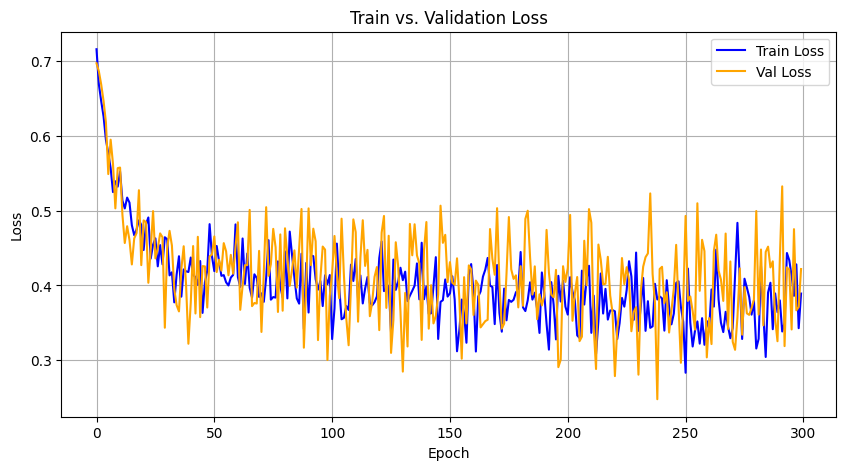

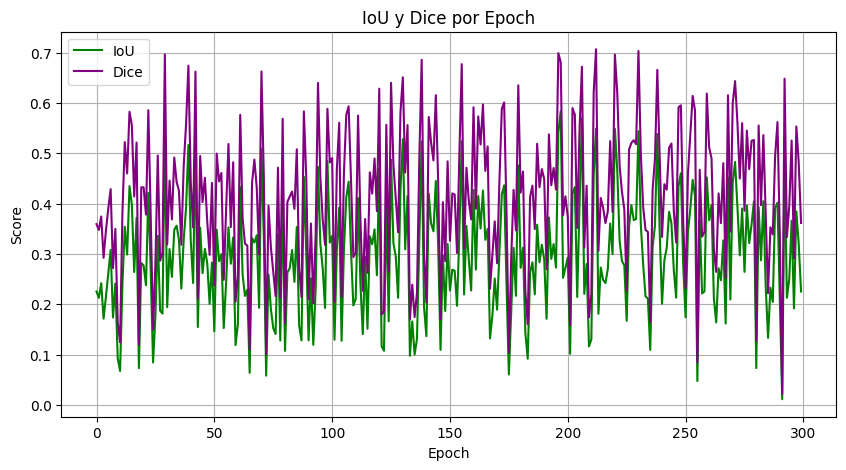

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange')
plt.title("Train vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# IoU + Dice
plt.figure(figsize=(10, 5))
plt.plot(ious, label='IoU', color='green')
plt.plot(dices, label='Dice', color='purple')
plt.title("IoU y Dice por Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 600x600 with 0 Axes>

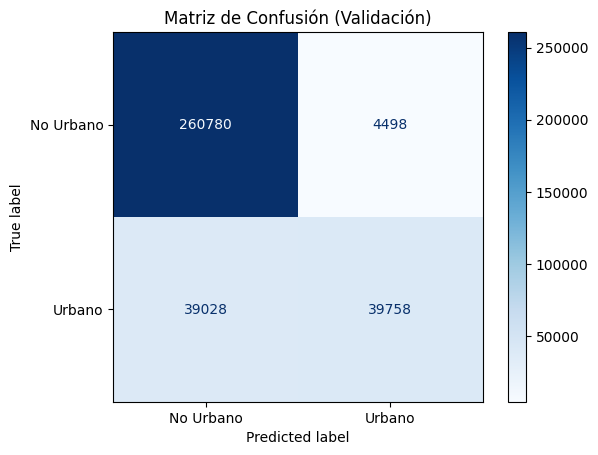

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.numpy().flatten()  # [B, H, W] -> flat

        outputs = model(imgs)
        preds = torch.sigmoid(outputs).cpu().numpy()
        preds = (preds > 0.5).astype(np.uint8).flatten()

        y_true.extend(masks)
        y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=["No Urbano", "Urbano"])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión (Validación)")
plt.show()

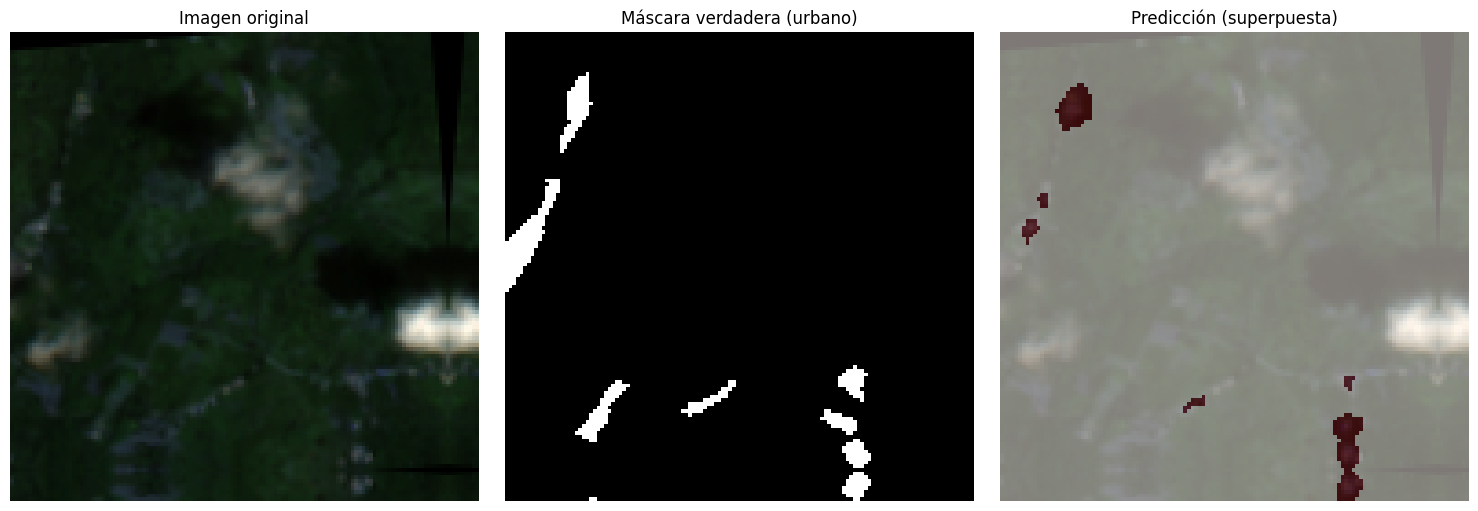

In [ ]:
model.eval()

# Seleccionamos 1 imagen del val_dataset
img, mask = val_dataset[0]
img_input = img.unsqueeze(0).to(device)  # [1, C, H, W]
true_mask = mask.numpy()

with torch.no_grad():
    pred = model(img_input)
    pred_mask = torch.sigmoid(pred).squeeze().cpu().numpy()
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

# Convertimos imagen para visualizar
img_np = img.numpy().transpose(1, 2, 0)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Mostrar
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img_np)
axs[0].set_title("Imagen original")
axs[1].imshow(true_mask, cmap='gray')
axs[1].set_title("Máscara verdadera (urbano)")
axs[2].imshow(img_np)
axs[2].imshow(pred_mask, cmap='Reds', alpha=0.5)
axs[2].set_title("Predicción (superpuesta)")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()


# Segmentación de la clase "Moisaco de pastos y cultivos con espacios naturales"

## Agropecuario - versión 1 (augmentación de datos con 300 epocas)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

output_base = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro'
images_output_path = os.path.join(output_base, 'images')
masks_output_path = os.path.join(output_base, 'masks')

os.makedirs(images_output_path, exist_ok=True)
os.makedirs(masks_output_path, exist_ok=True)


In [ ]:
import shutil

orig_images_path = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset/images'

# Copiar imágenes .tif a la nueva carpeta
for filename in os.listdir(orig_images_path):
    if filename.endswith('.tif'):
        shutil.copy(os.path.join(orig_images_path, filename), os.path.join(images_output_path, filename))

print(f"✅ Imágenes copiadas a: {images_output_path}")


✅ Imágenes copiadas a: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/images


In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
from tqdm import tqdm
import os

# Directorios de entrada y salida
geojson_path = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset/labels'
image_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/images'
mask_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/masks'

# Lista de archivos geojson
geojson_files = [f for f in os.listdir(geojson_path) if f.endswith('.geojson')]

# Contadores para ver qué archivos se procesan correctamente
valid_files_count = 0
invalid_files_count = 0

# Procesar todos los archivos geojson
for gj_file in tqdm(geojson_files, desc='Rasterizando máscaras agropecuarias'):
    gdf = gpd.read_file(os.path.join(geojson_path, gj_file))

    # Filtrar solo clase 4 (agropecuarios)
    gdf = gdf[gdf['class'] == 4]
    if gdf.empty:
        invalid_files_count += 1
        print(f"❌ El archivo {gj_file} no contiene la clase 4.")
        continue  # Si no tiene clase 4, se salta

    # Usar la imagen correspondiente
    base_name = gj_file.replace('.geojson', '.tif')
    image_path = os.path.join(image_dir, base_name)

    if not os.path.exists(image_path):
        invalid_files_count += 1
        print(f"❌ La imagen {base_name} no existe.")
        continue  # Si no existe la imagen correspondiente

    with rasterio.open(image_path) as src:
        meta = src.meta.copy()
        out_shape = (src.height, src.width)
        transform = src.transform

    # Rasterizar geometría
    mask = rasterize(
        [(geom, 1) for geom in gdf.geometry],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    # Guardar la máscara
    mask_path = os.path.join(mask_dir, base_name)
    with rasterio.open(mask_path, 'w', driver='GTiff',
                       height=out_shape[0], width=out_shape[1],
                       count=1, dtype='uint8',
                       crs=meta['crs'], transform=transform) as dst:
        dst.write(mask, 1)
        valid_files_count += 1
        print(f"✅ Máscara generada y guardada en: {mask_path}")

# Resumen de archivos procesados
print(f"\nResumen de procesamiento:")
print(f"✅ Máscaras generadas correctamente: {valid_files_count}")
print(f"❌ Archivos no procesados (sin clase 4 o imagen): {invalid_files_count}")


Rasterizando máscaras agropecuarias:  40%|████      | 4/10 [00:00<00:00, 33.47it/s]

❌ El archivo 6.geojson no contiene la clase 4.
❌ El archivo 7.geojson no contiene la clase 4.
❌ El archivo 18.geojson no contiene la clase 4.
✅ Máscara generada y guardada en: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/masks/22.tif
✅ Máscara generada y guardada en: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/masks/23.tif


Rasterizando máscaras agropecuarias:  80%|████████  | 8/10 [00:00<00:00, 18.48it/s]

✅ Máscara generada y guardada en: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/masks/26.tif
✅ Máscara generada y guardada en: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/masks/30.tif
✅ Máscara generada y guardada en: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/masks/32.tif


Rasterizando máscaras agropecuarias: 100%|██████████| 10/10 [00:00<00:00, 16.58it/s]

✅ Máscara generada y guardada en: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/masks/34.tif
✅ Máscara generada y guardada en: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/masks/39.tif

Resumen de procesamiento:
✅ Máscaras generadas correctamente: 7
❌ Archivos no procesados (sin clase 4 o imagen): 3


In [ ]:
from torch.utils.data import DataLoader, random_split

# Porcentaje de validación
val_pct = 0.2  # Para que solo haya 1 imagen en validación de 7 imágenes (1/7 = 0.142857)
val_size = int(len(full_dataset) * val_pct)
train_size = len(full_dataset) - val_size

# Dividir dataset
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

print(f"✅ Dataset dividido: {train_size} train / {val_size} val")


✅ Dataset dividido: 6 train / 1 val


In [ ]:
# Augmentación fuerte para entrenamiento
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2()
])

# Transformaciones mínimas para validación
val_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-12-fb031d24f4fc>:8: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [ ]:
import os
import rasterio
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F

class UnetAgroDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.filenames = [
            f for f in os.listdir(image_dir)
            if f.endswith('.tif') and os.path.exists(os.path.join(mask_dir, f))
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)

        # Leer imagen (bandas 1-3)
        with rasterio.open(image_path) as src:
            image = src.read([1, 2, 3]).astype(np.float32).transpose(1, 2, 0)

        # Leer máscara
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)

        # Si se aplica augmentación de datos
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            # Convertir la imagen y la máscara a tensores de Pytorch
            image = torch.from_numpy(image.transpose(2, 0, 1))  # Cambiar de HWC a CHW
            mask = torch.from_numpy(mask)

        # Padding reflejado a 128x128
        image = F.pad(image, (0, 8, 0, 8), mode='reflect')
        mask = F.pad(mask.unsqueeze(0).float(), (0, 8, 0, 8), mode='reflect').squeeze(0).long()

        return image, mask


In [ ]:
from torch.utils.data import ConcatDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Rutas de tus imágenes y máscaras de agropecuarios
image_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/images'
mask_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/masks'

# Augmentación fuerte para entrenamiento
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2()
])

# Crear el dataset aumentado
augmented_datasets = [
    UnetAgroDataset(image_dir, mask_dir, transform=train_transform) for _ in range(8)
]

# Concatenar todas las copias
full_augmented_dataset = ConcatDataset(augmented_datasets)
print(f"🧪 Dataset aumentado total: {len(full_augmented_dataset)} muestras")


🧪 Dataset aumentado total: 56 muestras


<ipython-input-14-27d3f15ce786>:16: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [ ]:
from torch.utils.data import DataLoader, Subset
import torch

# Porcentaje de validación
val_pct = 0.3  # 30% para validación

# Total de muestras en el dataset aumentado
total_len = len(full_augmented_dataset)

# Calcular el tamaño de los conjuntos de entrenamiento y validación
val_size = int(total_len * val_pct)
train_size = total_len - val_size

# Obtener los índices de las muestras de entrenamiento y validación
indices = torch.randperm(total_len).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Crear los conjuntos de entrenamiento y validación
train_dataset = Subset(full_augmented_dataset, train_indices)
val_dataset = Subset(full_augmented_dataset, val_indices)

# Crear los DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Imprimir el número de muestras en cada conjunto
print(f"🟩 Train: {len(train_dataset)}")
print(f"🟦 Val: {len(val_dataset)}")


🟩 Train: 40
🟦 Val: 16


In [ ]:
!pip install segmentation-models-pytorch


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 868.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os

# Crear carpeta para los resultados del entrenamiento
output_dir = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/training_results'
os.makedirs(output_dir, exist_ok=True)


In [ ]:
import segmentation_models_pytorch as smp
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definir el modelo UNet con el encoder 'resnet18' y pesos preentrenados en ImageNet
model = smp.Unet(
    encoder_name='resnet18',        # Usamos ResNet18 como encoder
    encoder_weights='imagenet',     # Pesos preentrenados en ImageNet
    in_channels=3,                  # Número de canales de entrada (RGB)
    classes=1,                      # Número de clases (1 clase: agropecuario)
).to(device)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


In [ ]:
import torch.optim as optim
import torch.nn as nn

# Usamos la pérdida binaria con logits, adecuada para tareas de segmentación binaria
criterion = nn.BCEWithLogitsLoss()

# Definir el optimizador Adam con tasa de aprendizaje 1e-4
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Listas para guardar las métricas durante el entrenamiento y validación
train_losses = []
val_losses = []
ious = []
dices = []



In [ ]:
def calculate_iou(pred, target):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def calculate_dice(pred, target):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)

In [ ]:
from tqdm import tqdm

n_epochs = 300
best_iou = 0

for epoch in range(n_epochs):
    model.train()
    train_loss = 0

    for imgs, masks in tqdm(train_loader, desc=f"🟢 Entrenando Epoch {epoch+1}/{n_epochs}"):
        imgs, masks = imgs.to(device), masks.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validación
    model.eval()
    val_loss = 0
    iou_total = 0
    dice_total = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device).unsqueeze(1).float()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            iou_total += calculate_iou(preds, masks)
            dice_total += calculate_dice(preds, masks)

    val_loss /= len(val_loader)
    iou_avg = iou_total / len(val_loader)
    dice_avg = dice_total / len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    ious.append(iou_avg.item())
    dices.append(dice_avg.item())

    print(f"📊 Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {iou_avg:.4f} | Dice: {dice_avg:.4f}")

    # Guardar mejor modelo
    if iou_avg > best_iou:
        best_iou = iou_avg
        torch.save(model.state_dict(), "/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/best_agro_model.pth")
        print("💾 Modelo guardado (nuevo mejor IoU)")


🟢 Entrenando Epoch 1/300: 100%|██████████| 5/5 [00:17<00:00,  3.51s/it]


📊 Epoch 1/300 | Train Loss: 0.6130 | Val Loss: 0.6404 | IoU: 0.5768 | Dice: 0.7285
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 2/300: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


📊 Epoch 2/300 | Train Loss: 0.5898 | Val Loss: 0.5427 | IoU: 0.6471 | Dice: 0.7854
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 3/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 3/300 | Train Loss: 0.5859 | Val Loss: 0.5841 | IoU: 0.6077 | Dice: 0.7547


🟢 Entrenando Epoch 4/300: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


📊 Epoch 4/300 | Train Loss: 0.6083 | Val Loss: 0.6035 | IoU: 0.6202 | Dice: 0.7643


🟢 Entrenando Epoch 5/300: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


📊 Epoch 5/300 | Train Loss: 0.5643 | Val Loss: 0.6012 | IoU: 0.5696 | Dice: 0.7242


🟢 Entrenando Epoch 6/300: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


📊 Epoch 6/300 | Train Loss: 0.5815 | Val Loss: 0.6293 | IoU: 0.5485 | Dice: 0.7071


🟢 Entrenando Epoch 7/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 7/300 | Train Loss: 0.5847 | Val Loss: 0.5064 | IoU: 0.6440 | Dice: 0.7834


🟢 Entrenando Epoch 8/300: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


📊 Epoch 8/300 | Train Loss: 0.6100 | Val Loss: 0.6760 | IoU: 0.5284 | Dice: 0.6907


🟢 Entrenando Epoch 9/300: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


📊 Epoch 9/300 | Train Loss: 0.5410 | Val Loss: 0.6767 | IoU: 0.5316 | Dice: 0.6931


🟢 Entrenando Epoch 10/300: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


📊 Epoch 10/300 | Train Loss: 0.5996 | Val Loss: 0.6582 | IoU: 0.5459 | Dice: 0.7052


🟢 Entrenando Epoch 11/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 11/300 | Train Loss: 0.5920 | Val Loss: 0.5030 | IoU: 0.6304 | Dice: 0.7722


🟢 Entrenando Epoch 12/300: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


📊 Epoch 12/300 | Train Loss: 0.5710 | Val Loss: 0.5905 | IoU: 0.6060 | Dice: 0.7532


🟢 Entrenando Epoch 13/300: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


📊 Epoch 13/300 | Train Loss: 0.5835 | Val Loss: 0.5879 | IoU: 0.5967 | Dice: 0.7467


🟢 Entrenando Epoch 14/300: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


📊 Epoch 14/300 | Train Loss: 0.5216 | Val Loss: 0.5622 | IoU: 0.6237 | Dice: 0.7676


🟢 Entrenando Epoch 15/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 15/300 | Train Loss: 0.6268 | Val Loss: 0.6204 | IoU: 0.5640 | Dice: 0.7200


🟢 Entrenando Epoch 16/300: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


📊 Epoch 16/300 | Train Loss: 0.5619 | Val Loss: 0.4911 | IoU: 0.6327 | Dice: 0.7714


🟢 Entrenando Epoch 17/300: 100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


📊 Epoch 17/300 | Train Loss: 0.6065 | Val Loss: 0.5639 | IoU: 0.6007 | Dice: 0.7479


🟢 Entrenando Epoch 18/300: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


📊 Epoch 18/300 | Train Loss: 0.6198 | Val Loss: 0.6204 | IoU: 0.5647 | Dice: 0.7180


🟢 Entrenando Epoch 19/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 19/300 | Train Loss: 0.5852 | Val Loss: 0.5634 | IoU: 0.5920 | Dice: 0.7428


🟢 Entrenando Epoch 20/300: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


📊 Epoch 20/300 | Train Loss: 0.5542 | Val Loss: 0.5577 | IoU: 0.6072 | Dice: 0.7556


🟢 Entrenando Epoch 21/300: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


📊 Epoch 21/300 | Train Loss: 0.6059 | Val Loss: 0.6140 | IoU: 0.5592 | Dice: 0.7168


🟢 Entrenando Epoch 22/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 22/300 | Train Loss: 0.5976 | Val Loss: 0.5051 | IoU: 0.6433 | Dice: 0.7817


🟢 Entrenando Epoch 23/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 23/300 | Train Loss: 0.5496 | Val Loss: 0.5946 | IoU: 0.5933 | Dice: 0.7447


🟢 Entrenando Epoch 24/300: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


📊 Epoch 24/300 | Train Loss: 0.5838 | Val Loss: 0.5739 | IoU: 0.5851 | Dice: 0.7382


🟢 Entrenando Epoch 25/300: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


📊 Epoch 25/300 | Train Loss: 0.5986 | Val Loss: 0.5042 | IoU: 0.6490 | Dice: 0.7857
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 26/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 26/300 | Train Loss: 0.5176 | Val Loss: 0.5508 | IoU: 0.6195 | Dice: 0.7640


🟢 Entrenando Epoch 27/300: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


📊 Epoch 27/300 | Train Loss: 0.6264 | Val Loss: 0.5039 | IoU: 0.6486 | Dice: 0.7861


🟢 Entrenando Epoch 28/300: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


📊 Epoch 28/300 | Train Loss: 0.5463 | Val Loss: 0.5958 | IoU: 0.5868 | Dice: 0.7369


🟢 Entrenando Epoch 29/300: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


📊 Epoch 29/300 | Train Loss: 0.5492 | Val Loss: 0.5535 | IoU: 0.6083 | Dice: 0.7565


🟢 Entrenando Epoch 30/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 30/300 | Train Loss: 0.5691 | Val Loss: 0.5561 | IoU: 0.6100 | Dice: 0.7577


🟢 Entrenando Epoch 31/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 31/300 | Train Loss: 0.5305 | Val Loss: 0.5535 | IoU: 0.6117 | Dice: 0.7584


🟢 Entrenando Epoch 32/300: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


📊 Epoch 32/300 | Train Loss: 0.5415 | Val Loss: 0.5819 | IoU: 0.6139 | Dice: 0.7575


🟢 Entrenando Epoch 33/300: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


📊 Epoch 33/300 | Train Loss: 0.5530 | Val Loss: 0.5198 | IoU: 0.6406 | Dice: 0.7808


🟢 Entrenando Epoch 34/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 34/300 | Train Loss: 0.5455 | Val Loss: 0.5097 | IoU: 0.6088 | Dice: 0.7496


🟢 Entrenando Epoch 35/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 35/300 | Train Loss: 0.5580 | Val Loss: 0.6367 | IoU: 0.5537 | Dice: 0.7114


🟢 Entrenando Epoch 36/300: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


📊 Epoch 36/300 | Train Loss: 0.5919 | Val Loss: 0.6415 | IoU: 0.5361 | Dice: 0.6978


🟢 Entrenando Epoch 37/300: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


📊 Epoch 37/300 | Train Loss: 0.5447 | Val Loss: 0.5668 | IoU: 0.6072 | Dice: 0.7519


🟢 Entrenando Epoch 38/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 38/300 | Train Loss: 0.6317 | Val Loss: 0.5949 | IoU: 0.5783 | Dice: 0.7328


🟢 Entrenando Epoch 39/300: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


📊 Epoch 39/300 | Train Loss: 0.5440 | Val Loss: 0.6102 | IoU: 0.5678 | Dice: 0.7222


🟢 Entrenando Epoch 40/300: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


📊 Epoch 40/300 | Train Loss: 0.5597 | Val Loss: 0.4971 | IoU: 0.6244 | Dice: 0.7686


🟢 Entrenando Epoch 41/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 41/300 | Train Loss: 0.5905 | Val Loss: 0.4410 | IoU: 0.6855 | Dice: 0.8120
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 42/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 42/300 | Train Loss: 0.5548 | Val Loss: 0.5547 | IoU: 0.6048 | Dice: 0.7537


🟢 Entrenando Epoch 43/300: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


📊 Epoch 43/300 | Train Loss: 0.5987 | Val Loss: 0.5611 | IoU: 0.6365 | Dice: 0.7764


🟢 Entrenando Epoch 44/300: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


📊 Epoch 44/300 | Train Loss: 0.5720 | Val Loss: 0.5554 | IoU: 0.6044 | Dice: 0.7507


🟢 Entrenando Epoch 45/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 45/300 | Train Loss: 0.5591 | Val Loss: 0.5690 | IoU: 0.6362 | Dice: 0.7774


🟢 Entrenando Epoch 46/300: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


📊 Epoch 46/300 | Train Loss: 0.5576 | Val Loss: 0.6274 | IoU: 0.5495 | Dice: 0.7076


🟢 Entrenando Epoch 47/300: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


📊 Epoch 47/300 | Train Loss: 0.5566 | Val Loss: 0.5921 | IoU: 0.5863 | Dice: 0.7375


🟢 Entrenando Epoch 48/300: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


📊 Epoch 48/300 | Train Loss: 0.5290 | Val Loss: 0.5495 | IoU: 0.6035 | Dice: 0.7524


🟢 Entrenando Epoch 49/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 49/300 | Train Loss: 0.6347 | Val Loss: 0.5214 | IoU: 0.6315 | Dice: 0.7700


🟢 Entrenando Epoch 50/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 50/300 | Train Loss: 0.5430 | Val Loss: 0.5050 | IoU: 0.6240 | Dice: 0.7684


🟢 Entrenando Epoch 51/300: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


📊 Epoch 51/300 | Train Loss: 0.5352 | Val Loss: 0.4991 | IoU: 0.6571 | Dice: 0.7927


🟢 Entrenando Epoch 52/300: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


📊 Epoch 52/300 | Train Loss: 0.5223 | Val Loss: 0.5487 | IoU: 0.6116 | Dice: 0.7575


🟢 Entrenando Epoch 53/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 53/300 | Train Loss: 0.6196 | Val Loss: 0.5143 | IoU: 0.6706 | Dice: 0.8019


🟢 Entrenando Epoch 54/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 54/300 | Train Loss: 0.5351 | Val Loss: 0.5693 | IoU: 0.5895 | Dice: 0.7413


🟢 Entrenando Epoch 55/300: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


📊 Epoch 55/300 | Train Loss: 0.5868 | Val Loss: 0.4966 | IoU: 0.6813 | Dice: 0.8073


🟢 Entrenando Epoch 56/300: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


📊 Epoch 56/300 | Train Loss: 0.5488 | Val Loss: 0.5984 | IoU: 0.5760 | Dice: 0.7296


🟢 Entrenando Epoch 57/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 57/300 | Train Loss: 0.5708 | Val Loss: 0.5337 | IoU: 0.6156 | Dice: 0.7617


🟢 Entrenando Epoch 58/300: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


📊 Epoch 58/300 | Train Loss: 0.5651 | Val Loss: 0.6203 | IoU: 0.5998 | Dice: 0.7471


🟢 Entrenando Epoch 59/300: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


📊 Epoch 59/300 | Train Loss: 0.5639 | Val Loss: 0.5512 | IoU: 0.6514 | Dice: 0.7884


🟢 Entrenando Epoch 60/300: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


📊 Epoch 60/300 | Train Loss: 0.5503 | Val Loss: 0.5838 | IoU: 0.5898 | Dice: 0.7419


🟢 Entrenando Epoch 61/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 61/300 | Train Loss: 0.5023 | Val Loss: 0.5369 | IoU: 0.6169 | Dice: 0.7630


🟢 Entrenando Epoch 62/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 62/300 | Train Loss: 0.5506 | Val Loss: 0.4847 | IoU: 0.6478 | Dice: 0.7835


🟢 Entrenando Epoch 63/300: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


📊 Epoch 63/300 | Train Loss: 0.5210 | Val Loss: 0.5378 | IoU: 0.6425 | Dice: 0.7763


🟢 Entrenando Epoch 64/300: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


📊 Epoch 64/300 | Train Loss: 0.5462 | Val Loss: 0.5179 | IoU: 0.6345 | Dice: 0.7757


🟢 Entrenando Epoch 65/300: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


📊 Epoch 65/300 | Train Loss: 0.6108 | Val Loss: 0.6287 | IoU: 0.5587 | Dice: 0.7145


🟢 Entrenando Epoch 66/300: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


📊 Epoch 66/300 | Train Loss: 0.5592 | Val Loss: 0.5505 | IoU: 0.6182 | Dice: 0.7640


🟢 Entrenando Epoch 67/300: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


📊 Epoch 67/300 | Train Loss: 0.5679 | Val Loss: 0.6149 | IoU: 0.6151 | Dice: 0.7572


🟢 Entrenando Epoch 68/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 68/300 | Train Loss: 0.5873 | Val Loss: 0.6005 | IoU: 0.5998 | Dice: 0.7463


🟢 Entrenando Epoch 69/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 69/300 | Train Loss: 0.5276 | Val Loss: 0.4494 | IoU: 0.6591 | Dice: 0.7945


🟢 Entrenando Epoch 70/300: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


📊 Epoch 70/300 | Train Loss: 0.5671 | Val Loss: 0.4657 | IoU: 0.6698 | Dice: 0.8005


🟢 Entrenando Epoch 71/300: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


📊 Epoch 71/300 | Train Loss: 0.5899 | Val Loss: 0.6230 | IoU: 0.5476 | Dice: 0.7066


🟢 Entrenando Epoch 72/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 72/300 | Train Loss: 0.4956 | Val Loss: 0.5087 | IoU: 0.6146 | Dice: 0.7612


🟢 Entrenando Epoch 73/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 73/300 | Train Loss: 0.4845 | Val Loss: 0.5774 | IoU: 0.6239 | Dice: 0.7620


🟢 Entrenando Epoch 74/300: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


📊 Epoch 74/300 | Train Loss: 0.5945 | Val Loss: 0.4897 | IoU: 0.6463 | Dice: 0.7846


🟢 Entrenando Epoch 75/300: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


📊 Epoch 75/300 | Train Loss: 0.5738 | Val Loss: 0.6038 | IoU: 0.5704 | Dice: 0.7259


🟢 Entrenando Epoch 76/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 76/300 | Train Loss: 0.4668 | Val Loss: 0.5792 | IoU: 0.5910 | Dice: 0.7402


🟢 Entrenando Epoch 77/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 77/300 | Train Loss: 0.5039 | Val Loss: 0.4882 | IoU: 0.6621 | Dice: 0.7933


🟢 Entrenando Epoch 78/300: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


📊 Epoch 78/300 | Train Loss: 0.5527 | Val Loss: 0.5899 | IoU: 0.5907 | Dice: 0.7403


🟢 Entrenando Epoch 79/300: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


📊 Epoch 79/300 | Train Loss: 0.5334 | Val Loss: 0.5017 | IoU: 0.6556 | Dice: 0.7891


🟢 Entrenando Epoch 80/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 80/300 | Train Loss: 0.5538 | Val Loss: 0.5579 | IoU: 0.6132 | Dice: 0.7598


🟢 Entrenando Epoch 81/300: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


📊 Epoch 81/300 | Train Loss: 0.6029 | Val Loss: 0.6035 | IoU: 0.5790 | Dice: 0.7326


🟢 Entrenando Epoch 82/300: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


📊 Epoch 82/300 | Train Loss: 0.5285 | Val Loss: 0.5784 | IoU: 0.5711 | Dice: 0.7268


🟢 Entrenando Epoch 83/300: 100%|██████████| 5/5 [00:08<00:00,  1.80s/it]


📊 Epoch 83/300 | Train Loss: 0.5454 | Val Loss: 0.5180 | IoU: 0.6412 | Dice: 0.7810


🟢 Entrenando Epoch 84/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 84/300 | Train Loss: 0.5250 | Val Loss: 0.5741 | IoU: 0.6146 | Dice: 0.7610


🟢 Entrenando Epoch 85/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 85/300 | Train Loss: 0.5051 | Val Loss: 0.6203 | IoU: 0.5842 | Dice: 0.7374


🟢 Entrenando Epoch 86/300: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


📊 Epoch 86/300 | Train Loss: 0.5683 | Val Loss: 0.5805 | IoU: 0.5981 | Dice: 0.7484


🟢 Entrenando Epoch 87/300: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


📊 Epoch 87/300 | Train Loss: 0.5478 | Val Loss: 0.5751 | IoU: 0.6015 | Dice: 0.7510


🟢 Entrenando Epoch 88/300: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


📊 Epoch 88/300 | Train Loss: 0.5011 | Val Loss: 0.4651 | IoU: 0.7043 | Dice: 0.8260
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 89/300: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


📊 Epoch 89/300 | Train Loss: 0.5358 | Val Loss: 0.4922 | IoU: 0.6307 | Dice: 0.7734


🟢 Entrenando Epoch 90/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 90/300 | Train Loss: 0.5460 | Val Loss: 0.6065 | IoU: 0.5929 | Dice: 0.7445


🟢 Entrenando Epoch 91/300: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


📊 Epoch 91/300 | Train Loss: 0.4749 | Val Loss: 0.5325 | IoU: 0.5931 | Dice: 0.7442


🟢 Entrenando Epoch 92/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 92/300 | Train Loss: 0.6220 | Val Loss: 0.5368 | IoU: 0.6367 | Dice: 0.7760


🟢 Entrenando Epoch 93/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 93/300 | Train Loss: 0.5074 | Val Loss: 0.6360 | IoU: 0.5591 | Dice: 0.7136


🟢 Entrenando Epoch 94/300: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


📊 Epoch 94/300 | Train Loss: 0.5847 | Val Loss: 0.6180 | IoU: 0.5840 | Dice: 0.7344


🟢 Entrenando Epoch 95/300: 100%|██████████| 5/5 [00:08<00:00,  1.80s/it]


📊 Epoch 95/300 | Train Loss: 0.5086 | Val Loss: 0.5523 | IoU: 0.5969 | Dice: 0.7445


🟢 Entrenando Epoch 96/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 96/300 | Train Loss: 0.5419 | Val Loss: 0.5983 | IoU: 0.5777 | Dice: 0.7312


🟢 Entrenando Epoch 97/300: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


📊 Epoch 97/300 | Train Loss: 0.4886 | Val Loss: 0.5727 | IoU: 0.5921 | Dice: 0.7437


🟢 Entrenando Epoch 98/300: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


📊 Epoch 98/300 | Train Loss: 0.5678 | Val Loss: 0.5064 | IoU: 0.6558 | Dice: 0.7911


🟢 Entrenando Epoch 99/300: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


📊 Epoch 99/300 | Train Loss: 0.5384 | Val Loss: 0.5799 | IoU: 0.6286 | Dice: 0.7712


🟢 Entrenando Epoch 100/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 100/300 | Train Loss: 0.5559 | Val Loss: 0.5262 | IoU: 0.6203 | Dice: 0.7645


🟢 Entrenando Epoch 101/300: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


📊 Epoch 101/300 | Train Loss: 0.5901 | Val Loss: 0.5212 | IoU: 0.6277 | Dice: 0.7692


🟢 Entrenando Epoch 102/300: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


📊 Epoch 102/300 | Train Loss: 0.4835 | Val Loss: 0.4345 | IoU: 0.6962 | Dice: 0.8204


🟢 Entrenando Epoch 103/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 103/300 | Train Loss: 0.5116 | Val Loss: 0.5446 | IoU: 0.6149 | Dice: 0.7611


🟢 Entrenando Epoch 104/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 104/300 | Train Loss: 0.5358 | Val Loss: 0.4986 | IoU: 0.6711 | Dice: 0.8017


🟢 Entrenando Epoch 105/300: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


📊 Epoch 105/300 | Train Loss: 0.5427 | Val Loss: 0.4231 | IoU: 0.6828 | Dice: 0.8102


🟢 Entrenando Epoch 106/300: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


📊 Epoch 106/300 | Train Loss: 0.5637 | Val Loss: 0.5497 | IoU: 0.6322 | Dice: 0.7745


🟢 Entrenando Epoch 107/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 107/300 | Train Loss: 0.4531 | Val Loss: 0.5247 | IoU: 0.6038 | Dice: 0.7518


🟢 Entrenando Epoch 108/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 108/300 | Train Loss: 0.5279 | Val Loss: 0.5600 | IoU: 0.6054 | Dice: 0.7489


🟢 Entrenando Epoch 109/300: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


📊 Epoch 109/300 | Train Loss: 0.4835 | Val Loss: 0.5153 | IoU: 0.6367 | Dice: 0.7770


🟢 Entrenando Epoch 110/300: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


📊 Epoch 110/300 | Train Loss: 0.5250 | Val Loss: 0.5474 | IoU: 0.6139 | Dice: 0.7603


🟢 Entrenando Epoch 111/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 111/300 | Train Loss: 0.4791 | Val Loss: 0.4682 | IoU: 0.6644 | Dice: 0.7940


🟢 Entrenando Epoch 112/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 112/300 | Train Loss: 0.4853 | Val Loss: 0.4826 | IoU: 0.6502 | Dice: 0.7821


🟢 Entrenando Epoch 113/300: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


📊 Epoch 113/300 | Train Loss: 0.4605 | Val Loss: 0.5003 | IoU: 0.6682 | Dice: 0.7989


🟢 Entrenando Epoch 114/300: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


📊 Epoch 114/300 | Train Loss: 0.5127 | Val Loss: 0.5346 | IoU: 0.6319 | Dice: 0.7744


🟢 Entrenando Epoch 115/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 115/300 | Train Loss: 0.5915 | Val Loss: 0.5428 | IoU: 0.6457 | Dice: 0.7837


🟢 Entrenando Epoch 116/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 116/300 | Train Loss: 0.5359 | Val Loss: 0.5389 | IoU: 0.6132 | Dice: 0.7602


🟢 Entrenando Epoch 117/300: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


📊 Epoch 117/300 | Train Loss: 0.5482 | Val Loss: 0.4736 | IoU: 0.6624 | Dice: 0.7964


🟢 Entrenando Epoch 118/300: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


📊 Epoch 118/300 | Train Loss: 0.4673 | Val Loss: 0.5134 | IoU: 0.6410 | Dice: 0.7798


🟢 Entrenando Epoch 119/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 119/300 | Train Loss: 0.4952 | Val Loss: 0.6197 | IoU: 0.5708 | Dice: 0.7248


🟢 Entrenando Epoch 120/300: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


📊 Epoch 120/300 | Train Loss: 0.4682 | Val Loss: 0.4200 | IoU: 0.7085 | Dice: 0.8282
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 121/300: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


📊 Epoch 121/300 | Train Loss: 0.5457 | Val Loss: 0.4866 | IoU: 0.6255 | Dice: 0.7686


🟢 Entrenando Epoch 122/300: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


📊 Epoch 122/300 | Train Loss: 0.5579 | Val Loss: 0.5055 | IoU: 0.6333 | Dice: 0.7755


🟢 Entrenando Epoch 123/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 123/300 | Train Loss: 0.4772 | Val Loss: 0.4680 | IoU: 0.6684 | Dice: 0.7942


🟢 Entrenando Epoch 124/300: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


📊 Epoch 124/300 | Train Loss: 0.5419 | Val Loss: 0.5875 | IoU: 0.6088 | Dice: 0.7547


🟢 Entrenando Epoch 125/300: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


📊 Epoch 125/300 | Train Loss: 0.4977 | Val Loss: 0.5632 | IoU: 0.6186 | Dice: 0.7604


🟢 Entrenando Epoch 126/300: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


📊 Epoch 126/300 | Train Loss: 0.4803 | Val Loss: 0.4988 | IoU: 0.6276 | Dice: 0.7712


🟢 Entrenando Epoch 127/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 127/300 | Train Loss: 0.5210 | Val Loss: 0.5022 | IoU: 0.6423 | Dice: 0.7819


🟢 Entrenando Epoch 128/300: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


📊 Epoch 128/300 | Train Loss: 0.5456 | Val Loss: 0.4349 | IoU: 0.6981 | Dice: 0.8213


🟢 Entrenando Epoch 129/300: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


📊 Epoch 129/300 | Train Loss: 0.4348 | Val Loss: 0.4164 | IoU: 0.6554 | Dice: 0.7917


🟢 Entrenando Epoch 130/300: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


📊 Epoch 130/300 | Train Loss: 0.4886 | Val Loss: 0.4748 | IoU: 0.6437 | Dice: 0.7826


🟢 Entrenando Epoch 131/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 131/300 | Train Loss: 0.5362 | Val Loss: 0.3989 | IoU: 0.7416 | Dice: 0.8516
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 132/300: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


📊 Epoch 132/300 | Train Loss: 0.5162 | Val Loss: 0.6302 | IoU: 0.5838 | Dice: 0.7362


🟢 Entrenando Epoch 133/300: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


📊 Epoch 133/300 | Train Loss: 0.4588 | Val Loss: 0.4436 | IoU: 0.6439 | Dice: 0.7831


🟢 Entrenando Epoch 134/300: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


📊 Epoch 134/300 | Train Loss: 0.5328 | Val Loss: 0.5935 | IoU: 0.5798 | Dice: 0.7321


🟢 Entrenando Epoch 135/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 135/300 | Train Loss: 0.5709 | Val Loss: 0.4250 | IoU: 0.6692 | Dice: 0.7989


🟢 Entrenando Epoch 136/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 136/300 | Train Loss: 0.4835 | Val Loss: 0.4732 | IoU: 0.7076 | Dice: 0.8259


🟢 Entrenando Epoch 137/300: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


📊 Epoch 137/300 | Train Loss: 0.4988 | Val Loss: 0.5121 | IoU: 0.6335 | Dice: 0.7746


🟢 Entrenando Epoch 138/300: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


📊 Epoch 138/300 | Train Loss: 0.5390 | Val Loss: 0.4556 | IoU: 0.6758 | Dice: 0.8064


🟢 Entrenando Epoch 139/300: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


📊 Epoch 139/300 | Train Loss: 0.5071 | Val Loss: 0.5304 | IoU: 0.6282 | Dice: 0.7684


🟢 Entrenando Epoch 140/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 140/300 | Train Loss: 0.5138 | Val Loss: 0.4982 | IoU: 0.6453 | Dice: 0.7841


🟢 Entrenando Epoch 141/300: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


📊 Epoch 141/300 | Train Loss: 0.5437 | Val Loss: 0.5209 | IoU: 0.6441 | Dice: 0.7835


🟢 Entrenando Epoch 142/300: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


📊 Epoch 142/300 | Train Loss: 0.4983 | Val Loss: 0.6066 | IoU: 0.5993 | Dice: 0.7493


🟢 Entrenando Epoch 143/300: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


📊 Epoch 143/300 | Train Loss: 0.5277 | Val Loss: 0.4078 | IoU: 0.6646 | Dice: 0.7984


🟢 Entrenando Epoch 144/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 144/300 | Train Loss: 0.4645 | Val Loss: 0.5989 | IoU: 0.5810 | Dice: 0.7334


🟢 Entrenando Epoch 145/300: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


📊 Epoch 145/300 | Train Loss: 0.4884 | Val Loss: 0.4382 | IoU: 0.6711 | Dice: 0.8030


🟢 Entrenando Epoch 146/300: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


📊 Epoch 146/300 | Train Loss: 0.4784 | Val Loss: 0.5536 | IoU: 0.5990 | Dice: 0.7476


🟢 Entrenando Epoch 147/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 147/300 | Train Loss: 0.4147 | Val Loss: 0.4981 | IoU: 0.6256 | Dice: 0.7686


🟢 Entrenando Epoch 148/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 148/300 | Train Loss: 0.4755 | Val Loss: 0.5036 | IoU: 0.6231 | Dice: 0.7670


🟢 Entrenando Epoch 149/300: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


📊 Epoch 149/300 | Train Loss: 0.5028 | Val Loss: 0.4688 | IoU: 0.6346 | Dice: 0.7757


🟢 Entrenando Epoch 150/300: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


📊 Epoch 150/300 | Train Loss: 0.4495 | Val Loss: 0.4846 | IoU: 0.6876 | Dice: 0.8143


🟢 Entrenando Epoch 151/300: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


📊 Epoch 151/300 | Train Loss: 0.5127 | Val Loss: 0.4925 | IoU: 0.6340 | Dice: 0.7732


🟢 Entrenando Epoch 152/300: 100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


📊 Epoch 152/300 | Train Loss: 0.4985 | Val Loss: 0.4820 | IoU: 0.6253 | Dice: 0.7694


🟢 Entrenando Epoch 153/300: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


📊 Epoch 153/300 | Train Loss: 0.4531 | Val Loss: 0.4258 | IoU: 0.7000 | Dice: 0.8207


🟢 Entrenando Epoch 154/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 154/300 | Train Loss: 0.4342 | Val Loss: 0.5127 | IoU: 0.6261 | Dice: 0.7678


🟢 Entrenando Epoch 155/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 155/300 | Train Loss: 0.5293 | Val Loss: 0.5075 | IoU: 0.6539 | Dice: 0.7903


🟢 Entrenando Epoch 156/300: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


📊 Epoch 156/300 | Train Loss: 0.5050 | Val Loss: 0.5636 | IoU: 0.6149 | Dice: 0.7610


🟢 Entrenando Epoch 157/300: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


📊 Epoch 157/300 | Train Loss: 0.4851 | Val Loss: 0.4843 | IoU: 0.6463 | Dice: 0.7841


🟢 Entrenando Epoch 158/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 158/300 | Train Loss: 0.5145 | Val Loss: 0.5149 | IoU: 0.6629 | Dice: 0.7956


🟢 Entrenando Epoch 159/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 159/300 | Train Loss: 0.5089 | Val Loss: 0.6297 | IoU: 0.5854 | Dice: 0.7384


🟢 Entrenando Epoch 160/300: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


📊 Epoch 160/300 | Train Loss: 0.4871 | Val Loss: 0.5386 | IoU: 0.6182 | Dice: 0.7636


🟢 Entrenando Epoch 161/300: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


📊 Epoch 161/300 | Train Loss: 0.5724 | Val Loss: 0.4545 | IoU: 0.6546 | Dice: 0.7875


🟢 Entrenando Epoch 162/300: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


📊 Epoch 162/300 | Train Loss: 0.3932 | Val Loss: 0.5943 | IoU: 0.5656 | Dice: 0.7222


🟢 Entrenando Epoch 163/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 163/300 | Train Loss: 0.4696 | Val Loss: 0.5936 | IoU: 0.5978 | Dice: 0.7478


🟢 Entrenando Epoch 164/300: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


📊 Epoch 164/300 | Train Loss: 0.5205 | Val Loss: 0.5248 | IoU: 0.6293 | Dice: 0.7692


🟢 Entrenando Epoch 165/300: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


📊 Epoch 165/300 | Train Loss: 0.4954 | Val Loss: 0.4474 | IoU: 0.6880 | Dice: 0.8142


🟢 Entrenando Epoch 166/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 166/300 | Train Loss: 0.5483 | Val Loss: 0.5041 | IoU: 0.6235 | Dice: 0.7645


🟢 Entrenando Epoch 167/300: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


📊 Epoch 167/300 | Train Loss: 0.4345 | Val Loss: 0.5031 | IoU: 0.6411 | Dice: 0.7804


🟢 Entrenando Epoch 168/300: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


📊 Epoch 168/300 | Train Loss: 0.5578 | Val Loss: 0.5662 | IoU: 0.5903 | Dice: 0.7418


🟢 Entrenando Epoch 169/300: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


📊 Epoch 169/300 | Train Loss: 0.4898 | Val Loss: 0.5563 | IoU: 0.6215 | Dice: 0.7666


🟢 Entrenando Epoch 170/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 170/300 | Train Loss: 0.5015 | Val Loss: 0.5194 | IoU: 0.6430 | Dice: 0.7827


🟢 Entrenando Epoch 171/300: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


📊 Epoch 171/300 | Train Loss: 0.5016 | Val Loss: 0.5448 | IoU: 0.5907 | Dice: 0.7393


🟢 Entrenando Epoch 172/300: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


📊 Epoch 172/300 | Train Loss: 0.5479 | Val Loss: 0.5409 | IoU: 0.6376 | Dice: 0.7738


🟢 Entrenando Epoch 173/300: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


📊 Epoch 173/300 | Train Loss: 0.5368 | Val Loss: 0.4819 | IoU: 0.6130 | Dice: 0.7582


🟢 Entrenando Epoch 174/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 174/300 | Train Loss: 0.5282 | Val Loss: 0.5096 | IoU: 0.6410 | Dice: 0.7808


🟢 Entrenando Epoch 175/300: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


📊 Epoch 175/300 | Train Loss: 0.4664 | Val Loss: 0.3350 | IoU: 0.7707 | Dice: 0.8658
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 176/300: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


📊 Epoch 176/300 | Train Loss: 0.5552 | Val Loss: 0.5149 | IoU: 0.6072 | Dice: 0.7555


🟢 Entrenando Epoch 177/300: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


📊 Epoch 177/300 | Train Loss: 0.4895 | Val Loss: 0.5812 | IoU: 0.6009 | Dice: 0.7507


🟢 Entrenando Epoch 178/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 178/300 | Train Loss: 0.5680 | Val Loss: 0.5552 | IoU: 0.6042 | Dice: 0.7530


🟢 Entrenando Epoch 179/300: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


📊 Epoch 179/300 | Train Loss: 0.5081 | Val Loss: 0.4734 | IoU: 0.6443 | Dice: 0.7837


🟢 Entrenando Epoch 180/300: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


📊 Epoch 180/300 | Train Loss: 0.5038 | Val Loss: 0.5832 | IoU: 0.5950 | Dice: 0.7459


🟢 Entrenando Epoch 181/300: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


📊 Epoch 181/300 | Train Loss: 0.4496 | Val Loss: 0.4979 | IoU: 0.6170 | Dice: 0.7615


🟢 Entrenando Epoch 182/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 182/300 | Train Loss: 0.5669 | Val Loss: 0.4930 | IoU: 0.6055 | Dice: 0.7535


🟢 Entrenando Epoch 183/300: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


📊 Epoch 183/300 | Train Loss: 0.5137 | Val Loss: 0.5482 | IoU: 0.6253 | Dice: 0.7622


🟢 Entrenando Epoch 184/300: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


📊 Epoch 184/300 | Train Loss: 0.5341 | Val Loss: 0.4857 | IoU: 0.6458 | Dice: 0.7848


🟢 Entrenando Epoch 185/300: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


📊 Epoch 185/300 | Train Loss: 0.4816 | Val Loss: 0.5185 | IoU: 0.6452 | Dice: 0.7806


🟢 Entrenando Epoch 186/300: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


📊 Epoch 186/300 | Train Loss: 0.5205 | Val Loss: 0.6128 | IoU: 0.5994 | Dice: 0.7493


🟢 Entrenando Epoch 187/300: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


📊 Epoch 187/300 | Train Loss: 0.5155 | Val Loss: 0.5152 | IoU: 0.6327 | Dice: 0.7749


🟢 Entrenando Epoch 188/300: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


📊 Epoch 188/300 | Train Loss: 0.5059 | Val Loss: 0.5003 | IoU: 0.6500 | Dice: 0.7837


🟢 Entrenando Epoch 189/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 189/300 | Train Loss: 0.4766 | Val Loss: 0.4663 | IoU: 0.6896 | Dice: 0.8158


🟢 Entrenando Epoch 190/300: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


📊 Epoch 190/300 | Train Loss: 0.4449 | Val Loss: 0.5156 | IoU: 0.6665 | Dice: 0.7971


🟢 Entrenando Epoch 191/300: 100%|██████████| 5/5 [00:08<00:00,  1.80s/it]


📊 Epoch 191/300 | Train Loss: 0.4401 | Val Loss: 0.5825 | IoU: 0.6035 | Dice: 0.7526


🟢 Entrenando Epoch 192/300: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


📊 Epoch 192/300 | Train Loss: 0.4301 | Val Loss: 0.4545 | IoU: 0.6740 | Dice: 0.8052


🟢 Entrenando Epoch 193/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 193/300 | Train Loss: 0.4660 | Val Loss: 0.5957 | IoU: 0.5805 | Dice: 0.7340


🟢 Entrenando Epoch 194/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 194/300 | Train Loss: 0.4315 | Val Loss: 0.3925 | IoU: 0.7251 | Dice: 0.8407


🟢 Entrenando Epoch 195/300: 100%|██████████| 5/5 [00:08<00:00,  1.80s/it]


📊 Epoch 195/300 | Train Loss: 0.4819 | Val Loss: 0.4092 | IoU: 0.7109 | Dice: 0.8305


🟢 Entrenando Epoch 196/300: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


📊 Epoch 196/300 | Train Loss: 0.5126 | Val Loss: 0.4600 | IoU: 0.6213 | Dice: 0.7661


🟢 Entrenando Epoch 197/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 197/300 | Train Loss: 0.4549 | Val Loss: 0.5311 | IoU: 0.6404 | Dice: 0.7808


🟢 Entrenando Epoch 198/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 198/300 | Train Loss: 0.5126 | Val Loss: 0.5808 | IoU: 0.5867 | Dice: 0.7366


🟢 Entrenando Epoch 199/300: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


📊 Epoch 199/300 | Train Loss: 0.5152 | Val Loss: 0.4551 | IoU: 0.6422 | Dice: 0.7813


🟢 Entrenando Epoch 200/300: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


📊 Epoch 200/300 | Train Loss: 0.4449 | Val Loss: 0.5518 | IoU: 0.5836 | Dice: 0.7359


🟢 Entrenando Epoch 201/300: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


📊 Epoch 201/300 | Train Loss: 0.4773 | Val Loss: 0.3606 | IoU: 0.7413 | Dice: 0.8502


🟢 Entrenando Epoch 202/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 202/300 | Train Loss: 0.5203 | Val Loss: 0.4168 | IoU: 0.6913 | Dice: 0.8144


🟢 Entrenando Epoch 203/300: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


📊 Epoch 203/300 | Train Loss: 0.5550 | Val Loss: 0.4435 | IoU: 0.6909 | Dice: 0.8120


🟢 Entrenando Epoch 204/300: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


📊 Epoch 204/300 | Train Loss: 0.4447 | Val Loss: 0.5489 | IoU: 0.6010 | Dice: 0.7508


🟢 Entrenando Epoch 205/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 205/300 | Train Loss: 0.4912 | Val Loss: 0.5615 | IoU: 0.5959 | Dice: 0.7448


🟢 Entrenando Epoch 206/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 206/300 | Train Loss: 0.4585 | Val Loss: 0.3721 | IoU: 0.7245 | Dice: 0.8393


🟢 Entrenando Epoch 207/300: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


📊 Epoch 207/300 | Train Loss: 0.5095 | Val Loss: 0.5660 | IoU: 0.5966 | Dice: 0.7424


🟢 Entrenando Epoch 208/300: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


📊 Epoch 208/300 | Train Loss: 0.5641 | Val Loss: 0.5907 | IoU: 0.5733 | Dice: 0.7274


🟢 Entrenando Epoch 209/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 209/300 | Train Loss: 0.4872 | Val Loss: 0.4524 | IoU: 0.6767 | Dice: 0.8023


🟢 Entrenando Epoch 210/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 210/300 | Train Loss: 0.5519 | Val Loss: 0.4562 | IoU: 0.6390 | Dice: 0.7797


🟢 Entrenando Epoch 211/300: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


📊 Epoch 211/300 | Train Loss: 0.4168 | Val Loss: 0.5694 | IoU: 0.5805 | Dice: 0.7326


🟢 Entrenando Epoch 212/300: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


📊 Epoch 212/300 | Train Loss: 0.4973 | Val Loss: 0.4720 | IoU: 0.6523 | Dice: 0.7885


🟢 Entrenando Epoch 213/300: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


📊 Epoch 213/300 | Train Loss: 0.4714 | Val Loss: 0.5510 | IoU: 0.6201 | Dice: 0.7655


🟢 Entrenando Epoch 214/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 214/300 | Train Loss: 0.5067 | Val Loss: 0.5131 | IoU: 0.6219 | Dice: 0.7664


🟢 Entrenando Epoch 215/300: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


📊 Epoch 215/300 | Train Loss: 0.5094 | Val Loss: 0.5897 | IoU: 0.5821 | Dice: 0.7344


🟢 Entrenando Epoch 216/300: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


📊 Epoch 216/300 | Train Loss: 0.5279 | Val Loss: 0.5413 | IoU: 0.5866 | Dice: 0.7395


🟢 Entrenando Epoch 217/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 217/300 | Train Loss: 0.4737 | Val Loss: 0.5369 | IoU: 0.6269 | Dice: 0.7705


🟢 Entrenando Epoch 218/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 218/300 | Train Loss: 0.4047 | Val Loss: 0.5805 | IoU: 0.5927 | Dice: 0.7442


🟢 Entrenando Epoch 219/300: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


📊 Epoch 219/300 | Train Loss: 0.5459 | Val Loss: 0.4229 | IoU: 0.6559 | Dice: 0.7922


🟢 Entrenando Epoch 220/300: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


📊 Epoch 220/300 | Train Loss: 0.5058 | Val Loss: 0.5342 | IoU: 0.6504 | Dice: 0.7877


🟢 Entrenando Epoch 221/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 221/300 | Train Loss: 0.4566 | Val Loss: 0.6319 | IoU: 0.5656 | Dice: 0.7199


🟢 Entrenando Epoch 222/300: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


📊 Epoch 222/300 | Train Loss: 0.4581 | Val Loss: 0.6025 | IoU: 0.5697 | Dice: 0.7236


🟢 Entrenando Epoch 223/300: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


📊 Epoch 223/300 | Train Loss: 0.4794 | Val Loss: 0.5546 | IoU: 0.6097 | Dice: 0.7575


🟢 Entrenando Epoch 224/300: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


📊 Epoch 224/300 | Train Loss: 0.4948 | Val Loss: 0.3737 | IoU: 0.7243 | Dice: 0.8302


🟢 Entrenando Epoch 225/300: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


📊 Epoch 225/300 | Train Loss: 0.4750 | Val Loss: 0.5612 | IoU: 0.6071 | Dice: 0.7516


🟢 Entrenando Epoch 226/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 226/300 | Train Loss: 0.4098 | Val Loss: 0.5853 | IoU: 0.6145 | Dice: 0.7612


🟢 Entrenando Epoch 227/300: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


📊 Epoch 227/300 | Train Loss: 0.4690 | Val Loss: 0.3678 | IoU: 0.7245 | Dice: 0.8392


🟢 Entrenando Epoch 228/300: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


📊 Epoch 228/300 | Train Loss: 0.4909 | Val Loss: 0.5830 | IoU: 0.5918 | Dice: 0.7429


🟢 Entrenando Epoch 229/300: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


📊 Epoch 229/300 | Train Loss: 0.4914 | Val Loss: 0.4032 | IoU: 0.7233 | Dice: 0.8380


🟢 Entrenando Epoch 230/300: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


📊 Epoch 230/300 | Train Loss: 0.4902 | Val Loss: 0.4294 | IoU: 0.6407 | Dice: 0.7807


🟢 Entrenando Epoch 231/300: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


📊 Epoch 231/300 | Train Loss: 0.5328 | Val Loss: 0.5200 | IoU: 0.6069 | Dice: 0.7521


🟢 Entrenando Epoch 232/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 232/300 | Train Loss: 0.4990 | Val Loss: 0.4828 | IoU: 0.6477 | Dice: 0.7823


🟢 Entrenando Epoch 233/300: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


📊 Epoch 233/300 | Train Loss: 0.5029 | Val Loss: 0.4344 | IoU: 0.6817 | Dice: 0.8102


🟢 Entrenando Epoch 234/300: 100%|██████████| 5/5 [00:08<00:00,  1.80s/it]


📊 Epoch 234/300 | Train Loss: 0.5496 | Val Loss: 0.4730 | IoU: 0.6535 | Dice: 0.7901


🟢 Entrenando Epoch 235/300: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


📊 Epoch 235/300 | Train Loss: 0.4752 | Val Loss: 0.4418 | IoU: 0.6677 | Dice: 0.7957


🟢 Entrenando Epoch 236/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 236/300 | Train Loss: 0.4454 | Val Loss: 0.5011 | IoU: 0.6219 | Dice: 0.7632


🟢 Entrenando Epoch 237/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 237/300 | Train Loss: 0.4746 | Val Loss: 0.5482 | IoU: 0.6247 | Dice: 0.7690


🟢 Entrenando Epoch 238/300: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


📊 Epoch 238/300 | Train Loss: 0.5510 | Val Loss: 0.5489 | IoU: 0.6103 | Dice: 0.7547


🟢 Entrenando Epoch 239/300: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


📊 Epoch 239/300 | Train Loss: 0.5378 | Val Loss: 0.5500 | IoU: 0.5779 | Dice: 0.7315


🟢 Entrenando Epoch 240/300: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


📊 Epoch 240/300 | Train Loss: 0.5525 | Val Loss: 0.5491 | IoU: 0.6083 | Dice: 0.7563


🟢 Entrenando Epoch 241/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 241/300 | Train Loss: 0.5810 | Val Loss: 0.5391 | IoU: 0.6036 | Dice: 0.7527


🟢 Entrenando Epoch 242/300: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


📊 Epoch 242/300 | Train Loss: 0.4907 | Val Loss: 0.4539 | IoU: 0.6567 | Dice: 0.7910


🟢 Entrenando Epoch 243/300: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


📊 Epoch 243/300 | Train Loss: 0.4647 | Val Loss: 0.5346 | IoU: 0.6136 | Dice: 0.7580


🟢 Entrenando Epoch 244/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 244/300 | Train Loss: 0.4775 | Val Loss: 0.5410 | IoU: 0.5972 | Dice: 0.7474


🟢 Entrenando Epoch 245/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 245/300 | Train Loss: 0.5101 | Val Loss: 0.5787 | IoU: 0.5777 | Dice: 0.7322


🟢 Entrenando Epoch 246/300: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


📊 Epoch 246/300 | Train Loss: 0.4846 | Val Loss: 0.4325 | IoU: 0.6712 | Dice: 0.7982


🟢 Entrenando Epoch 247/300: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


📊 Epoch 247/300 | Train Loss: 0.5564 | Val Loss: 0.4615 | IoU: 0.6648 | Dice: 0.7979


🟢 Entrenando Epoch 248/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 248/300 | Train Loss: 0.5044 | Val Loss: 0.6094 | IoU: 0.5666 | Dice: 0.7217


🟢 Entrenando Epoch 249/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 249/300 | Train Loss: 0.5952 | Val Loss: 0.5208 | IoU: 0.6682 | Dice: 0.8008


🟢 Entrenando Epoch 250/300: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


📊 Epoch 250/300 | Train Loss: 0.5005 | Val Loss: 0.6319 | IoU: 0.6050 | Dice: 0.7510


🟢 Entrenando Epoch 251/300: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


📊 Epoch 251/300 | Train Loss: 0.4526 | Val Loss: 0.6576 | IoU: 0.5843 | Dice: 0.7334


🟢 Entrenando Epoch 252/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 252/300 | Train Loss: 0.5525 | Val Loss: 0.6273 | IoU: 0.5993 | Dice: 0.7493


🟢 Entrenando Epoch 253/300: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


📊 Epoch 253/300 | Train Loss: 0.4765 | Val Loss: 0.6203 | IoU: 0.5695 | Dice: 0.7250


🟢 Entrenando Epoch 254/300: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


📊 Epoch 254/300 | Train Loss: 0.5233 | Val Loss: 0.6483 | IoU: 0.5634 | Dice: 0.7194


🟢 Entrenando Epoch 255/300: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


📊 Epoch 255/300 | Train Loss: 0.4917 | Val Loss: 0.5235 | IoU: 0.6092 | Dice: 0.7546


🟢 Entrenando Epoch 256/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 256/300 | Train Loss: 0.5246 | Val Loss: 0.6333 | IoU: 0.5691 | Dice: 0.7250


🟢 Entrenando Epoch 257/300: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


📊 Epoch 257/300 | Train Loss: 0.4660 | Val Loss: 0.5576 | IoU: 0.6221 | Dice: 0.7663


🟢 Entrenando Epoch 258/300: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


📊 Epoch 258/300 | Train Loss: 0.5614 | Val Loss: 0.5046 | IoU: 0.6416 | Dice: 0.7805


🟢 Entrenando Epoch 259/300: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


📊 Epoch 259/300 | Train Loss: 0.4390 | Val Loss: 0.4671 | IoU: 0.6600 | Dice: 0.7939


🟢 Entrenando Epoch 260/300: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


📊 Epoch 260/300 | Train Loss: 0.5154 | Val Loss: 0.6935 | IoU: 0.5428 | Dice: 0.7030


🟢 Entrenando Epoch 261/300: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


📊 Epoch 261/300 | Train Loss: 0.4193 | Val Loss: 0.5498 | IoU: 0.6103 | Dice: 0.7579


🟢 Entrenando Epoch 262/300: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


📊 Epoch 262/300 | Train Loss: 0.5047 | Val Loss: 0.4403 | IoU: 0.6849 | Dice: 0.8097


🟢 Entrenando Epoch 263/300: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


📊 Epoch 263/300 | Train Loss: 0.4382 | Val Loss: 0.5955 | IoU: 0.5710 | Dice: 0.7262


🟢 Entrenando Epoch 264/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 264/300 | Train Loss: 0.4855 | Val Loss: 0.5156 | IoU: 0.6519 | Dice: 0.7874


🟢 Entrenando Epoch 265/300: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


📊 Epoch 265/300 | Train Loss: 0.4562 | Val Loss: 0.4903 | IoU: 0.7057 | Dice: 0.8273


🟢 Entrenando Epoch 266/300: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


📊 Epoch 266/300 | Train Loss: 0.4581 | Val Loss: 0.4068 | IoU: 0.6913 | Dice: 0.8172


🟢 Entrenando Epoch 267/300: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


📊 Epoch 267/300 | Train Loss: 0.5184 | Val Loss: 0.4798 | IoU: 0.6481 | Dice: 0.7828


🟢 Entrenando Epoch 268/300: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


📊 Epoch 268/300 | Train Loss: 0.4455 | Val Loss: 0.3768 | IoU: 0.7114 | Dice: 0.8304


🟢 Entrenando Epoch 269/300: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


📊 Epoch 269/300 | Train Loss: 0.5351 | Val Loss: 0.4915 | IoU: 0.6590 | Dice: 0.7935


🟢 Entrenando Epoch 270/300: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


📊 Epoch 270/300 | Train Loss: 0.5035 | Val Loss: 0.5399 | IoU: 0.5987 | Dice: 0.7449


🟢 Entrenando Epoch 271/300: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


📊 Epoch 271/300 | Train Loss: 0.4876 | Val Loss: 0.4102 | IoU: 0.6434 | Dice: 0.7816


🟢 Entrenando Epoch 272/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 272/300 | Train Loss: 0.4688 | Val Loss: 0.5722 | IoU: 0.6213 | Dice: 0.7592


🟢 Entrenando Epoch 273/300: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


📊 Epoch 273/300 | Train Loss: 0.5163 | Val Loss: 0.4581 | IoU: 0.6602 | Dice: 0.7952


🟢 Entrenando Epoch 274/300: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


📊 Epoch 274/300 | Train Loss: 0.4405 | Val Loss: 0.4775 | IoU: 0.6564 | Dice: 0.7922


🟢 Entrenando Epoch 275/300: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


📊 Epoch 275/300 | Train Loss: 0.4899 | Val Loss: 0.5283 | IoU: 0.5980 | Dice: 0.7474


🟢 Entrenando Epoch 276/300: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


📊 Epoch 276/300 | Train Loss: 0.5170 | Val Loss: 0.4963 | IoU: 0.6185 | Dice: 0.7642


🟢 Entrenando Epoch 277/300: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


📊 Epoch 277/300 | Train Loss: 0.4619 | Val Loss: 0.5233 | IoU: 0.6224 | Dice: 0.7643


🟢 Entrenando Epoch 278/300: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


📊 Epoch 278/300 | Train Loss: 0.5006 | Val Loss: 0.5241 | IoU: 0.6175 | Dice: 0.7598


🟢 Entrenando Epoch 279/300: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


📊 Epoch 279/300 | Train Loss: 0.4901 | Val Loss: 0.6249 | IoU: 0.5759 | Dice: 0.7278


🟢 Entrenando Epoch 280/300: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


📊 Epoch 280/300 | Train Loss: 0.4891 | Val Loss: 0.5975 | IoU: 0.5803 | Dice: 0.7332


🟢 Entrenando Epoch 281/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 281/300 | Train Loss: 0.5748 | Val Loss: 0.4712 | IoU: 0.6596 | Dice: 0.7943


🟢 Entrenando Epoch 282/300: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


📊 Epoch 282/300 | Train Loss: 0.4947 | Val Loss: 0.5333 | IoU: 0.6279 | Dice: 0.7628


🟢 Entrenando Epoch 283/300: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


📊 Epoch 283/300 | Train Loss: 0.4995 | Val Loss: 0.4359 | IoU: 0.6860 | Dice: 0.8134


🟢 Entrenando Epoch 284/300: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


📊 Epoch 284/300 | Train Loss: 0.4986 | Val Loss: 0.4270 | IoU: 0.7034 | Dice: 0.8258


🟢 Entrenando Epoch 285/300: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


📊 Epoch 285/300 | Train Loss: 0.4611 | Val Loss: 0.5561 | IoU: 0.6284 | Dice: 0.7685


🟢 Entrenando Epoch 286/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 286/300 | Train Loss: 0.4704 | Val Loss: 0.4255 | IoU: 0.6815 | Dice: 0.7990


🟢 Entrenando Epoch 287/300: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


📊 Epoch 287/300 | Train Loss: 0.4465 | Val Loss: 0.4842 | IoU: 0.6420 | Dice: 0.7817


🟢 Entrenando Epoch 288/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 288/300 | Train Loss: 0.4409 | Val Loss: 0.3897 | IoU: 0.7163 | Dice: 0.8335


🟢 Entrenando Epoch 289/300: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


📊 Epoch 289/300 | Train Loss: 0.4753 | Val Loss: 0.4337 | IoU: 0.6930 | Dice: 0.8144


🟢 Entrenando Epoch 290/300: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


📊 Epoch 290/300 | Train Loss: 0.4084 | Val Loss: 0.5612 | IoU: 0.6112 | Dice: 0.7563


🟢 Entrenando Epoch 291/300: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


📊 Epoch 291/300 | Train Loss: 0.5306 | Val Loss: 0.4065 | IoU: 0.6991 | Dice: 0.8228


🟢 Entrenando Epoch 292/300: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


📊 Epoch 292/300 | Train Loss: 0.5042 | Val Loss: 0.4834 | IoU: 0.6387 | Dice: 0.7791


🟢 Entrenando Epoch 293/300: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


📊 Epoch 293/300 | Train Loss: 0.5154 | Val Loss: 0.3030 | IoU: 0.7828 | Dice: 0.8771
💾 Modelo guardado (nuevo mejor IoU)


🟢 Entrenando Epoch 294/300: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


📊 Epoch 294/300 | Train Loss: 0.5147 | Val Loss: 0.3315 | IoU: 0.7599 | Dice: 0.8628


🟢 Entrenando Epoch 295/300: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


📊 Epoch 295/300 | Train Loss: 0.5636 | Val Loss: 0.4575 | IoU: 0.6736 | Dice: 0.8045


🟢 Entrenando Epoch 296/300: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


📊 Epoch 296/300 | Train Loss: 0.5415 | Val Loss: 0.4831 | IoU: 0.6155 | Dice: 0.7611


🟢 Entrenando Epoch 297/300: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


📊 Epoch 297/300 | Train Loss: 0.4481 | Val Loss: 0.4565 | IoU: 0.6544 | Dice: 0.7911


🟢 Entrenando Epoch 298/300: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


📊 Epoch 298/300 | Train Loss: 0.4664 | Val Loss: 0.4623 | IoU: 0.6741 | Dice: 0.8037


🟢 Entrenando Epoch 299/300: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


📊 Epoch 299/300 | Train Loss: 0.4915 | Val Loss: 0.5186 | IoU: 0.6322 | Dice: 0.7723


🟢 Entrenando Epoch 300/300: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


📊 Epoch 300/300 | Train Loss: 0.4371 | Val Loss: 0.3940 | IoU: 0.7120 | Dice: 0.8244


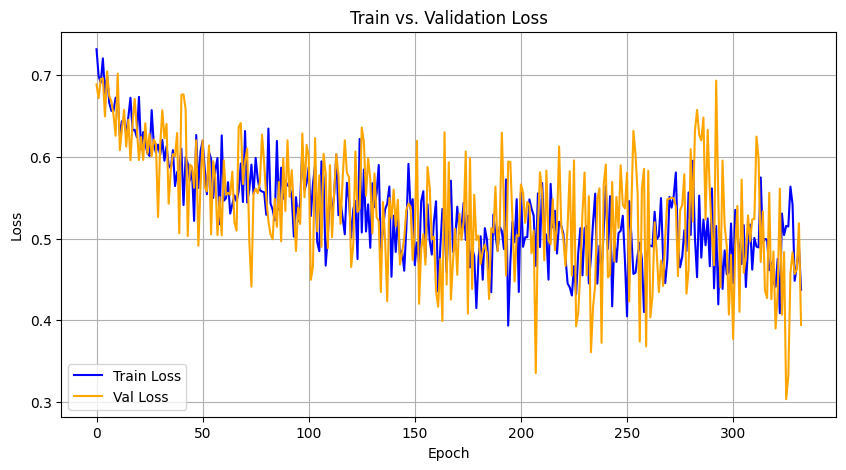

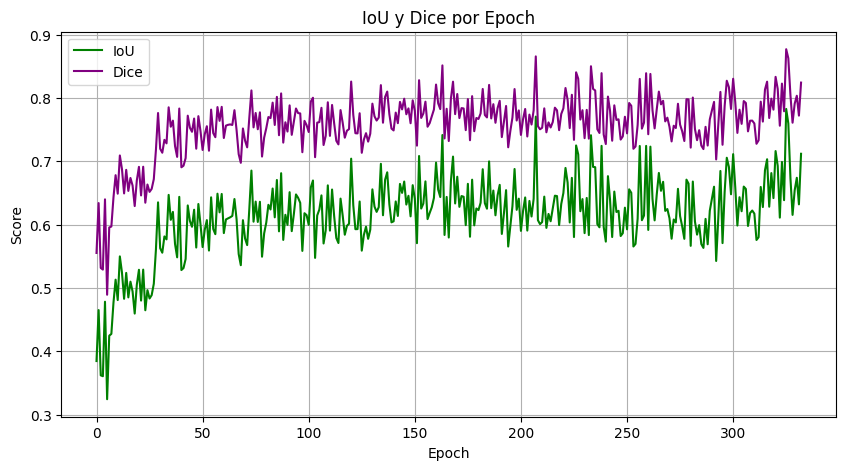

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange')
plt.title("Train vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# IoU + Dice
plt.figure(figsize=(10, 5))
plt.plot(ious, label='IoU', color='green')
plt.plot(dices, label='Dice', color='purple')
plt.title("IoU y Dice por Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 600x600 with 0 Axes>

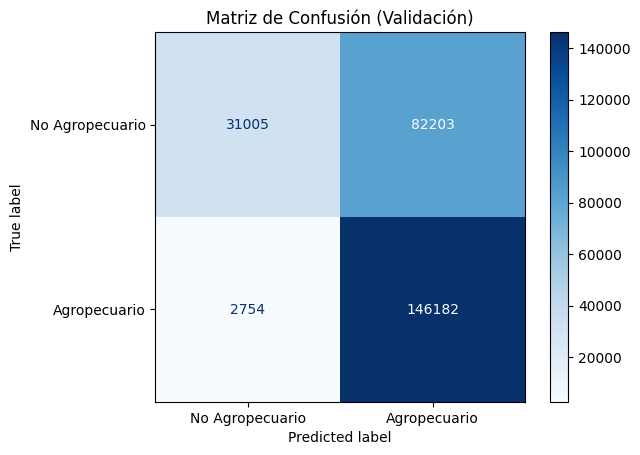

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.numpy().flatten()  # [B, H, W] -> flat

        outputs = model(imgs)
        preds = torch.sigmoid(outputs).cpu().numpy()
        preds = (preds > 0.5).astype(np.uint8).flatten()

        y_true.extend(masks)
        y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=["No Agropecuario", "Agropecuario"])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión (Validación)")
plt.show()


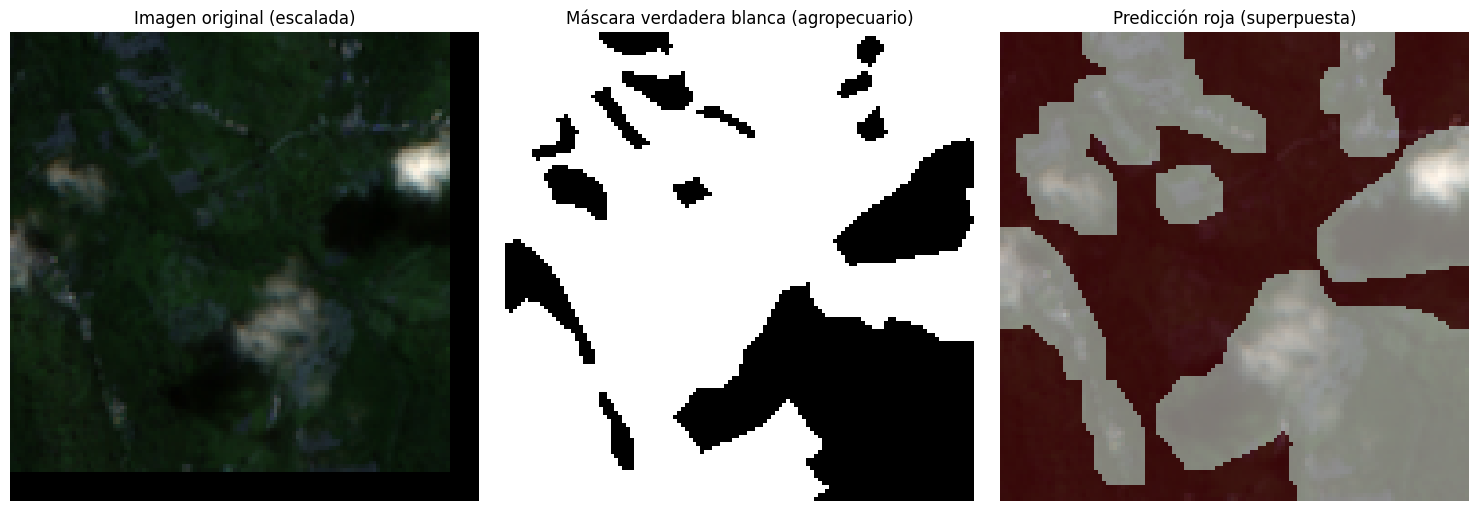

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import rasterio  # Usamos rasterio para abrir el archivo .tif
from torchvision import transforms
import torch.nn.functional as F

# Cargar la imagen original y la máscara usando rasterio
image_path = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/images/32.tif'
mask_path = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/dataset_unet_agro/masks/32.tif'

# Abrir la imagen y la máscara con rasterio
with rasterio.open(image_path) as src:
    image_np = src.read([1, 2, 3])  # Leer las 3 bandas (RGB)
    image_np = np.moveaxis(image_np, 0, -1)  # Cambiar el eje para [H, W, C]

with rasterio.open(mask_path) as src:
    mask_np = src.read(1)  # Leer la única banda de la máscara

# Normalizar la imagen al rango [0, 1]
image_np = image_np / np.max(image_np)  # Aseguramos que los valores estén entre 0 y 1

# Rellenar la imagen para que sea de dimensiones divisibles por 32
height, width, _ = image_np.shape
new_height = int(np.ceil(height / 32) * 32)
new_width = int(np.ceil(width / 32) * 32)

# Aplicar relleno a la imagen
image_padded = np.pad(image_np, ((0, new_height - height), (0, new_width - width), (0, 0)), mode='constant', constant_values=0)

# Convertir la imagen a tensor para pasarlo al modelo
image_tensor = torch.tensor(image_padded).float().permute(2, 0, 1).unsqueeze(0).to(device)  # [1, C, H, W]

# Realizamos la predicción
model.eval()
with torch.no_grad():
    pred = model(image_tensor)
    pred_mask = torch.sigmoid(pred).squeeze().cpu().numpy()
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

# Para suavizar la máscara predicha, podemos hacer un dilatado o erosionado
# Usamos un kernel 5x5 para dilatar la máscara, eliminando detalles pequeños
kernel = np.ones((5, 5), np.uint8)
pred_mask_dilated = cv2.dilate(pred_mask, kernel, iterations=1)

# Mostrar la imagen original, máscara verdadera y predicción
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Imagen original
axs[0].imshow(image_padded)
axs[0].set_title("Imagen original (escalada)")
axs[0].axis('off')

# Máscara verdadera
axs[1].imshow(mask_np, cmap='gray')
axs[1].set_title("Máscara verdadera blanca (agropecuario)")
axs[1].axis('off')

# Predicción con la máscara dilatada
axs[2].imshow(image_padded)
axs[2].imshow(pred_mask_dilated, cmap='Reds', alpha=0.5)
axs[2].set_title("Predicción roja (superpuesta)")
axs[2].axis('off')

plt.tight_layout()
plt.show()
